# Imports

In [2]:
import pypsa
from matplotlib.ticker import ScalarFormatter
from pypsa.optimization.compat import define_constraints, get_var, join_exprs, linexpr
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import xarray as xr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.fft import fft, fftfreq
import seaborn as sns
import pandas as pd 
import matplotlib.ticker as ticker
import geopandas as gpd
import numpy as np
from math import pi
import matplotlib.dates as mdates
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite, region_area, res_capacity_atlite
from interconnectors import calculate_flows, efficiency_link, calculate_distance
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")

# COLOUR PALETTE
unique_regions = list(regions_dic.keys())
base_palette = sns.color_palette("Set2", 8)
extended_palette = base_palette + sns.color_palette("Set3", 8)
final_palette = extended_palette[:len(unique_regions)]
region_colors = {region: color for region, color in zip(unique_regions, final_palette)}
region_colors['ups'] = sns.color_palette("colorblind")[1] 

# User input

In [3]:
# Parameter selection
scenario_year = 2050
era_year = 2023
wind_density = 10 # W/m2
pv_density = 45 # W/m2
wind_land_use_availability = 0.08
pv_land_use_availability = 0.05
SSP_scenario = 'ssp1-26'

## Prediciton of demand and renewable potential time series

In [4]:
run_this_cell = True
if run_this_cell:
    # DISTIANCES BETWEEN NODES
    for key, value in links_dic.items():
        value["length"] = calculate_distance(value["bus0"][1], value["bus1"][1])

    # EFFICIENCY OF INTERCONNECTORS
    cable_capacity = 1200 # MW
    cable_voltage = 1100 # kV
    cable_resistivity = 0.01286 # ohms/km
    converter_losses = 0.015 # [-]
    for key, value in links_dic.items():
        value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

    # SYNTHETIC -> excludes Europe
    path = "/Volumes/fi246disk/synde/resources/gegis/output"
    load_profile_dic = {}
    for key, value in regions_dic.items():
        load_profile_dic[key] = {}
        if key != "north_america" and key != "europe" and key != "alaska":
            load_profile_dic[key]["load"] = syntheticdemand_gis(path, key, SSP_scenario) # MW

    # HISTORIC -> includes Europe and USA
    demand_mult_ssp1_26_oecd = 1.36
    load_profile_dic["europe"]["load"] = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    historic_load_usa = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_usa_2017_utc.csv', 2017, demand_mult_ssp1_26_oecd)
    synthetic_load_north_america_usa = syntheticdemand_gis(path, "north_america_usa", SSP_scenario)
    load_profile_dic["north_america"]["load"] = synthetic_load_north_america_usa

    # RENEWABLE PROFILES
    res_potential_dic = {}
    for key, value in regions_dic.items():
        res_potential_dic[key] = {}
        res_potential_dic[key]["wind"] = vre_gen_potential_atlite(key, "wind", era_year, density=wind_density, land_available=wind_land_use_availability)
        res_potential_dic[key]["pv"] = vre_gen_potential_atlite(key, "pv", era_year, density=pv_density, land_available=pv_land_use_availability) # MW
    
    # NORMALIZING RENEWABLE PROFILES
    for key, value in regions_dic.items():
        normalizing_factor_wind = res_potential_dic[key]["wind"].max()
        normalizing_factor_pv = res_potential_dic[key]["pv"].max()
        res_potential_dic[key]['factor_wind'] = normalizing_factor_wind
        res_potential_dic[key]['factor_pv'] = normalizing_factor_pv
        res_potential_dic[key]["wind_normalized"] = res_potential_dic[key]["wind"] / normalizing_factor_wind
        res_potential_dic[key]["pv_normalized"] = res_potential_dic[key]["pv"] / normalizing_factor_pv

north_america 7.63e+13
north_america 7.63e+13
latin_america 2.15e+13
latin_america 2.15e+13
oceania 1.07e+13
oceania 1.07e+13
north_asia 1.93e+13
north_asia 1.93e+13
south_asia 4.65e+12
south_asia 4.65e+12
north_west_asia 1.10e+13
north_west_asia 1.10e+13
south_west_asia 5.38e+12
south_west_asia 5.38e+12
middle_east 6.65e+12
middle_east 6.65e+12
europe 1.65e+13
europe 1.65e+13
ups 8.49e+13
ups 8.49e+13
north_africa 9.63e+12
north_africa 9.63e+12
africa 2.37e+13
africa 2.37e+13
atlantic_north 3.69e+13
atlantic_north 3.69e+13


AttributeError: 'NoneType' object has no attribute 'max'

## Plotting of regional demand profiles

In [82]:
run_this_cell = False
if run_this_cell:
    num_plots = len(regions_dic)
    rows = (num_plots + 2) // 3

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    def y_format(x, pos):
        return f'{int(x):,}'

    for idx, (key, value) in enumerate(regions_dic.items()):
        load_series = load_profile_dic[key]["load"]
        ax = axs[idx]
        ax.plot(load_series, linewidth=0.6)
        ax.set_title(f'Electricity Demand {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Demand (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

In [83]:
run_this_cell = False
if run_this_cell:
    date_of_interest = '2050-06-21'
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'axes.edgecolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black'
    })

    demand_series = load_profile_dic["north_america"]["load"] * 1e-3  # GW
    demand_monthly = demand_series.groupby(demand_series.index.to_period('M')).mean()
    demand_monthly.index = demand_monthly.index.to_timestamp()

    def format_func(x, pos):
        return '{:.1e}'.format(x)

    plt.figure(figsize=(3.3, 2))
    plt.plot(demand_monthly.index, demand_monthly.values, color='grey', linewidth=1)

    date = pd.Timestamp(date_of_interest)
    demand_value_on_june_21st = demand_monthly.values[5] + (demand_monthly.values[6] - demand_monthly.values[5]) * 21 / 30

    plt.scatter(date, demand_value_on_june_21st, s=10, color='red', zorder=5, label='Specific day')
    plt.ylabel('GW')

    ax = plt.gca()
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0, 3))  # Change the threshold for scientific notation
    ax.yaxis.set_major_formatter(formatter)
    xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
            pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
    xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
    plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))
    plt.xticks(ticks=xticks, labels=xtick_labels)
    plt.gca().annotate('2050', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
    plt.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=3, width=1, color='black')
    plt.grid(False)
    plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/demand-time-series-monthly-output-example.svg', format='svg')
    plt.show()

    demand_june21 = demand_series[demand_series.index.strftime('%Y-%m-%d') == date_of_interest]

    plt.figure(figsize=(3.3, 2))
    plt.plot(demand_june21.index, demand_june21.values, color='red', linewidth=1, linestyle='-', label='Hourly mean')
    plt.ylabel('GW')

    ax = plt.gca()
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0, 3))  # Change the threshold for scientific notation
    ax.yaxis.set_major_formatter(formatter)
    #ax.yaxis.get_offset_text().set_position((1, 1))  # Positioning the offset text at the top right

    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    plt.xlim(pd.Timestamp('2050-06-21 00:00'), pd.Timestamp('2050-06-21 23:00'))
    xticks = pd.date_range(start=date_of_interest, periods=5, freq='6h')
    xticks = xticks[:-1]
    plt.gca().set_xticks(xticks)
    tick_labels = [pd.to_datetime(t, unit='D').strftime('%H:%M') for t in xticks]
    plt.gca().set_xticklabels(tick_labels)
    plt.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=3, width=1, color='black')
    plt.gca().annotate('2050-06-21', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center', fontsize=12)
    plt.gca().annotate('UTC', xy=(1, -0.1), xycoords='axes fraction', ha='center', va='center')

    plt.grid(False)
    plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/demand-time-series-hourly-output-example.svg', format='svg')
    plt.show()


## Plotting of regional renewable profiles

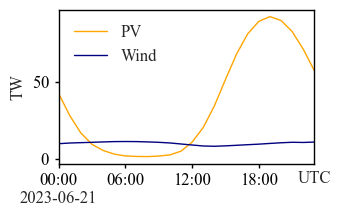

In [103]:
run_this_cell = True
if run_this_cell:
    pv_series = res_potential_dic['north_america']["pv"] * 1e-6 #TW
    wind_series = res_potential_dic['north_america']["wind"] * 1e-6 #TW 

    # Filter the data for the 21st of June, 2050
    date_of_interest = '2050-06-21'
    pv_june21 = pv_series[pv_series.index.strftime('%Y-%m-%d') == date_of_interest] 
    wind_june21 = wind_series[wind_series.index.strftime('%Y-%m-%d') == date_of_interest] 

    # Plotting the data
    plt.figure(figsize=(3.3, 2))
    plt.plot(pv_june21.index, pv_june21.values, label='PV', color='orange' , linewidth=1)
    plt.plot(wind_june21.index, wind_june21.values, label='Wind', color='navy', linewidth=1)
    plt.ylabel('TW')
    plt.xlim(pd.Timestamp('2050-06-21 00:00'), pd.Timestamp('2050-06-21 23:00'))
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    xticks = pd.date_range(start=date_of_interest, periods=5, freq='6h')
    xticks = xticks[:-1] 
    #plt.ylim(0, 9.5e1)
    plt.gca().set_xticks(xticks)
    ax = plt.gca()
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((0, 3))  # Change the threshold for scientific notation
    ax.yaxis.set_major_formatter(formatter)
    tick_labels = [pd.to_datetime(t, unit='D').strftime('%H:%M') for t in xticks]
    plt.gca().set_xticklabels(tick_labels)
    plt.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=3, width=1, color='black')
    plt.legend(frameon=False)
    plt.grid(False)
    plt.gca().annotate('2023-06-21', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')
    plt.gca().annotate('UTC', xy=(1, -0.1), xycoords='axes fraction', ha='center', va='center')

    #plt.yticks([2e4, 4e4, 6e4, 8e4])
    plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/res-time-series-hourly-output-example.svg', format='svg')
    plt.show()


north_america


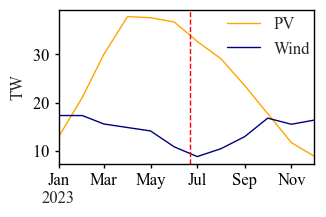

latin_america


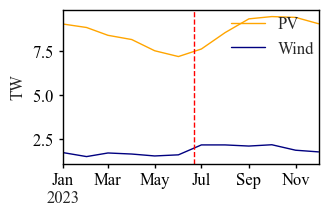

oceania


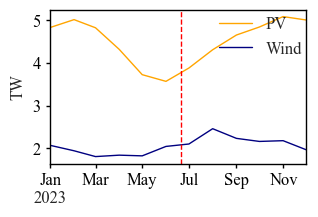

north_asia


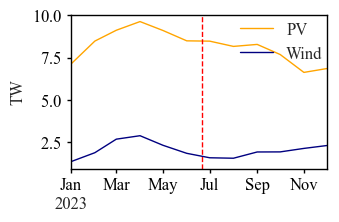

south_asia


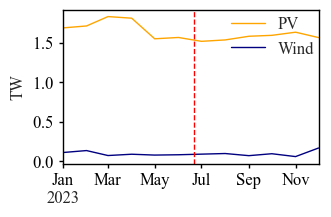

north_west_asia


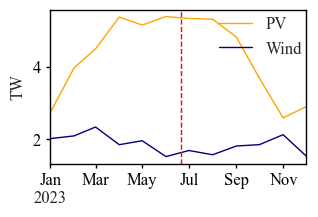

south_west_asia


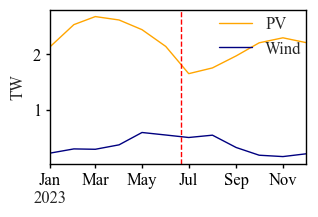

middle_east


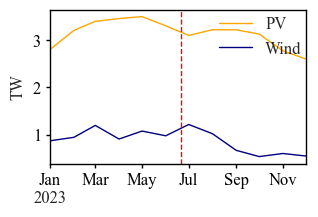

europe


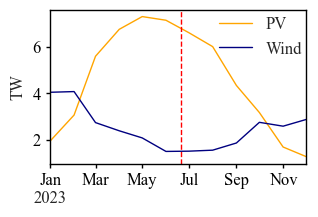

ups


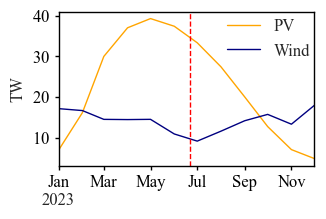

north_africa


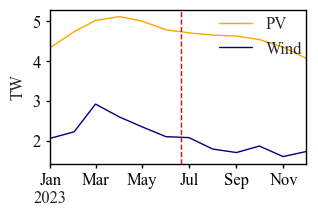

africa


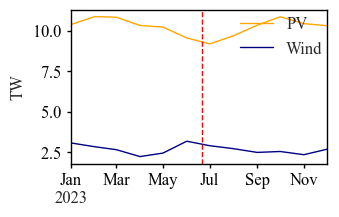

atlantic_north


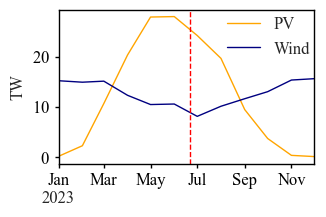

In [106]:
run_this_cell = True
if run_this_cell:
    for region, value in regions_dic.items():
        print(region)
        pv_series = res_potential_dic[f'{region}']["pv"] * 1e-6  # TW
        wind_series = res_potential_dic[f'{region}']["wind"] * 1e-6  # TW

        # Group by month and calculate the mean
        pv_monthly = pv_series.groupby(pv_series.index.to_period('M')).mean()
        wind_monthly = wind_series.groupby(wind_series.index.to_period('M')).mean()

        # Convert PeriodIndex to datetime for plotting
        pv_monthly.index = pv_monthly.index.to_timestamp()
        wind_monthly.index = wind_monthly.index.to_timestamp()

        # Plotting the data as a line plot
        plt.figure(figsize=(3.3, 2))
        plt.plot(pv_monthly.index, pv_monthly.values, label='PV', color='orange', linewidth=1)
        plt.plot(wind_monthly.index, wind_monthly.values, label='Wind', color='navy', linewidth=1)
        june_21st = pd.Timestamp('2050-06-21')
        plt.axvline(x=june_21st, color='red', linestyle='--', linewidth=1)
        plt.ylabel('TW')
        plt.grid(False)
        plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))

        # Manually set the x-ticks for Jan, Mar, May, Jul, Sep, Nov
        xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
                pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
        xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
        plt.xticks(ticks=xticks, labels=xtick_labels)

        ax = plt.gca()
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_powerlimits((0, 3))  # Change the threshold for scientific notation
        ax.yaxis.set_major_formatter(formatter)
        plt.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=3, width=1, color='black')
        plt.legend(bbox_to_anchor=(0.6, 1.05), loc='upper left', frameon=False)
        plt.gca().annotate('2023', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')

        #plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/res-time-series-monthly-output-example.svg', format='svg')
        plt.show()

In [86]:
run_this_cell = False
if run_this_cell:
    pv_series = res_potential_dic['north_america']["pv_normalized"]
    wind_series = res_potential_dic['north_america']["wind_normalized"]

    max_wind_cap = res_potential_dic['north_america']["factor_wind"] * 1e-6
    max_pv_cap = res_potential_dic['north_america']["factor_pv"] * 1e-6

    pv_monthly = pv_series.groupby(pv_series.index.to_period('M')).mean()
    wind_monthly = wind_series.groupby(wind_series.index.to_period('M')).mean()
    wind_monthly_pot_gen = wind_monthly * max_wind_cap

    pv_monthly.index = pv_monthly.index.to_timestamp()
    wind_monthly.index = wind_monthly.index.to_timestamp()
    dates = wind_monthly.index

    plt.figure(figsize=(3.3, 2))
    plt.axhline(y=max_wind_cap, color='green', linestyle='-', label='Potential capacity', linewidth=1)
    plt.plot(wind_monthly.index, wind_monthly_pot_gen.values, color='grey', linewidth=1, label='Potential generation')
    #plt.xlim(pd.Timestamp('2050-01-01'), pd.Timestamp('2050-12-31'))
    plt.ylabel('TW')
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
    plt.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=3, width=1, color='black')
    plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))
    xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
            pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
    xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
    plt.xticks(ticks=xticks, labels=xtick_labels)
    # Add 2050 below the Jan label
    plt.gca().annotate('2050', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')

    plt.grid(False)
    plt.ylim(0.1 * max_wind_cap, 1.2 * max_wind_cap)
    formatter1 = ScalarFormatter(useMathText=True)
    formatter1.set_powerlimits((0, 3))
    plt.gca().yaxis.set_major_formatter(formatter1)

    lines_1, labels_1 = plt.gca().get_legend_handles_labels()
    plt.legend(lines_1, labels_1, bbox_to_anchor=(1.04, 0.34), loc='lower right', frameon=False)

    plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/wind-potential-example.svg', format='svg')
    plt.show()

    wind_deployed = 0.6
    max_generation = max_wind_cap * wind_monthly
    actual_generation = wind_deployed * max_generation
    deployed_cap = max_wind_cap * wind_deployed

    plt.figure(figsize=(3.3, 2))
    plt.axhline(y=max_wind_cap, color='green', linestyle=':', linewidth=1)
    plt.axhline(y=deployed_cap, color='red', linestyle='-', label='Deployed capacity', linewidth=1)
    plt.plot(wind_monthly.index, max_generation, color='grey', linewidth=1, linestyle=':')
    plt.plot(wind_monthly.index, actual_generation, label='Actual generation', color='navy', linewidth=1)#
    plt.ylabel('TW')
    plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))

    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))
    plt.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=3, width=1, color='black')

    # Add 2050 below the Jan label
    plt.gca().annotate('2050', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')
    xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
            pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
    xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
    plt.xticks(ticks=xticks, labels=xtick_labels)
    plt.grid(False)
    plt.ylim(0.1 * max_wind_cap, 1.2 * max_wind_cap)
    formatter1 = ScalarFormatter(useMathText=True)
    formatter1.set_powerlimits((0, 3))
    plt.gca().yaxis.set_major_formatter(formatter1)

    lines_1, labels_1 = plt.gca().get_legend_handles_labels()
    plt.legend(lines_1, labels_1, bbox_to_anchor=(1.04, 1.05), loc='upper right', frameon=False)

    plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/wind-deployment-example.svg', format='svg')
    plt.show()


## PyPSA --> Create the grid 

In [87]:
# Parameter selection
cost_capacity_wind = 1
cost_capacity_pv = 1
cost_generation_wind = 100
cost_generation_pv = 100
cost_transmission = 1e-4
cost_curtailment = 0

# Initialise the network
n = pypsa.Network() 
snapshots = pd.date_range(start=f"{scenario_year}-01-01 00:00:00", end=f"{scenario_year}-12-31 23:00:00", freq="h")
n.set_snapshots(snapshots)

# Loop over the dictionary to add the buses
for key, value in regions_dic.items():
    n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
    
# Loop over the dictionary to add the links 
for key, value in links_dic.items():
    n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)
    n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=cost_transmission, p_nom_max= np.inf, p_nom_extendable=True)

# Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
for key, value in res_potential_dic.items():
    n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=value['factor_wind'], p_max_pu=value["wind_normalized"][snapshots],p_min_pu=value["wind_normalized"][snapshots], capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
    n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=value['factor_pv'], p_max_pu=value["pv_normalized"][snapshots],p_min_pu=value["pv_normalized"][snapshots],capital_cost=cost_capacity_pv, marginal_cost=cost_generation_pv)
    n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable=True, marginal_cost=cost_curtailment, sign=-1)

# Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
for key, value in load_profile_dic.items():
    n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

m = n.optimize.create_model();

n.optimize(solver_name='gurobi')

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s]
INFO:linopy.io: Writing time: 4.71s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-70r6qdyg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-70r6qdyg.lp


Reading time = 2.14 seconds


INFO:gurobipy:Reading time = 2.14 seconds


obj: 1498065 rows, 692119 columns, 3279347 nonzeros


INFO:gurobipy:obj: 1498065 rows, 692119 columns, 3279347 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1498065 rows, 692119 columns and 3279347 nonzeros


INFO:gurobipy:Optimize a model with 1498065 rows, 692119 columns and 3279347 nonzeros


Model fingerprint: 0x309fc4ed


INFO:gurobipy:Model fingerprint: 0x309fc4ed


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [3e-10, 1e+00]


INFO:gurobipy:  Matrix range     [3e-10, 1e+00]


  Objective range  [1e-04, 1e+02]


INFO:gurobipy:  Objective range  [1e-04, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+08]


INFO:gurobipy:  RHS range        [2e+03, 1e+08]


Presolve removed 1384185 rows and 341693 columns


INFO:gurobipy:Presolve removed 1384185 rows and 341693 columns


Presolve time: 0.82s


INFO:gurobipy:Presolve time: 0.82s


Presolved: 113880 rows, 350426 columns, 895021 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 350426 columns, 895021 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.694e+05


INFO:gurobipy: AA' NZ     : 3.694e+05


 Factor NZ  : 3.029e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.029e+06 (roughly 200 MB of memory)


 Factor Ops : 8.297e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.297e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.57553665e+16 -4.91315565e+15  8.05e+09 1.57e+02  2.24e+14     1s


INFO:gurobipy:   0   1.57553665e+16 -4.91315565e+15  8.05e+09 1.57e+02  2.24e+14     1s


   1   2.21074152e+16 -1.45453264e+16  1.43e+10 1.68e+04  1.48e+14     1s


INFO:gurobipy:   1   2.21074152e+16 -1.45453264e+16  1.43e+10 1.68e+04  1.48e+14     1s


   2   1.63920768e+16 -2.70006868e+16  1.25e+10 9.67e+03  9.51e+13     1s


INFO:gurobipy:   2   1.63920768e+16 -2.70006868e+16  1.25e+10 9.67e+03  9.51e+13     1s


   3   7.59688007e+15 -3.03208221e+16  5.25e+09 5.35e+03  4.95e+13     1s


INFO:gurobipy:   3   7.59688007e+15 -3.03208221e+16  5.25e+09 5.35e+03  4.95e+13     1s


   4   4.45169179e+15 -3.80005142e+16  2.66e+09 1.52e+03  1.91e+13     1s


INFO:gurobipy:   4   4.45169179e+15 -3.80005142e+16  2.66e+09 1.52e+03  1.91e+13     1s


   5   1.87417624e+15 -4.91827153e+16  9.82e+08 6.42e+02  7.69e+12     1s


INFO:gurobipy:   5   1.87417624e+15 -4.91827153e+16  9.82e+08 6.42e+02  7.69e+12     1s


   6   1.02157427e+15 -6.57665169e+16  4.88e+08 1.38e+02  3.64e+12     2s


INFO:gurobipy:   6   1.02157427e+15 -6.57665169e+16  4.88e+08 1.38e+02  3.64e+12     2s


   7   5.38700572e+14 -6.83372991e+16  2.18e+08 4.33e+01  1.64e+12     2s


INFO:gurobipy:   7   5.38700572e+14 -6.83372991e+16  2.18e+08 4.33e+01  1.64e+12     2s


   8   2.04106416e+14 -6.19189986e+16  3.20e+07 1.21e+01  3.32e+11     2s


INFO:gurobipy:   8   2.04106416e+14 -6.19189986e+16  3.20e+07 1.21e+01  3.32e+11     2s


   9   1.59859345e+14 -3.34193399e+16  7.79e+06 3.26e+00  9.97e+10     2s


INFO:gurobipy:   9   1.59859345e+14 -3.34193399e+16  7.79e+06 3.26e+00  9.97e+10     2s


  10   1.45618588e+14 -3.13974605e+15  0.00e+00 1.98e-02  7.09e+09     2s


INFO:gurobipy:  10   1.45618588e+14 -3.13974605e+15  0.00e+00 1.98e-02  7.09e+09     2s


  11   1.45350536e+14 -3.72902158e+13  0.00e+00 9.97e-04  3.94e+08     2s


INFO:gurobipy:  11   1.45350536e+14 -3.72902158e+13  0.00e+00 9.97e-04  3.94e+08     2s


  12   1.32018844e+14 -1.59476588e+14  0.00e+00 4.93e-03  6.28e+08     2s


INFO:gurobipy:  12   1.32018844e+14 -1.59476588e+14  0.00e+00 4.93e-03  6.28e+08     2s


  13   1.24011829e+14 -1.85134629e+13  0.00e+00 1.83e-03  3.07e+08     2s


INFO:gurobipy:  13   1.24011829e+14 -1.85134629e+13  0.00e+00 1.83e-03  3.07e+08     2s


  14   1.09886924e+14 -2.14656511e+13  0.00e+00 1.81e-03  2.83e+08     2s


INFO:gurobipy:  14   1.09886924e+14 -2.14656511e+13  0.00e+00 1.81e-03  2.83e+08     2s


  15   1.09780533e+14 -1.65034083e+13  0.00e+00 1.73e-03  2.72e+08     2s


INFO:gurobipy:  15   1.09780533e+14 -1.65034083e+13  0.00e+00 1.73e-03  2.72e+08     2s


  16   1.03019278e+14 -1.74137347e+13  0.00e+00 1.55e-03  2.59e+08     2s


INFO:gurobipy:  16   1.03019278e+14 -1.74137347e+13  0.00e+00 1.55e-03  2.59e+08     2s


  17   9.96316794e+13 -1.08021474e+13  0.00e+00 8.46e-04  2.38e+08     3s


INFO:gurobipy:  17   9.96316794e+13 -1.08021474e+13  0.00e+00 8.46e-04  2.38e+08     3s


  18   9.75476723e+13 -9.68506215e+12  0.00e+00 7.99e-04  2.31e+08     3s


INFO:gurobipy:  18   9.75476723e+13 -9.68506215e+12  0.00e+00 7.99e-04  2.31e+08     3s


  19   8.37156858e+13 -3.90072800e+12  0.00e+00 5.80e-04  1.89e+08     3s


INFO:gurobipy:  19   8.37156858e+13 -3.90072800e+12  0.00e+00 5.80e-04  1.89e+08     3s


  20   6.32887153e+13 -1.70398065e+12  0.00e+00 5.94e-04  1.40e+08     3s


INFO:gurobipy:  20   6.32887153e+13 -1.70398065e+12  0.00e+00 5.94e-04  1.40e+08     3s


  21   4.34497750e+13  2.33568768e+12  0.00e+00 7.82e-04  8.85e+07     3s


INFO:gurobipy:  21   4.34497750e+13  2.33568768e+12  0.00e+00 7.82e-04  8.85e+07     3s


  22   2.92194434e+13  2.71081221e+12  0.00e+00 8.30e-04  5.71e+07     4s


INFO:gurobipy:  22   2.92194434e+13  2.71081221e+12  0.00e+00 8.30e-04  5.71e+07     4s


  23   2.90321447e+13  3.19248540e+12  0.00e+00 8.39e-04  5.56e+07     4s


INFO:gurobipy:  23   2.90321447e+13  3.19248540e+12  0.00e+00 8.39e-04  5.56e+07     4s


  24   2.29709440e+13  3.48822300e+12  0.00e+00 8.35e-04  4.20e+07     4s


INFO:gurobipy:  24   2.29709440e+13  3.48822300e+12  0.00e+00 8.35e-04  4.20e+07     4s


  25   2.25383438e+13  4.07912014e+12  0.00e+00 8.02e-04  3.98e+07     4s


INFO:gurobipy:  25   2.25383438e+13  4.07912014e+12  0.00e+00 8.02e-04  3.98e+07     4s


  26   1.49391841e+13  4.44918789e+12  0.00e+00 7.14e-04  2.26e+07     4s


INFO:gurobipy:  26   1.49391841e+13  4.44918789e+12  0.00e+00 7.14e-04  2.26e+07     4s


  27   9.50199496e+12  5.24336923e+12  0.00e+00 6.33e-04  9.17e+06     5s


INFO:gurobipy:  27   9.50199496e+12  5.24336923e+12  0.00e+00 6.33e-04  9.17e+06     5s


  28   9.06014973e+12  5.40218738e+12  0.00e+00 5.34e-04  7.88e+06     5s


INFO:gurobipy:  28   9.06014973e+12  5.40218738e+12  0.00e+00 5.34e-04  7.88e+06     5s


  29   8.28766747e+12  5.49581846e+12  0.00e+00 4.62e-04  6.01e+06     5s


INFO:gurobipy:  29   8.28766747e+12  5.49581846e+12  0.00e+00 4.62e-04  6.01e+06     5s


  30   7.95771101e+12  5.76770180e+12  0.00e+00 3.78e-04  4.72e+06     5s


INFO:gurobipy:  30   7.95771101e+12  5.76770180e+12  0.00e+00 3.78e-04  4.72e+06     5s


  31   7.66255717e+12  5.83723717e+12  0.00e+00 3.55e-04  3.93e+06     5s


INFO:gurobipy:  31   7.66255717e+12  5.83723717e+12  0.00e+00 3.55e-04  3.93e+06     5s


  32   7.58390819e+12  5.89674816e+12  0.00e+00 3.33e-04  3.63e+06     6s


INFO:gurobipy:  32   7.58390819e+12  5.89674816e+12  0.00e+00 3.33e-04  3.63e+06     6s


  33   7.50334313e+12  6.17498055e+12  0.00e+00 2.46e-04  2.86e+06     6s


INFO:gurobipy:  33   7.50334313e+12  6.17498055e+12  0.00e+00 2.46e-04  2.86e+06     6s


  34   7.54267711e+12  6.20245728e+12  0.00e+00 2.40e-04  2.89e+06     6s


INFO:gurobipy:  34   7.54267711e+12  6.20245728e+12  0.00e+00 2.40e-04  2.89e+06     6s


  35   7.53965111e+12  6.35268438e+12  0.00e+00 2.03e-04  2.56e+06     6s


INFO:gurobipy:  35   7.53965111e+12  6.35268438e+12  0.00e+00 2.03e-04  2.56e+06     6s


  36   7.46892438e+12  6.63460481e+12  0.00e+00 4.80e-05  1.80e+06     7s


INFO:gurobipy:  36   7.46892438e+12  6.63460481e+12  0.00e+00 4.80e-05  1.80e+06     7s


  37   7.43791871e+12  6.91078588e+12  0.00e+00 3.57e-05  1.14e+06     7s


INFO:gurobipy:  37   7.43791871e+12  6.91078588e+12  0.00e+00 3.57e-05  1.14e+06     7s


  38   7.43610494e+12  6.95911104e+12  0.00e+00 3.12e-05  1.03e+06     7s


INFO:gurobipy:  38   7.43610494e+12  6.95911104e+12  0.00e+00 3.12e-05  1.03e+06     7s


  39   7.41487296e+12  7.20088286e+12  0.00e+00 1.82e-05  4.61e+05     7s


INFO:gurobipy:  39   7.41487296e+12  7.20088286e+12  0.00e+00 1.82e-05  4.61e+05     7s


  40   7.39256219e+12  7.26471933e+12  0.00e+00 1.01e-05  2.75e+05     8s


INFO:gurobipy:  40   7.39256219e+12  7.26471933e+12  0.00e+00 1.01e-05  2.75e+05     8s


  41   7.38918898e+12  7.32065819e+12  0.00e+00 6.45e-06  1.48e+05     8s


INFO:gurobipy:  41   7.38918898e+12  7.32065819e+12  0.00e+00 6.45e-06  1.48e+05     8s


  42   7.37434796e+12  7.35876081e+12  0.00e+00 2.75e-06  3.36e+04     8s


INFO:gurobipy:  42   7.37434796e+12  7.35876081e+12  0.00e+00 2.75e-06  3.36e+04     8s


  43   7.37370763e+12  7.36906688e+12  0.00e+00 2.48e-06  1.00e+04     8s


INFO:gurobipy:  43   7.37370763e+12  7.36906688e+12  0.00e+00 2.48e-06  1.00e+04     8s


  44   7.37228811e+12  7.37104841e+12  0.00e+00 5.09e-07  2.67e+03     8s


INFO:gurobipy:  44   7.37228811e+12  7.37104841e+12  0.00e+00 5.09e-07  2.67e+03     8s


  45   7.37188942e+12  7.37179556e+12  0.00e+00 6.91e-07  2.02e+02     9s


INFO:gurobipy:  45   7.37188942e+12  7.37179556e+12  0.00e+00 6.91e-07  2.02e+02     9s


  46   7.37187155e+12  7.37184348e+12  0.00e+00 1.93e-06  5.96e+01     9s


INFO:gurobipy:  46   7.37187155e+12  7.37184348e+12  0.00e+00 1.93e-06  5.96e+01     9s


  47   7.37186641e+12  7.37185115e+12  0.00e+00 2.67e-06  3.18e+01     9s


INFO:gurobipy:  47   7.37186641e+12  7.37185115e+12  0.00e+00 2.67e-06  3.18e+01     9s


  48   7.37186276e+12  7.37185468e+12  0.00e+00 2.97e-06  1.63e+01     9s


INFO:gurobipy:  48   7.37186276e+12  7.37185468e+12  0.00e+00 2.97e-06  1.63e+01     9s


  49   7.37186079e+12  7.37185624e+12  0.00e+00 2.75e-06  8.78e+00     9s


INFO:gurobipy:  49   7.37186079e+12  7.37185624e+12  0.00e+00 2.75e-06  8.78e+00     9s


  50   7.37185979e+12  7.37185697e+12  0.00e+00 2.61e-06  5.12e+00     9s


INFO:gurobipy:  50   7.37185979e+12  7.37185697e+12  0.00e+00 2.61e-06  5.12e+00     9s


  51   7.37185894e+12  7.37185729e+12  0.00e+00 2.66e-06  2.71e+00    10s


INFO:gurobipy:  51   7.37185894e+12  7.37185729e+12  0.00e+00 2.66e-06  2.71e+00    10s


  52   7.37185852e+12  7.37185744e+12  0.00e+00 2.57e-06  1.56e+00    10s


INFO:gurobipy:  52   7.37185852e+12  7.37185744e+12  0.00e+00 2.57e-06  1.56e+00    10s


  53   7.37185832e+12  7.37185752e+12  0.00e+00 2.51e-06  9.74e-01    10s


INFO:gurobipy:  53   7.37185832e+12  7.37185752e+12  0.00e+00 2.51e-06  9.74e-01    10s


  54   7.37185822e+12  7.37185757e+12  0.00e+00 2.37e-06  6.89e-01    10s


INFO:gurobipy:  54   7.37185822e+12  7.37185757e+12  0.00e+00 2.37e-06  6.89e-01    10s


  55   7.37185815e+12  7.37185761e+12  0.00e+00 2.26e-06  4.94e-01    10s


INFO:gurobipy:  55   7.37185815e+12  7.37185761e+12  0.00e+00 2.26e-06  4.94e-01    10s


  56   7.37185811e+12  7.37185763e+12  0.00e+00 2.23e-06  3.81e-01    11s


INFO:gurobipy:  56   7.37185811e+12  7.37185763e+12  0.00e+00 2.23e-06  3.81e-01    11s


  57   7.37185807e+12  7.37185765e+12  0.00e+00 2.28e-06  2.82e-01    11s


INFO:gurobipy:  57   7.37185807e+12  7.37185765e+12  0.00e+00 2.28e-06  2.82e-01    11s


  58   7.37185805e+12  7.37185767e+12  0.00e+00 2.28e-06  2.12e-01    11s


INFO:gurobipy:  58   7.37185805e+12  7.37185767e+12  0.00e+00 2.28e-06  2.12e-01    11s


  59   7.37185802e+12  7.37185768e+12  0.00e+00 2.30e-06  1.47e-01    11s


INFO:gurobipy:  59   7.37185802e+12  7.37185768e+12  0.00e+00 2.30e-06  1.47e-01    11s


INFO:gurobipy:


Barrier solved model in 59 iterations and 10.99 seconds (13.83 work units)


INFO:gurobipy:Barrier solved model in 59 iterations and 10.99 seconds (13.83 work units)


Optimal objective 7.37185802e+12


INFO:gurobipy:Optimal objective 7.37185802e+12


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


    9289 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:    9289 DPushes remaining with DInf 0.0000000e+00                14s


       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


  319214 PPushes remaining with PInf 1.1020167e-02                14s


INFO:gurobipy:  319214 PPushes remaining with PInf 1.1020167e-02                14s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9686910e-01     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9686910e-01     14s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  326170    7.3718578e+12   0.000000e+00   2.968691e-01     14s


INFO:gurobipy:  326170    7.3718578e+12   0.000000e+00   2.968691e-01     14s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


  327776    7.3718577e+12   0.000000e+00   7.489362e-03     15s


INFO:gurobipy:  327776    7.3718577e+12   0.000000e+00   7.489362e-03     15s


Extra simplex iterations after uncrush: 143


INFO:gurobipy:Extra simplex iterations after uncrush: 143


  329196    7.3718577e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:  329196    7.3718577e+12   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Solved in 329196 iterations and 15.82 seconds (21.54 work units)


INFO:gurobipy:Solved in 329196 iterations and 15.82 seconds (21.54 work units)


Optimal objective  7.371857741e+12


INFO:gurobipy:Optimal objective  7.371857741e+12
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 692119 primals, 1498065 duals
Objective: 7.37e+12
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

## Installed capacities

In [88]:
asia = ['north_asia', 'south_asia', 'south_west_asia']
eurasia = ['ups', 'north_west_asia']
africa = ['north_africa', 'africa']
irena_regions = ['africa', 'asia', 'middle_east', 'eurasia', 'oceania', 'europe', 'north_america', 'south_america']
irena_pv_values = []
irena_regions_dict = {
    'africa': {'region': africa},
    'asia': {'region': asia},
    'middle_east': {'region': ['middle_east']},
    'eurasia': {'region': eurasia},
    'oceania': {'region': ['oceania']},
    'europe': {'region': ['europe']},
    'north_america': {'region': ['north_america']},
    'atlantic_north': {'region': ['atlantic_north']},
    'latin_america': {'region': ['latin_america']}
}
actual_pv_data = { #GW
    'world': 1053.12,
    'asia': 597.57,
    'europe': 229.62,
    'north_america': 126.44,
    'latin_america': 32.77 + 3.99,
    'oceania': 27.40,
    'middle_east': 12.88,
    'africa': 12.64,
    'eurasia': 11.62,
    'atlantic_north': 0
}

actual_wind_data = { #GW
    'world': 898.82,
    'asia': 425.67,
    'europe': 240.62,
    'north_america': 163.47,
    'latin_america': 33.47 + 2.04,
    'eurasia': 13.71,
    'oceania': 11.10,
    'africa': 7.68,
    'middle_east': 1.05,
    'atlantic_north': 0
}

for key, value in irena_regions_dict.items():
    value['wind'] = {}
    value['pv'] = {}
    wind = 0
    pv = 0
    for region in value['region']:
        wind += n.generators.p_nom_opt[f'wind_{region}'] * 1e-3
        pv += n.generators.p_nom_opt[f'pv_{region}'] * 1e-3
        print(region, 'pv', pv)
    value['wind'] = wind
    value['pv'] = pv
irena_regions_dict

north_africa pv 1028.2376591878499
africa pv 1028.2376591878499
north_asia pv 0.0
south_asia pv 0.0
south_west_asia pv 0.0
middle_east pv 0.0
ups pv 854.175001026086
north_west_asia pv 854.175001026086
oceania pv 1548.8355242301
europe pv 1467.9196505547313
north_america pv 2165.559310324474
atlantic_north pv 282.3985907797942
latin_america pv 640.407821238188


{'africa': {'region': ['north_africa', 'africa'],
  'wind': 3119.9989132969968,
  'pv': 1028.2376591878499},
 'asia': {'region': ['north_asia', 'south_asia', 'south_west_asia'],
  'wind': 4270.62078123688,
  'pv': 0.0},
 'middle_east': {'region': ['middle_east'],
  'wind': 343.50836888817423,
  'pv': 0.0},
 'eurasia': {'region': ['ups', 'north_west_asia'],
  'wind': 1115.245993393128,
  'pv': 854.175001026086},
 'oceania': {'region': ['oceania'],
  'wind': 2772.1039680005997,
  'pv': 1548.8355242301},
 'europe': {'region': ['europe'],
  'wind': 259.3988997060461,
  'pv': 1467.9196505547313},
 'north_america': {'region': ['north_america'],
  'wind': 1640.5975573293422,
  'pv': 2165.559310324474},
 'atlantic_north': {'region': ['atlantic_north'],
  'wind': 1044.0144668410333,
  'pv': 282.3985907797942},
 'latin_america': {'region': ['latin_america'],
  'wind': 544.143363807516,
  'pv': 640.407821238188}}

global_wind 15109.632312499716 -507.52901116070416 15109.632312499716 0.05948655674807089
global_pv 7987.533557341223 -247.65762704790083 0.13184545547631446
asia
africa
oceania
north_america
europe
eurasia
atlantic_north
latin_america
middle_east


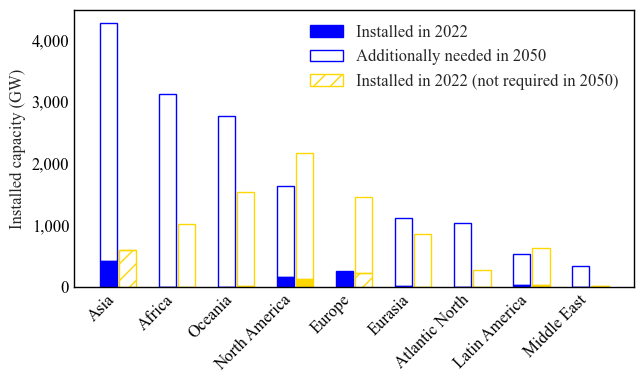

In [99]:
world_wind = sum([value['wind'] for value in irena_regions_dict.values()])
world_pv = sum([value['pv'] for value in irena_regions_dict.values()])
print('global_wind',world_wind,(actual_wind_data['world'] - world_wind)/28, world_wind,actual_wind_data['world'] / world_wind )
print('global_pv', world_pv,(actual_pv_data['world'] - world_pv)/28, actual_pv_data['world'] / world_pv)
#irena_regions_dict['world'] = {'region': ['world'], 'wind': world_wind, 'pv': world_pv}
regions = list(irena_regions_dict.keys())
wind_values_diff = [irena_regions_dict[region]['wind'] - actual_wind_data[region] if irena_regions_dict[region]['wind'] - actual_wind_data[region] >=0 else 0  for region in regions]
pv_values_diff = [irena_regions_dict[region]['pv'] - actual_pv_data[region] if irena_regions_dict[region]['pv'] - actual_pv_data[region] >=0 else 0 for region in regions]
actual_wind_values = [actual_wind_data[region] for region in regions]
actual_pv_values = [actual_pv_data[region] for region in regions]

data = [
    (
        region, 
        actual_wind_data[region], 
        actual_pv_data[region], 
        irena_regions_dict[region]['wind'] - actual_wind_data[region] if irena_regions_dict[region]['wind'] - actual_wind_data[region] >= 0 else 0, 
        irena_regions_dict[region]['pv'] - actual_pv_data[region] if irena_regions_dict[region]['pv'] - actual_pv_data[region] >= 0 else 0
    )
    for region in irena_regions_dict.keys()
]

# Sort data by the highest value which is the sum of diff and the actual
data.sort(key=lambda x: max(x[1] + x[3], x[2] + x[4]), reverse=True)

regions = [item[0] for item in data]
actual_wind_values = [item[1] for item in data]
actual_pv_values= [item[2] for item in data]
wind_values_diff = [item[3] for item in data]
pv_values_diff = [item[4] for item in data]

# Plotting the data
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

fig, ax = plt.subplots(figsize=(6.6, 4))

# Bar chart for Wind and PV values by Region
bar_width = 0.3
mult = 1.08
x = np.arange(len(regions))

for i, region in enumerate(regions):
    print(region)
    hatch_pv = '//' if region in ['europe', 'asia'] else ''
    color_pv = 'none' if region in ['europe', 'asia'] else 'gold'
    label_pv = 'Installed in 2022 (not required in 2050)' if region in ['europe'] else None
    ax.bar(x[i] - bar_width / 2 * mult, actual_wind_values[i], bar_width, label='Installed in 2022' if i == 0 else "", color='blue', edgecolor='blue')
    ax.bar(x[i] + bar_width / 2 * mult, actual_pv_values[i], bar_width, color=color_pv, edgecolor='gold', hatch=hatch_pv, label=label_pv)
    ax.bar(x[i] - bar_width / 2 * mult, wind_values_diff[i], bar_width, bottom=actual_wind_values[i], label='Additionally needed in 2050' if i == 0 else "", color='none', edgecolor='blue')
    ax.bar(x[i] + bar_width / 2 * mult, pv_values_diff[i], bar_width, bottom=actual_pv_values[i], color='none', edgecolor='gold')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels([region.replace('_', ' ').title() for region in regions], rotation=45, ha='right')
ax.set_ylabel('Installed capacity (GW)')
ax.legend(frameon=False)

def format_func(value, tick_number):
    return f'{value:,.0f}'

formatter = FuncFormatter(format_func)
plt.gca().yaxis.set_major_formatter(formatter)

# Adjust layout
plt.tight_layout()
plt.grid(False)
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/bar-chart-installed-cap.pdf', format='pdf')

plt.show()

# **ANALYSIS OF GLOBAL GRID**

## Caluclate installed capacity, generation, curtailment and demand for each region

In [90]:
for key, value in regions_dic.items(): # Annual (total) values
    for carrier in ["pv", "wind"]: 
        regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW; Installed capacities for each node 
        regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GWh; Total energy generated at each node 
    
    regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GWh; Curtailment at each node 
    regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GWh
 
for key, value in regions_dic.items():
    # Generation data of each node
    for carrier in ["pv", "wind"]:
        series_g = n.generators_t.p[f"{carrier}_{key}"] * 1e-3 # GW
        regions_dic[key][f"mean_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).mean() # GW
        regions_dic[key][f"total_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).sum() # GWh
        regions_dic[key][f"mean_{carrier}_daily"] = series_g.groupby(series_g.index.date).mean() # GW
        regions_dic[key][f"total_{carrier}_daily"] = series_g.groupby(series_g.index.date).sum() # GW
    # Curtailment data of each node
    series_c = n.generators_t.p[f"curtailment_{key}"] * 1e-3 # GW
    regions_dic[key][f"total_curtailment_daily"] = series_c.groupby(series_c.index.date).sum() # GW
    regions_dic[key][f"mean_curtailment_daily"] = series_c.groupby(series_c.index.date).mean() # GW
    regions_dic[key][f"mean_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).mean() # GW
    regions_dic[key][f"total_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).sum() # GWh
    # Demand data of each node
    series_l = n.loads_t.p[f"load_{key}"] * 1e-3 # GW
    regions_dic[key][f"total_load_daily"] = series_l.groupby(series_l.index.date).mean() # GW
    regions_dic[key][f"mean_load_daily"] = series_l.groupby(series_l.index.date).mean() # GW
    regions_dic[key][f"mean_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).mean() # GW
    regions_dic[key][f"total_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).sum() # GWh
    
# Daily hourly values of specific days
dates = pd.to_datetime([f"{scenario_year}-03-21", f"{scenario_year}-06-21", f"{scenario_year}-09-21", f"{scenario_year}-12-21", f"{scenario_year}-04-06"])
for date in dates:
    for key, value in regions_dic.items():
        for carrier in ["pv", "wind"]:
            regions_dic[key][f"hourly_{carrier}_{date}"] = n.generators_t.p[f"{carrier}_{key}"].loc[date.strftime('%Y-%m-%d')] # Generation profile for specific day

        regions_dic[key][f"hourly_load_{date}"] = n.loads_t.p[f"load_{key}"].loc[date.strftime('%Y-%m-%d')] # Load profile for a specific day
        regions_dic[key][f"houtly_curtailment_{date}"] = n.generators_t.p[f"curtailment_{key}"].loc[date.strftime('%Y-%m-%d')] # Curtailment profile for specific day

## Calculate hourly time series of generation, curtailment, and load

In [91]:
# Sum generation and loads of nodes
total_hourly_gen = pd.Series(0, index=n.snapshots)
total_hourly_wind = pd.Series(0, index=n.snapshots)
total_hourly_pv = pd.Series(0, index=n.snapshots)
total_hourly_cur = pd.Series(0, index=n.snapshots)
total_hourly_load = pd.Series(0, index=n.snapshots)
for key, value in regions_dic.items():
    total_hourly_gen += n.generators_t.p[f"wind_{key}"] + n.generators_t.p[f"pv_{key}"]
    total_hourly_cur += n.generators_t.p[f"curtailment_{key}"]
    total_hourly_pv += n.generators_t.p[f"pv_{key}"]
    total_hourly_wind += n.generators_t.p[f"wind_{key}"]
    total_hourly_load += n.loads_t.p[f"load_{key}"]
    
# Generation total
total_daily_gen = total_hourly_gen.groupby(total_hourly_gen.index.date).sum()
total_weekly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('W')).sum()
total_monthly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('M')).sum()
total_annual_gen = total_hourly_gen.sum()

# Generation wind
total_daily_wind = total_hourly_wind.groupby(total_hourly_wind.index.date).sum()
total_monthly_wind = total_hourly_wind.groupby(total_hourly_wind.index.to_period('M')).sum()
total_annual_wind = total_hourly_wind.sum()

# Generation pv
total_daily_pv = total_hourly_pv.groupby(total_hourly_pv.index.date).sum()
total_monthly_pv = total_hourly_pv.groupby(total_hourly_pv.index.to_period('M')).sum()
total_annual_pv = total_hourly_pv.sum()

# Curtailment
total_daily_cur = total_hourly_cur.groupby(total_hourly_cur.index.date).sum()
total_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).sum()
total_annual_cur = total_hourly_cur.sum()

# Curtailment std and mean
mean_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).mean()
std_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).std()

# Load 
total_daily_load = total_hourly_load.groupby(total_hourly_load.index.date).sum()
total_monthly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('M')).sum()
total_annual_load = total_hourly_load.sum()


## Calculate global relative transmission, curtailment, and losses  

In [92]:
# Store hourly losses for each link in dictionary
for key, value in links_dic.items():
    p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
    p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
    abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
    p_trans = p0_0 + p0_1
    value["hourly_p_trans"] = p_trans
    value["hourly_abs_losses"] = abs_losses

# Sum the transmission and losses of the links
total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
total_hourly_p_trans = pd.Series(0, index=n.snapshots)
for key, value in links_dic.items():
    total_hourly_abs_losses += value["hourly_abs_losses"]
    total_hourly_p_trans += value["hourly_p_trans"]

# Absolute losses
total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
total_annual_abs_losses = total_hourly_abs_losses.sum()

# Losses std and mean 
total_monthly_losses_std = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).std()
total_monthly_losses_mean = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).mean()

# Power transmitted
total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
total_annual_p_trans = total_hourly_p_trans.sum()

# Relative losses to transmission
hourly_rel_losses = total_hourly_abs_losses / total_hourly_p_trans
daily_rel_losses = total_daily_abs_losses / total_daily_p_trans
monthly_rel_losses = total_monthly_abs_losses / total_monthly_p_trans
annual_rel_losses = total_annual_abs_losses / total_annual_p_trans

# Statistics of the losses to transmission
mean_losses = total_hourly_abs_losses.mean()
std_losses = total_hourly_abs_losses.std()
daily_deviation = daily_rel_losses - daily_rel_losses.mean()
monthly_deviation = monthly_rel_losses - monthly_rel_losses.mean()

# Losses relative to load
hourly_losses_rel_to_load = total_hourly_abs_losses / total_hourly_load
daily_losses_rel_to_load = total_daily_abs_losses / total_daily_load
monthly_losses_rel_to_load = total_monthly_abs_losses / total_monthly_load
annual_losses_rel_to_load = total_annual_abs_losses / total_annual_load

# Losses relative to gen
hourly_losses_rel_to_gen = total_hourly_abs_losses / total_hourly_gen
daily_losses_rel_to_gen = total_daily_abs_losses / total_daily_gen
monthly_losses_rel_to_gen = total_monthly_abs_losses / total_monthly_gen
annual_losses_rel_to_gen = total_annual_abs_losses / total_annual_gen

# Curtailment relative to gen
hourly_cur_rel_to_gen = total_hourly_cur / total_hourly_gen
daily_cur_rel_to_gen = total_daily_cur / total_daily_gen
monthly_cur_rel_to_gen = total_monthly_cur / total_monthly_gen
annual_cur_rel_to_gen = total_annual_cur / total_annual_gen

# Curtailment relative to load
hourly_cur_rel_to_load = total_hourly_cur / total_hourly_load
daily_cur_rel_to_load = total_daily_cur / total_daily_load
monthly_cur_rel_to_load = total_monthly_cur / total_monthly_load
annual_cur_rel_to_load = total_annual_cur / total_annual_load

# Power transmitted rel to gen
hourly_p_trans_rel_gen = total_hourly_p_trans / total_hourly_gen
daily_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum() / total_daily_gen
monthly_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum() / total_monthly_gen
annual_p_trans_rel_gen = total_hourly_p_trans.sum() / total_annual_gen

# Power transmitted rel to load
hourly_p_trans_rel_load= total_hourly_p_trans / total_hourly_load
daily_p_trans_rel_load = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum() / total_daily_load
monthly_p_trans_rel_load = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum() / total_monthly_load
annual_p_trans_rel_load = total_hourly_p_trans.sum() / total_annual_load

## Calculate inflows, outflows, and net flows for each region

In [93]:
# Calculate inflow, outflow, and 
for region_key, region_value in regions_dic.items():
    inflow = 0
    outflow = 0
    inflow_series = pd.Series(0, index=n.snapshots)
    outflow_series = pd.Series(0, index=n.snapshots)
    for link_key, link_value in links_dic.items():
        if region_value["bus"] == link_value["bus0"][0]: 
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
            sum_p0_0 = abs(sum(p0_0))
            sum_p1_1 = abs(sum(p1_1))
            outflow += sum_p0_0
            inflow += sum_p1_1
            outflow_series += p0_0.abs()
            inflow_series += p1_1.abs()
        elif region_value["bus"] == link_value["bus1"][0]:
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
            p1_0 = n.links_t.p1[f"{link_value["name"]}_0"]
            sum_p0_1 = sum(p0_1.abs())
            sum_p1_0 = sum(p1_0.abs())
            outflow += sum_p0_1
            inflow += sum_p1_0
            outflow_series += p0_1.abs()
            inflow_series += p1_0.abs()
    netflow = (outflow - inflow) 
    netflow_series = (outflow_series - inflow_series) 
    region_value["inflow"] = inflow * 1e-3 # GW
    region_value["outflow"] = outflow * 1e-3 # GW
    region_value["inflow_series"] = inflow_series * 1e-3 # GW
    region_value["outflow_series"] = outflow_series * 1e-3 # GW
    region_value["netflow"] = netflow * 1e-3 # GW
    region_value["netflow_series"] = netflow_series * 1e-3 # GW
    region_value["actualflow"] = (outflow_series.abs() - inflow_series.abs()) * 1e-3 # GW
    region_value["actualflow"] = np.where(region_value["actualflow"] < 0, 0, region_value["actualflow"])
    region_value['total_actualflow'] = region_value["actualflow"].sum()



In [94]:
# Compute total power transmitted for each hour
total_actual_flow = pd.Series(0, index=n.snapshots)
total_actual_flow_int = 0
for key, value in regions_dic.items():
    total_actual_flow += value["actualflow"]
    total_actual_flow_int += value["total_actualflow"]

# Actual flow 
hourly_actual_flow_rel_gen = total_actual_flow / total_hourly_gen

def flow_direction(date=None):
    # Compute inflow, outflow direction per link
    flow_statements = {}
    netflows_links = {}
    netflows_links_series = {}
    for link_key, link_value in links_dic.items():
        if date == None:
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
            sum_p0_0 = abs(sum(p0_0))
            sum_p0_1 = abs(sum(p1_1))
            netflows_links[link_key] = abs(sum_p0_0 - sum_p0_1)
            netflows_links_series[link_key] = (p0_0 - p0_1) * 1e-3 #GW
            if sum_p0_0 > sum_p0_1:
                flow_statements[link_key] = True # outflow
            else:
                flow_statements[link_key] = False
        else:
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"][date]
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"][date]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"][date]
            net_flow = abs(p0_0 - p0_1)
            if p0_0 > p0_1:
                flow_statements[link_key] = True # outflow
            else:
                flow_statements[link_key] = False
        
    return flow_statements, netflows_links, netflows_links_series
flow_statements = flow_direction()[0]
netflows_links = flow_direction()[1]
netflows_links_series = flow_direction()[2]

# Calculation of monthly inflows and outflows
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_periods = pd.period_range(start='2050-01', periods=12, freq='M')
month_to_period = {month: period for month, period in zip(months, month_periods)}
for i, month in enumerate(months):
    period = month_to_period[month]
    for region_key, region_value in regions_dic.items():
        inflow = 0
        outflow = 0
        for link_key, link_value in links_dic.items():
            if region_value["bus"] == link_value["bus0"][0]:
                p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
                p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
                monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                sum_p0_0 = abs(monthly_p0_0.loc[period])
                sum_p1_1 = abs(monthly_p1_1.loc[period])
                outflow += sum_p0_0
                inflow += sum_p1_1
            elif region_value["bus"] == link_value["bus1"][0]:
                p0_0 = n.links_t.p0[f"{link_value["name"]}_1"]
                p1_1 = n.links_t.p1[f"{link_value["name"]}_0"]
                monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                sum_p0_0 = abs(monthly_p0_0.loc[period])
                sum_p1_1 = abs(monthly_p1_1.loc[period])
                outflow += sum_p0_0
                inflow += sum_p1_1
        region_value[f"inflow_{month}"] = inflow * 1e-3 # GW
        region_value[f"outflow_{month}"] = outflow * 1e-3 # GW
        region_value[f"netflow_{month}"] = (inflow - outflow) * 1e-3 # GW

## Losses per node

In [95]:
for key, value in regions_dic.items():
    net_inflow = np.where(value["netflow_series"] > 0, 0, value["netflow_series"])
    annual_net_inflow = net_inflow.sum()
    annual_load = value['total_load_yearly']
    share_inflow_consumption = annual_net_inflow / annual_load * 100
    print(key, round(share_inflow_consumption, 2))

north_america -2.37
latin_america -17.3
oceania 0.0
north_asia -58.42
south_asia -100.0
north_west_asia -84.78
south_west_asia -39.2
middle_east -74.69
europe -39.6
ups 0.0
north_africa 0.0
africa 0.0
atlantic_north 0.0


# **Evaluation of results**

## Overview of global grid

In [96]:
wind_share = total_annual_wind / total_annual_gen * 100
pv_share = 100 - wind_share
print('NO TRANSMISSION COST')
print(f'Total generation: {total_annual_gen:.2e}')
print(f'Wind: {round(wind_share, 1)} PV: {round(pv_share, 1)}')
print(f'Total curtailment: {total_annual_cur:.2e}')
print(f'Total transmission: {total_annual_p_trans:.2e}')
print(f'Total net transmission: {total_actual_flow_int:.2e}')
print(f'Total transmission losses: {round(annual_losses_rel_to_gen, 3)}')

NO TRANSMISSION COST
Total generation: 7.37e+10
Wind: 78.0 PV: 22.0
Total curtailment: 1.97e+10
Total transmission: 3.59e+10
Total net transmission: 2.45e+07
Total transmission losses: 0.033


## Plotting of inflow and outflow series

In [97]:
run_this_cell = False
if run_this_cell:
    num_plots = len(regions_dic)
    rows = (num_plots + 2) // 3

    fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axs = axs.flatten()

    def y_format(x, pos):
        return f'{int(x):,}'

    for idx, (key, value) in enumerate(regions_dic.items()):
        inflow_series = - regions_dic[key]['inflow_series']
        ax = axs[idx]
        ax.plot(inflow_series, linewidth=0.6)
        ax.set_title(f'Inflow {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Inflow (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

    for idx, (key, value) in enumerate(regions_dic.items()):
        outflow_series = regions_dic[key]['outflow_series']
        ax = axs[idx]
        ax.plot(curtailment_series, linewidth=0.6)
        ax.set_title(f'Outflow {key}', fontsize=18, fontweight='bold')
        ax.set_xlabel('Date', fontsize=14)
        ax.set_ylabel('Outflow (MW)', fontsize=14)
        ax.tick_params(axis='x', rotation=45)
        formatter = FuncFormatter(y_format)
        ax.yaxis.set_major_formatter(formatter)
        ax.grid(False)
        plt.tight_layout()

    for idx in range(len(regions_dic), len(axs)):
        fig.delaxes(axs[idx])

    plt.show()

## Regional share of wind and solar

In [98]:
for key, value in regions_dic.items():
    total_cap = value['wind_installed'] + value['pv_installed']
    total_gen = value['total_wind_yearly'] + value['total_pv_yearly']
    pv_cap_share = value['pv_installed'] / total_cap * 100
    wind_cap_share = 100 - pv_cap_share
    pv_gen_share = value['total_pv_yearly'] / total_gen * 100
    wind_gen_share = value['total_wind_yearly'] / total_gen * 100
    #print(f'{key} Total Cap: {total_cap:.2e}, Total Gen: {total_gen:.2e}')
    print(f'{key} Wind Cap: {round(wind_cap_share, 2)}%, PV Cap: {round(pv_cap_share, 2)}%')
    print(f'{key} Wind Gen: {round(wind_gen_share, 2)}%, PV Cap: {round(pv_gen_share, 2)}%')

north_america Wind Cap: 43.1%, PV Cap: 56.9%
north_america Wind Gen: 67.05%, PV Cap: 32.95%
latin_america Wind Cap: 45.94%, PV Cap: 54.06%
latin_america Wind Gen: 58.47%, PV Cap: 41.53%
oceania Wind Cap: 64.16%, PV Cap: 35.84%
oceania Wind Gen: 73.99%, PV Cap: 26.01%
north_asia Wind Cap: 100.0%, PV Cap: 0.0%
north_asia Wind Gen: 100.0%, PV Cap: 0.0%


ZeroDivisionError: float division by zero

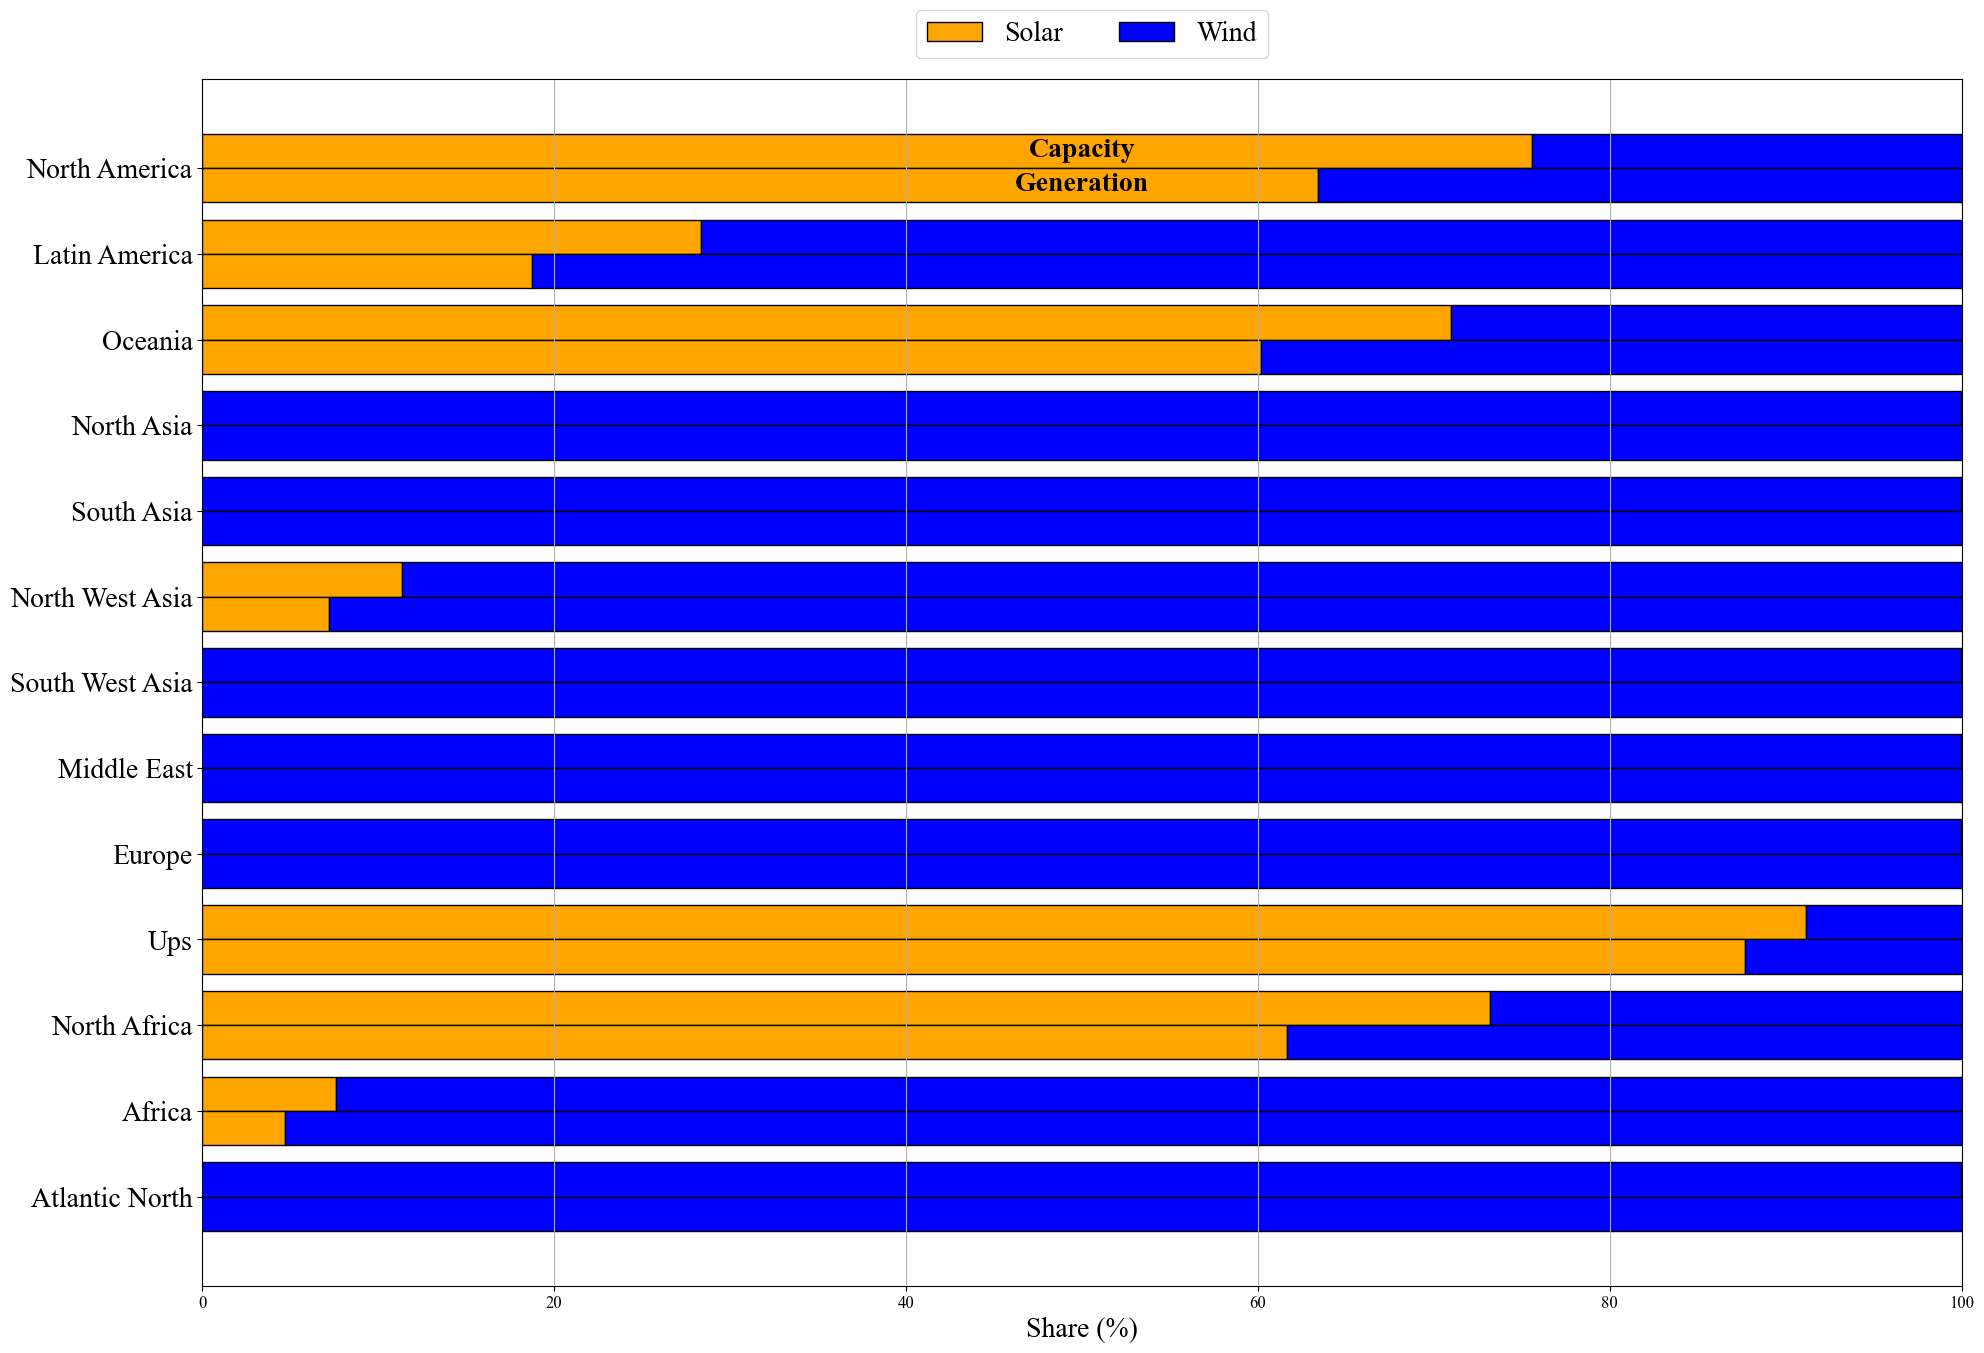

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate shares
regions = []
pv_cap_shares = []
wind_cap_shares = []
pv_gen_shares = []
wind_gen_shares = []

for key, value in regions_dic.items():
    regions.append(key)
    total_cap = value['wind_installed'] + value['pv_installed']
    total_gen = value['total_wind_yearly'] + value['total_pv_yearly']
    pv_cap_share = value['pv_installed'] / total_cap * 100
    wind_cap_share = 100 - pv_cap_share
    pv_gen_share = value['total_pv_yearly'] / total_gen * 100
    wind_gen_share = value['total_wind_yearly'] / total_gen * 100
    pv_cap_shares.append(pv_cap_share)
    wind_cap_shares.append(wind_cap_share)
    pv_gen_shares.append(pv_gen_share)
    wind_gen_shares.append(wind_gen_share)

# Define the number of regions
num_regions = len(regions)

# Create figure and axes
fig, ax = plt.subplots(figsize=(20, num_regions * 1))

# Bar width
bar_width = 0.4

# Plot Capacity shares
y_positions = np.arange(num_regions)
ax.barh(y_positions - bar_width/2, pv_cap_shares, height=bar_width, color='orange', edgecolor='black', label='Solar')
ax.barh(y_positions - bar_width/2, wind_cap_shares, height=bar_width, left=pv_cap_shares, color='blue', edgecolor='black', label='Wind')

# Plot Generation shares
ax.barh(y_positions + bar_width/2, pv_gen_shares, height=bar_width, color='orange', edgecolor='black')
ax.barh(y_positions + bar_width/2, wind_gen_shares, height=bar_width, left=pv_gen_shares, color='blue', edgecolor='black')

# Customizing the plot
formatted_regions = [region.replace('_', ' ').title() for region in regions]
ax.set_yticks(y_positions)
ax.set_yticklabels(formatted_regions, fontsize=20)
ax.set_xlim(0, 100)
ax.set_xlabel('Share (%)', fontsize=20)
ax.invert_yaxis()

# Add text annotations for capacity and generation
for i, (pv_cap, wind_cap, pv_gen, wind_gen) in enumerate(zip(pv_cap_shares, wind_cap_shares, pv_gen_shares, wind_gen_shares)):
    ax.text(50, i - bar_width/2, 'Capacity', ha='center', va='center', color='black', fontweight='bold', fontsize=20)
    ax.text(50, i + bar_width/2, 'Generation', ha='center', va='center', color='black', fontweight='bold', fontsize=20)
    break

# Add gridlines only for the x-axis
ax.grid(True, axis='x')

# Add the legend above the plot
plt.figlegend(loc='upper center', bbox_to_anchor=(0.55, 1.05), ncol=2, fontsize=20)

plt.tight_layout()
plt.show()


## Plotting of monthly regional data

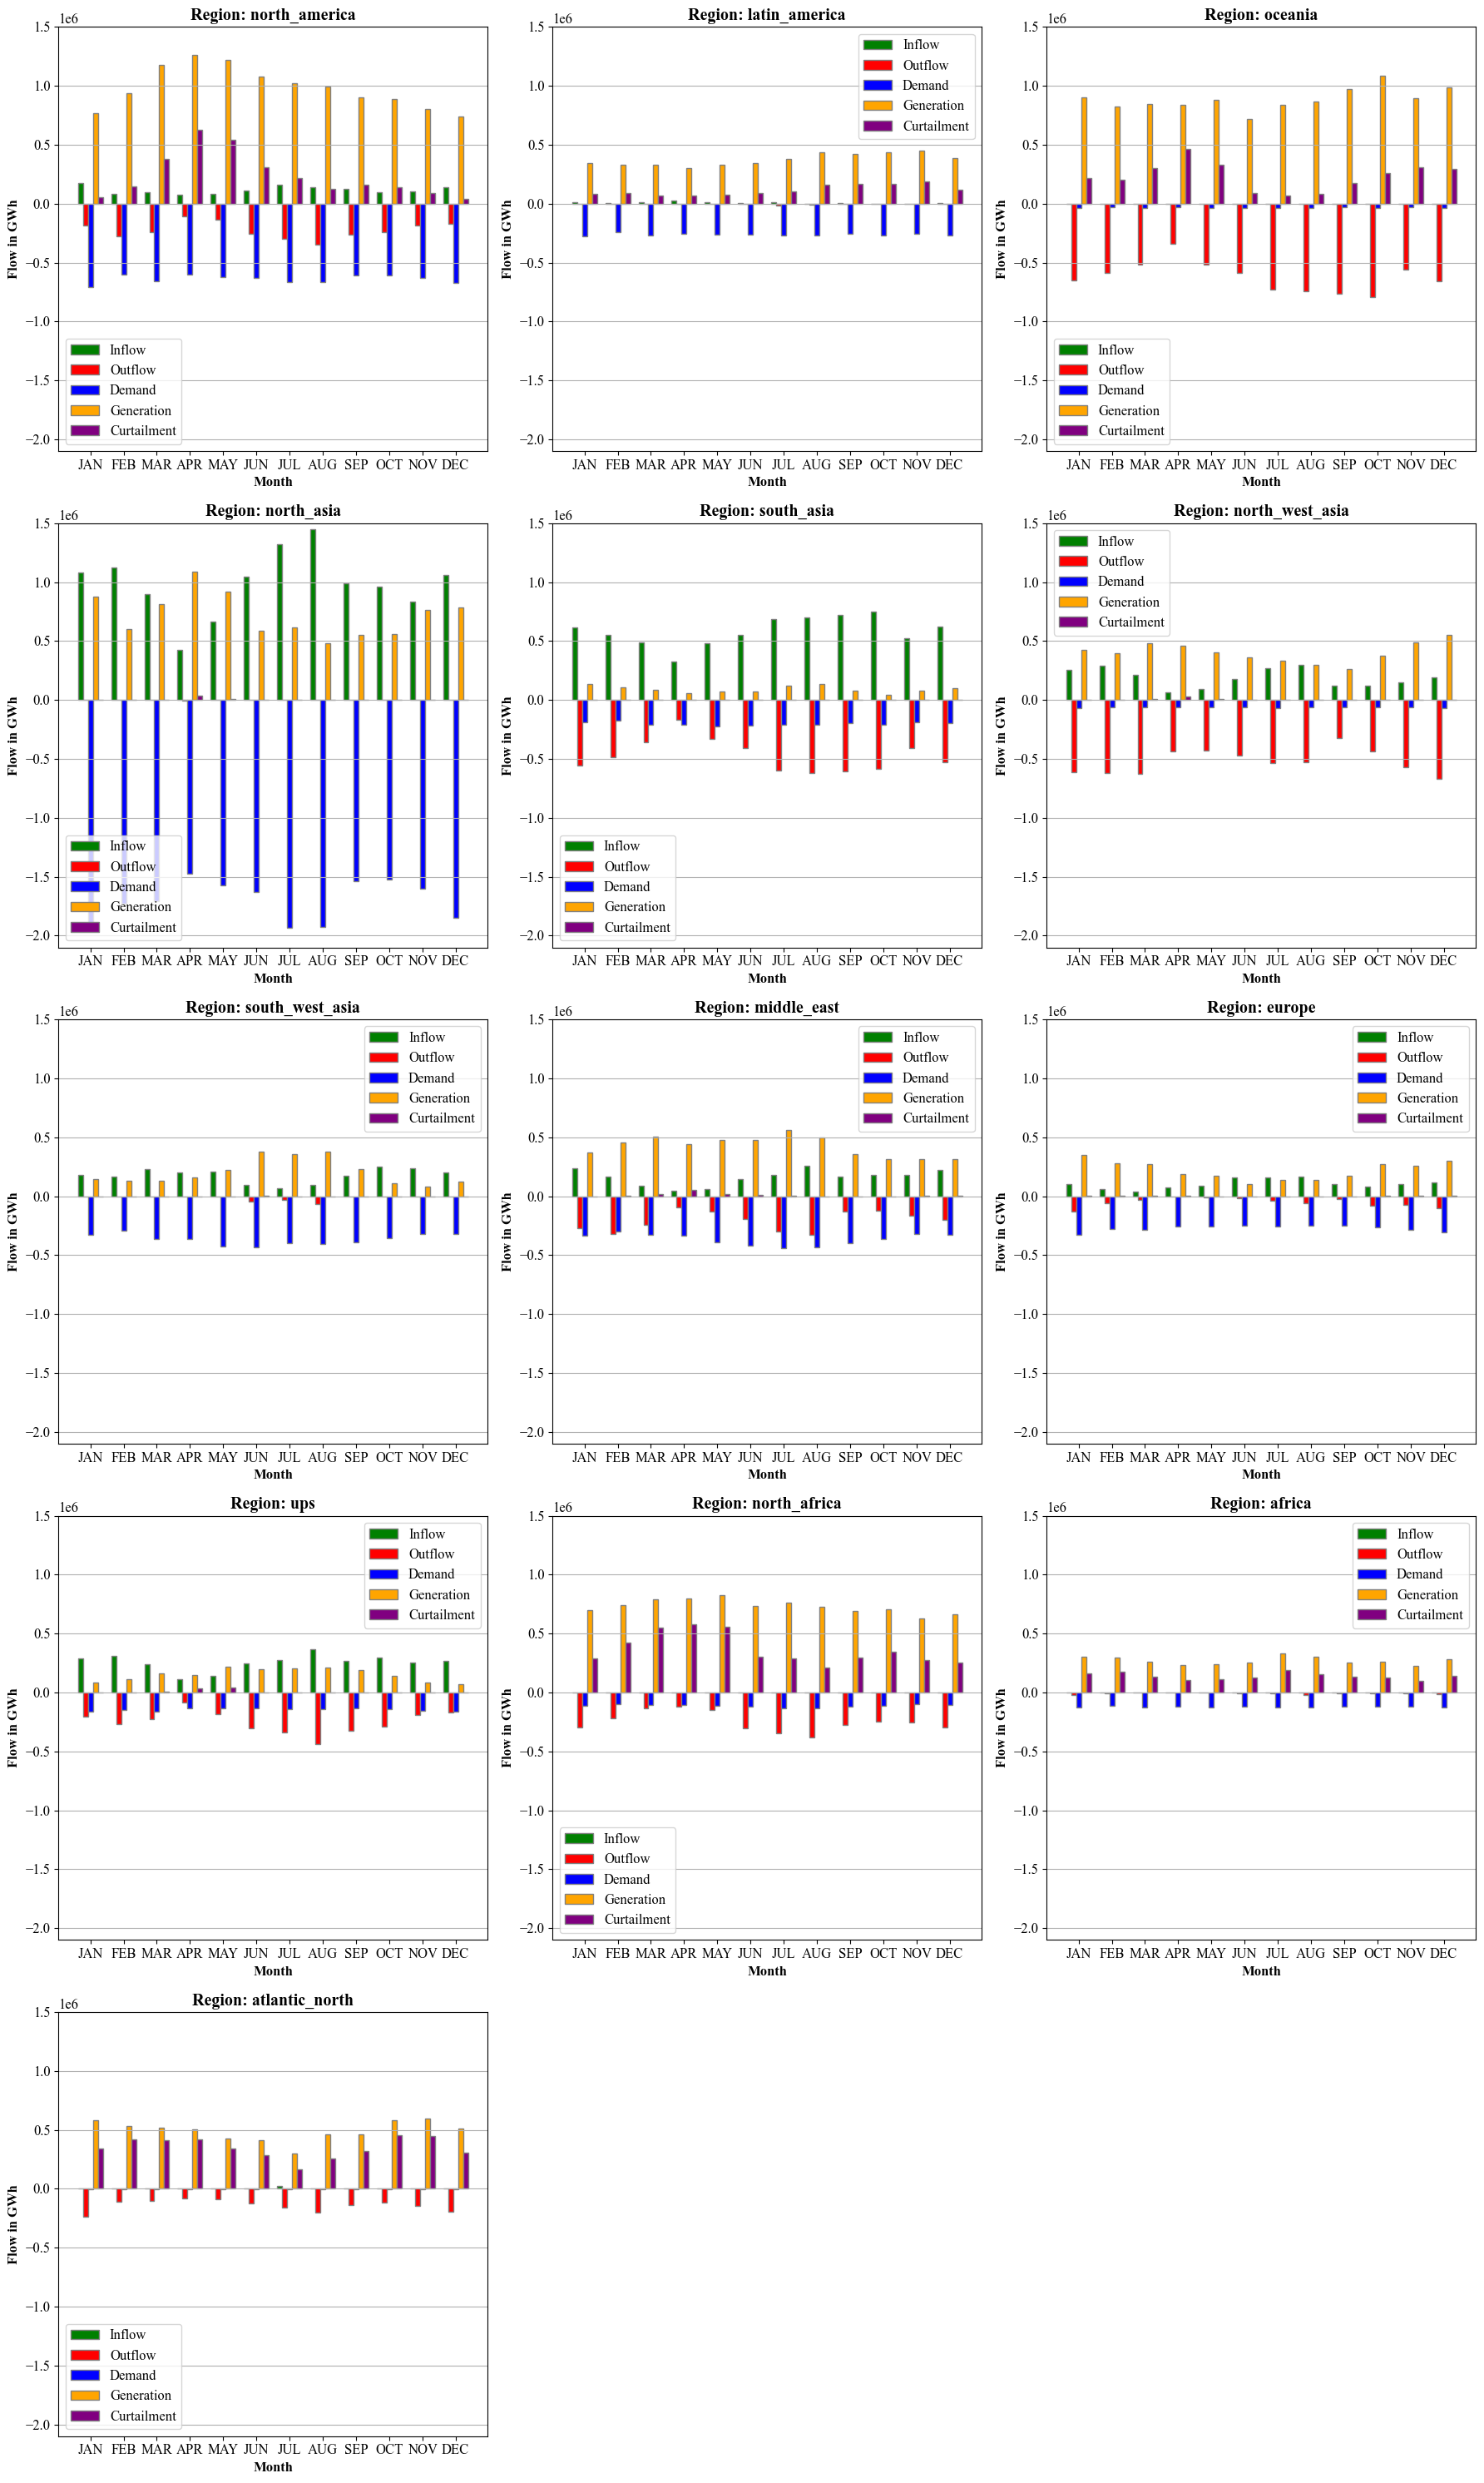

In [ ]:
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_periods = pd.period_range(start='2050-01', periods=12, freq='M')

def plot_region_monthly_data(region_key, region_value, ax):
    inflows = [region_value[f'inflow_{month}'] for month in months]
    outflows = [region_value[f'outflow_{month}'] for month in months]
    loads = [region_value[f'total_load_monthly'].loc[period] for period in month_periods]
    generations = [(region_value[f'total_pv_monthly'].loc[period] + region_value[f'total_wind_monthly'].loc[period]) for period in month_periods]
    curtailments = [region_value[f'total_curtailment_monthly'].loc[period] for period in month_periods]

    bar_width = 0.15
    r1 = range(len(months))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r4]
    ax.grid(False)
    ax.bar(r1, inflows, color='green', width=bar_width, edgecolor='grey', label='Inflow')
    ax.bar(r2, [-outflow for outflow in outflows], color='red', width=bar_width, edgecolor='grey', label='Outflow')
    ax.bar(r3, [-load for load in loads], color='blue', width=bar_width, edgecolor='grey', label='Demand')
    ax.bar(r4, generations, color='orange', width=bar_width, edgecolor='grey', label='Generation')
    ax.bar(r5, curtailments, color='purple', width=bar_width, edgecolor='grey', label='Curtailment')

    ax.set_xlabel('Month', fontweight='bold')
    ax.set_ylabel('Flow in GWh', fontweight='bold')
    ax.set_ylim(-2.1e6, 1.5e6)
    ax.set_title(f'Region: {region_key}', fontweight='bold')
    ax.set_xticks([r + 2*bar_width for r in range(len(months))])
    ax.set_xticklabels(months)
    ax.grid(True, axis='y')
    ax.legend()

num_plots = len(regions_dic)
rows = (num_plots + 2) // 3

fig, axs = plt.subplots(rows, 3, figsize=(18, 6 * rows))
axs = axs.flatten()

for idx, (region_key, region_value) in enumerate(regions_dic.items()):
    plot_region_monthly_data(region_key, region_value, axs[idx])

for idx in range(len(regions_dic), len(axs)):
    fig.delaxes(axs[idx])

plt.tight_layout()
plt.show()


## Weekly plot

<built-in function len>


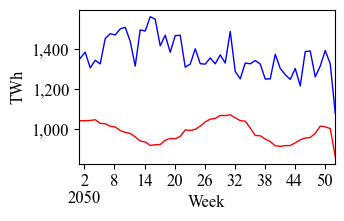

In [ ]:
# Group by week and sum the values
total_weekly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('W')).sum() * 1e-6
total_weekly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('W')).sum() * 1e-6
total_weekly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('W')).sum() * 1e-6
# Remove the first entry
total_weekly_gen = total_weekly_gen.iloc[1:]
total_weekly_load = total_weekly_load.iloc[1:]
total_weekly_cur = total_weekly_cur.iloc[1:]
# Extract the week numbers and values
weeks = total_weekly_gen.index.to_timestamp()  # Convert period index to timestamp for plotting
values_gen = total_weekly_gen.values
values_load = total_weekly_load.values
values_cur = total_weekly_cur.values
print(len)
total_weekly_gen.to_csv('weekly_gen_trans.csv')
# Plotting
plt.figure(figsize=(3.3, 2))

# Plot load on top
plt.plot(weeks, values_gen, label='Generation', linestyle='-', color='blue', linewidth=1)
plt.plot(weeks, values_load, label='Demand', linestyle='-', color='red', linewidth=1)
plt.xlabel('Week', fontsize=12)
plt.ylabel('TWh', fontsize=12)
plt.xlim(pd.Timestamp('2050-01-01'), pd.Timestamp('2050-12-25'))
plt.gca().annotate('2050', xy=(0.02, -0.23), xycoords='axes fraction', ha='center', va='center')
#plt.legend(bbox_to_anchor=(0, 0.1), loc='lower left', frameon=False)  # Add a legend to the plot

# Create a range of weeks
all_weeks = pd.date_range(start=weeks[0], periods=52, freq='W')

# Customize x-axis ticks to show every 4th week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%-U'))  # Remove leading zeros
plt.xticks(all_weeks[::6], fontsize=12)
ax = plt.gca()
def format_func(value, tick_number):
    return f'{value:,.0f}'

formatter = FuncFormatter(format_func)
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/weekly-gen-demand-line-plot.svg', format='svg')

# Show the plot
plt.show()

## Tornado plot of annual regional data

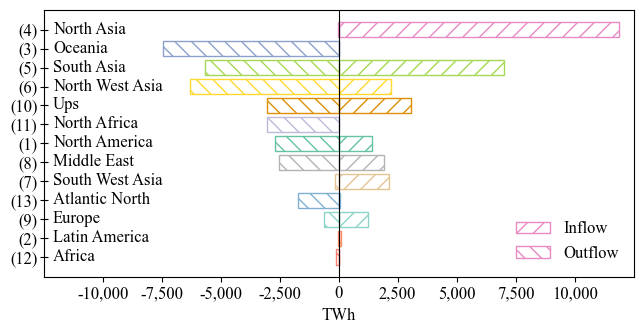

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

# Data preparation
inflow_outflow_data = [
    (region_key, region_value['inflow'], region_value['outflow'])
    for region_key, region_value in regions_dic.items()
]
inflow_outflow_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

regions_inflow_outflow = [item[0] for item in inflow_outflow_data]
inflows = [item[1] * 1e-3 for item in inflow_outflow_data]  # TWh
outflows = [item[2] * 1e-3 for item in inflow_outflow_data]  # TWh

# Plotting the data
fig, ax = plt.subplots(figsize=(6.6, 3.5))

for i, region in enumerate(regions_inflow_outflow):
    inflow_color = region_colors[region]
    region_name = f'({regions_dic[region]["bus"]})'
    ax.barh(region_name, inflows[i], color='none', hatch='//', edgecolor=inflow_color, label='Inflow' if i == 0 else "")
    ax.barh(region_name, -outflows[i], color='none', hatch='\\\\', edgecolor=inflow_color, label='Outflow' if i == 0 else "")
    ax.annotate(f'{region.replace('_', ' ').title()}', xy=(-12.1e3, i), 
                xycoords='data', ha='left', va='center', fontsize=12, color='black')

ax.axvline(x=0, color='black', linewidth=0.8)
ax.grid(False)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))
ax.set_xlabel('TWh')
ax.set_xlim(-1.25e4, 1.25e4)
ax.set_xticks([ -1e4, -7.5e3, -5e3, -2.5e3, 0, 2.5e3, 5e3, 7.5e3, 10e3])
ax.legend(frameon=False, loc= 'lower right')
ax.invert_yaxis()
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")
ax.yaxis.set_ticks_position('left')

# Set y-tick labels to the right of the left axis but align them to the left
for tick_label in ax.get_yticklabels():
    tick_label.set_ha('right')  # Align horizontally to the right
    tick_label.set_position((0.005, tick_label.get_position()[1]))  # Offset the position to the right of the axis

for tick_label, region in zip(ax.get_yticklabels(), regions_inflow_outflow):
    pass
    #tick_label.set_color(region_colors[region.lower().replace(' ', '_')])

ax.tick_params(axis='y', which='both', direction='inout', length=6)
fig.canvas.draw()
plt.tight_layout()
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/tornado-plot-inflows-outflows_black.svg', format='svg')

plt.show()


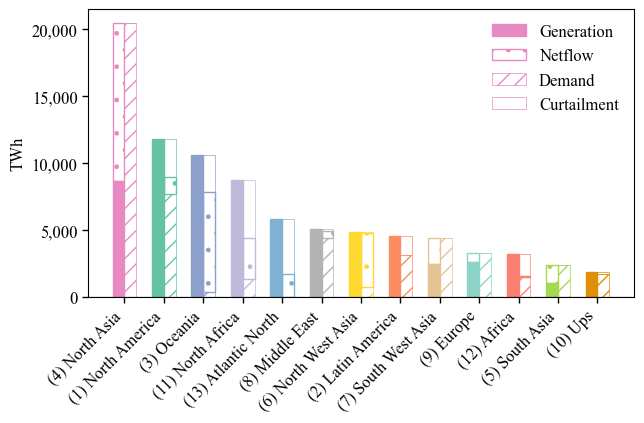

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})
# Data preparation (as given)
data = [
    (region_key.replace('_', ' ').title(), region_value['total_wind_yearly'] + region_value['total_pv_yearly'], region_value['total_curtailment_yearly'], region_value['total_load_yearly'], region_value['inflow'], region_value['outflow'])
    for region_key, region_value in regions_dic.items()
]
data.sort(key=lambda x: max(x[1], x[2], x[3]), reverse=True)
regions = [item[0] for item in data] 
generations = [item[1] * 1e-3 for item in data] # TWh
curtailments = [item[2] * 1e-3 for item in data] # TWh
demands = [item[3] * 1e-3 for item in data] # TWh
netflows = [item[4] * 1e-3 - item[5] * 1e-3 for item in data] # TWh
# Plotting
fig, ax = plt.subplots(figsize=(6.6, 4.4))

# Bar chart for Generation and Curtailment by Region
bar_width = 0.3
x = range(len(regions))

hatch_patterns = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']  # Define different hatching patterns

for i, region in enumerate(regions):
    color = region_colors[region.lower().replace(' ', '_')]  # Get the color for the region from region_colors
    
    ax.bar(x[i], generations[i], bar_width, label='Generation' if i == 0 else "", color=color, edgecolor=color, align='center')
    ax.bar(x[i] if netflows[i] > 0 else x[i] + bar_width, abs(netflows[i]), bar_width,bottom=generations[i] if netflows[i] > 0 else demands[i], label='Netflow' if i == 0 else "", color='none', hatch='.', edgecolor=color,align='center')
    ax.bar(x[i] + bar_width, demands[i], bar_width, label='Demand' if i == 0 else "", color='none', edgecolor=color,hatch='//',  align='center', linewidth=0.5)
    ax.bar(x[i] + bar_width, curtailments[i], bar_width, bottom=abs(netflows[i])+demands[i] if netflows[i] < 0 else demands[i], label='Curtailment' if i == 0 else "", color='none', edgecolor=color, align='center', linewidth=0.5)
    
region_labels = [f'({regions_dic[item.lower().replace(' ', '_')]['bus']}) {item}' for i, item in enumerate(regions)] # Set x-ticks and labels
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(region_labels, rotation=45, ha='right', fontsize=12)
ax.axhline(y=0, color='black', linewidth=0.8)
ax.set_ylabel('TWh', fontsize=12)
ax.grid(False)
ax = plt.gca()
formatter = ScalarFormatter(useMathText=False)
formatter.set_powerlimits((0, 0))  # Change the threshold for scientific notation
def format_func(value, tick_number):
    return f'{value:,.0f}'

formatter = FuncFormatter(format_func)
plt.gca().yaxis.set_major_formatter(formatter)
# Adjust the legend to show labels only once
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=False)
ax.yaxis.offsetText.set_fontsize(12)
ax.tick_params(axis='both', which='both', bottom=True, top=False, direction='out', length=4, width=1, color='black')
# Adjust layout
plt.tight_layout()
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/bar-chart-gen-netflow-demand-cur.svg', format='svg')
plt.show()


## **Radar charts**

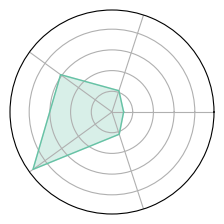

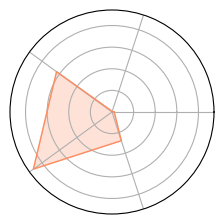

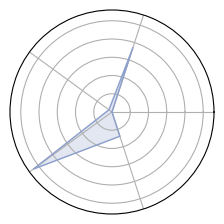

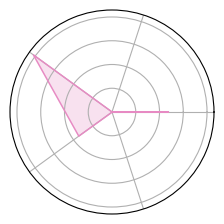

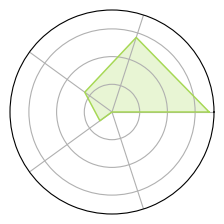

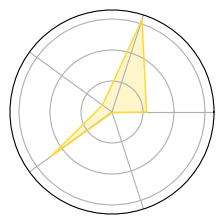

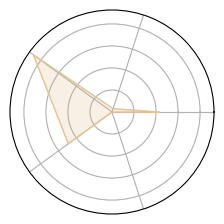

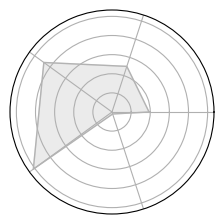

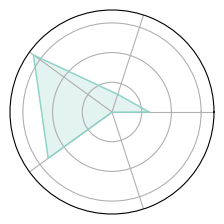

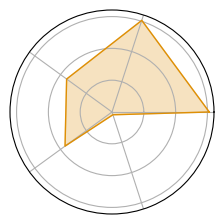

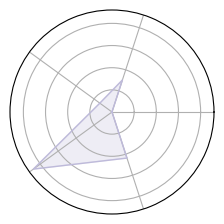

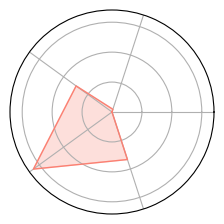

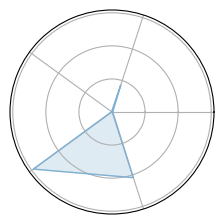

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# Data preparation (as given)
data = {
    region_key: [
        region_value['inflow'],  # Normalize to generation
        region_value['outflow'],  # Normalize to generation
        (region_value['total_load_yearly']),  # Normalize to generation
        (region_value['total_wind_yearly'] + region_value['total_pv_yearly']),  # Generation normalized to itself
        region_value['total_curtailment_yearly']  # Normalize to generation
    ]
    for region_key, region_value in regions_dic.items()
}

variables = ['Inflow', 'Outflow', 'Demand', 'Generation', 'Curtailment']
df = pd.DataFrame(data, index=variables)

def plot_radar_chart(region):
    num_vars = len(variables)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]
    values = df[region].tolist()
    values += values[:1]
    fig, ax = plt.subplots(figsize=(2.5, 2.5), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=1, linestyle='solid', color=region_colors[region])
    ax.fill(angles, values, color=region_colors[region], alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    formatted_title = format_title(region)
    #ax.set_title(formatted_title, size=12, color='black', y=1.1)
    ax.spines['polar'].set_visible(True)

    # if values[0] > 4/3*values[1]:
    #     ax.spines['polar'].set_edgecolor('red')  # net importer
    # elif values[0]*4/3 < values[1]:
    #     ax.spines['polar'].set_edgecolor('green') # net exporter
    # else:
    #     ax.spines['polar'].set_edgecolor('grey') # transmission nodes


    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/radar-chart-{region}.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()


def format_title(title):
    return ' '.join(word.capitalize() for word in title.split('_'))

def plot_all_radar_charts():
    for region in df.columns:
        plot_radar_chart(region)

plot_all_radar_charts()


## Chord diagram of netflows 

## Demand and supply graphs of each regions

north_america


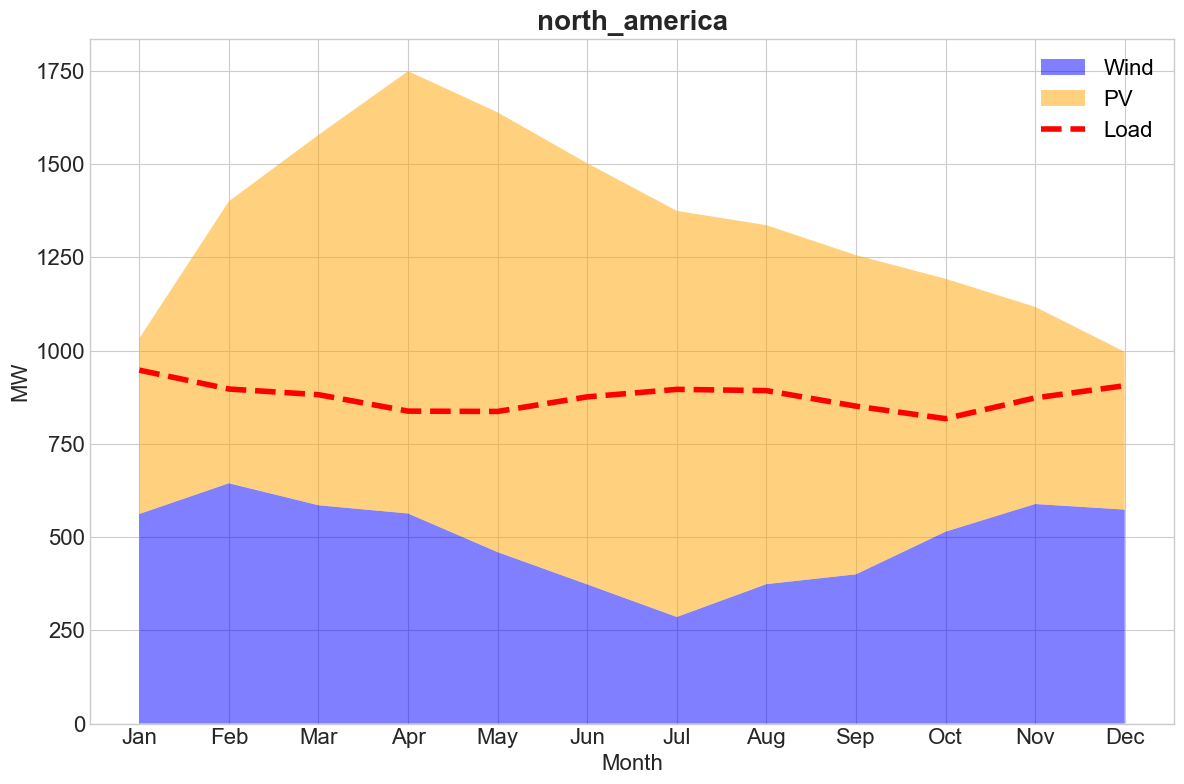

latin_america


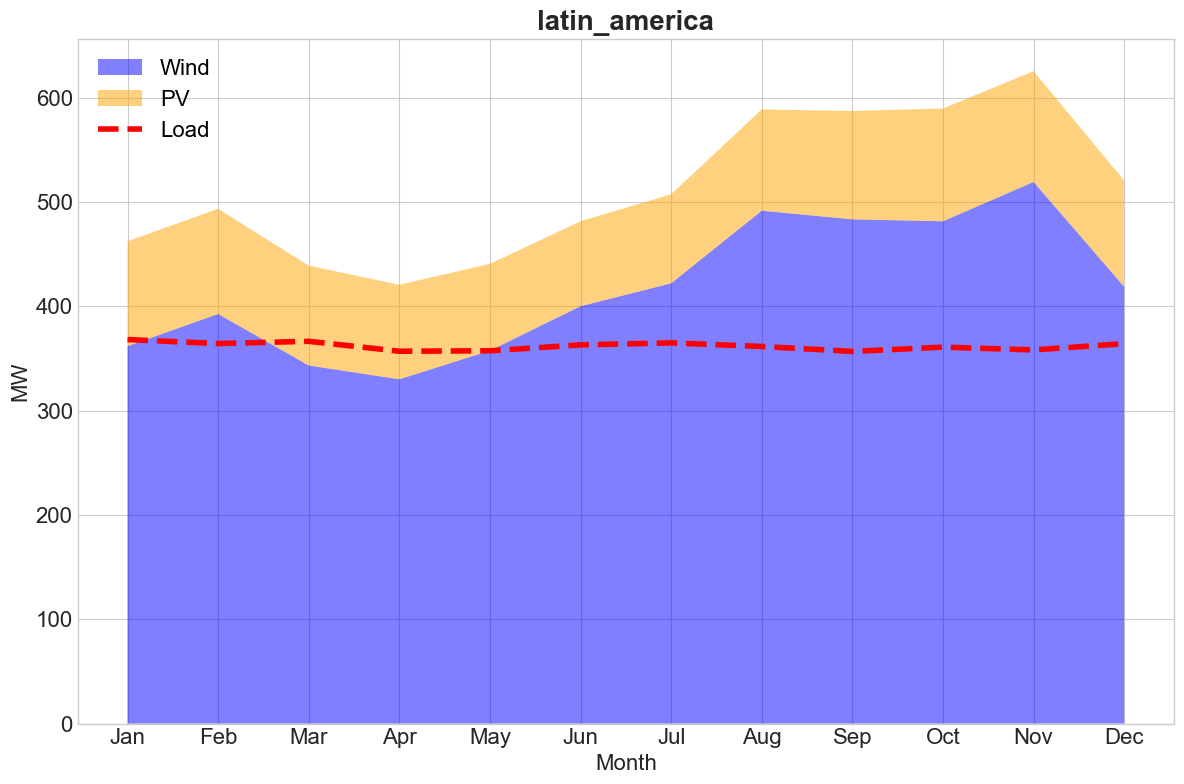

oceania


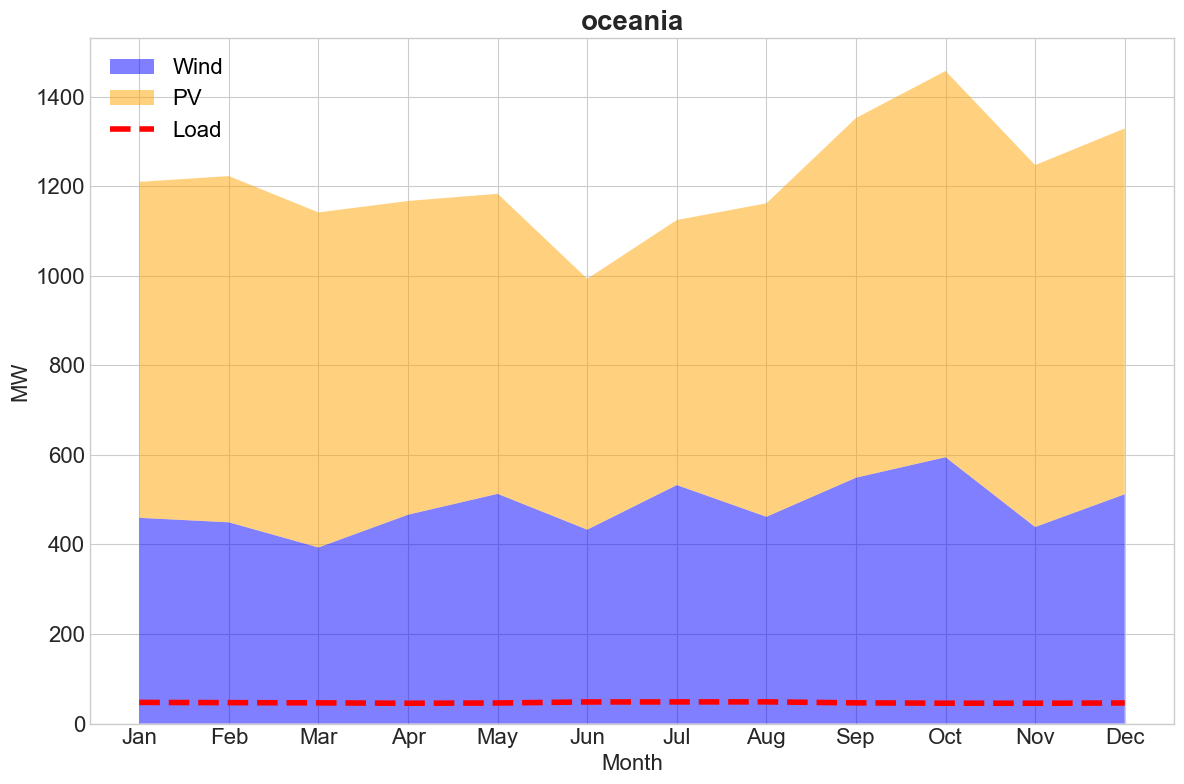

north_asia


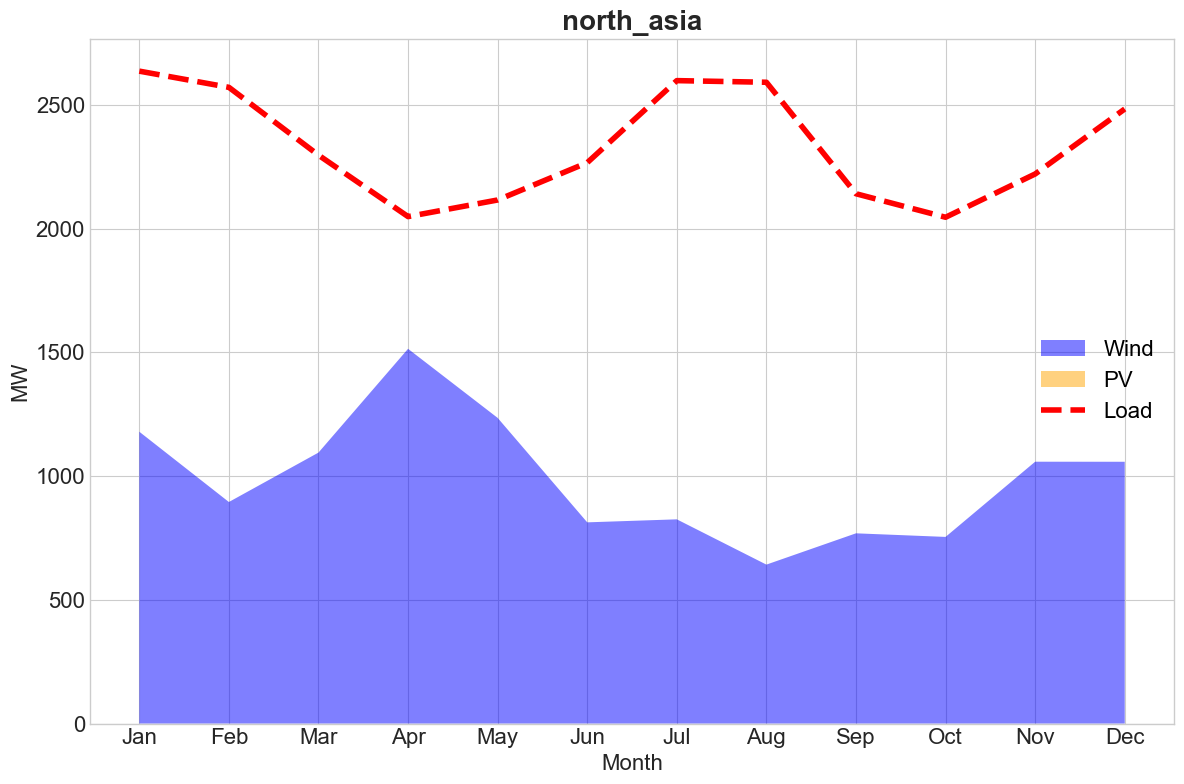

south_asia


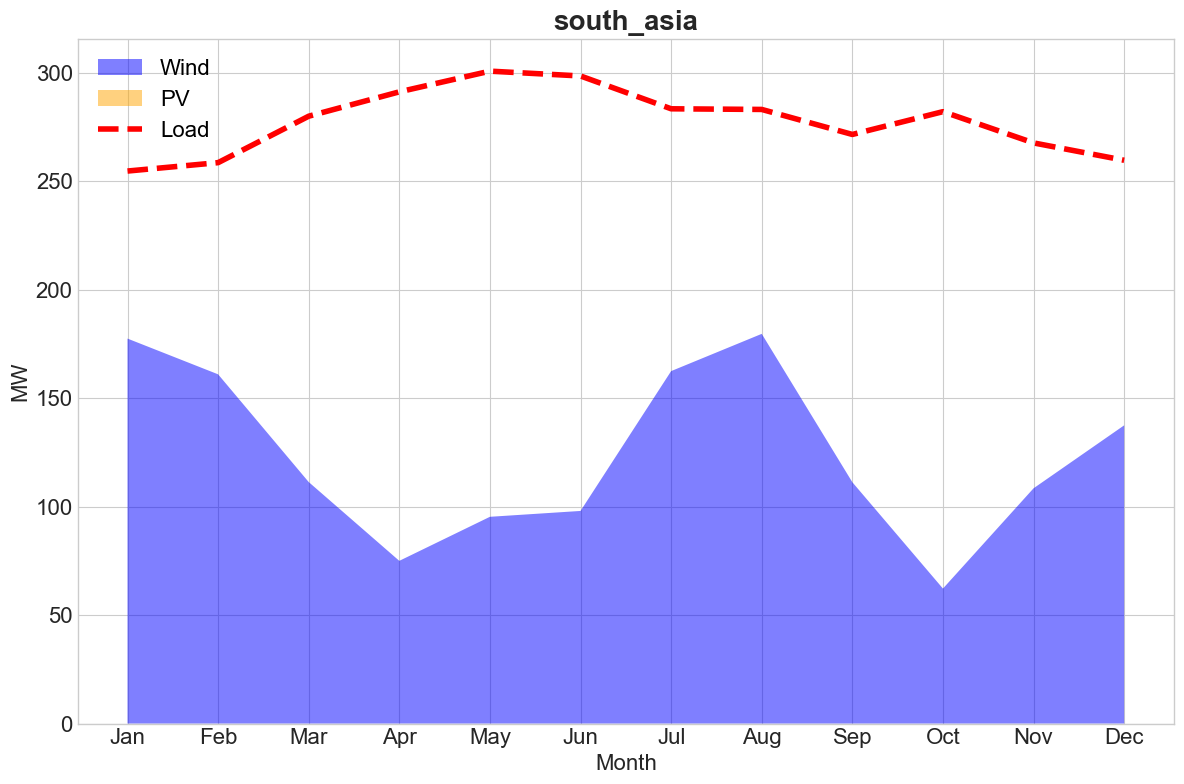

north_west_asia


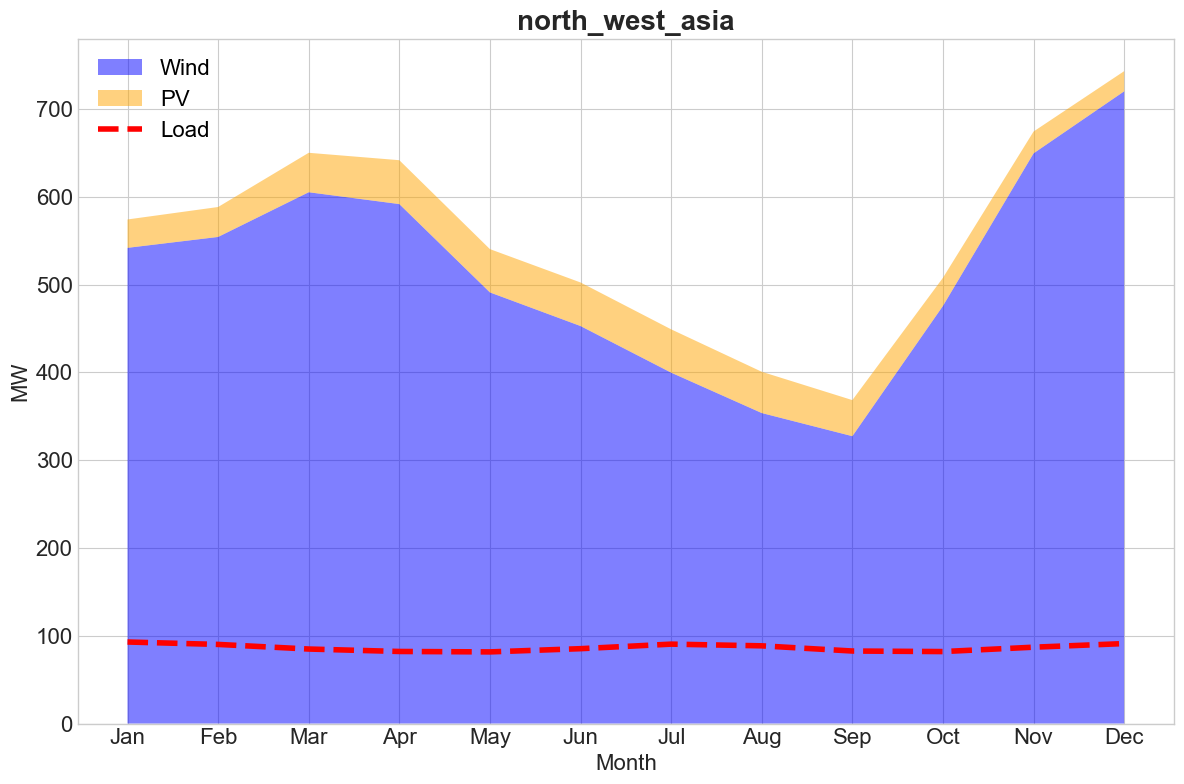

south_west_asia


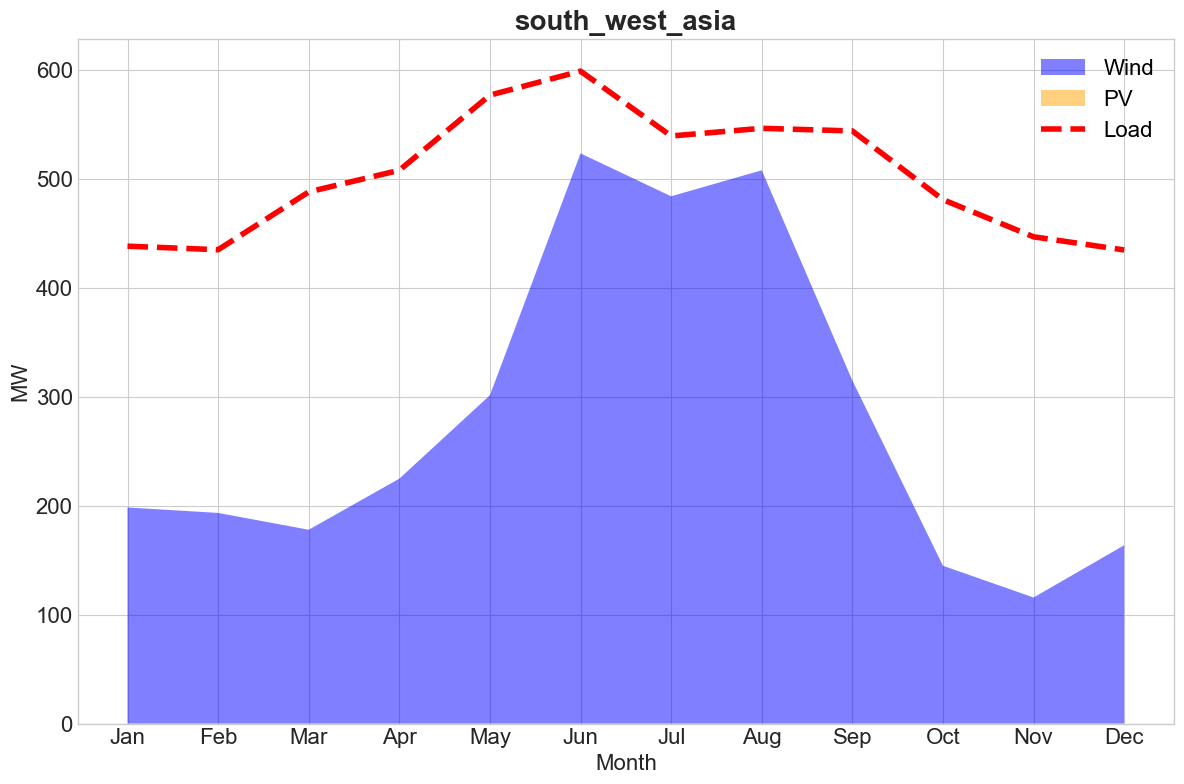

middle_east


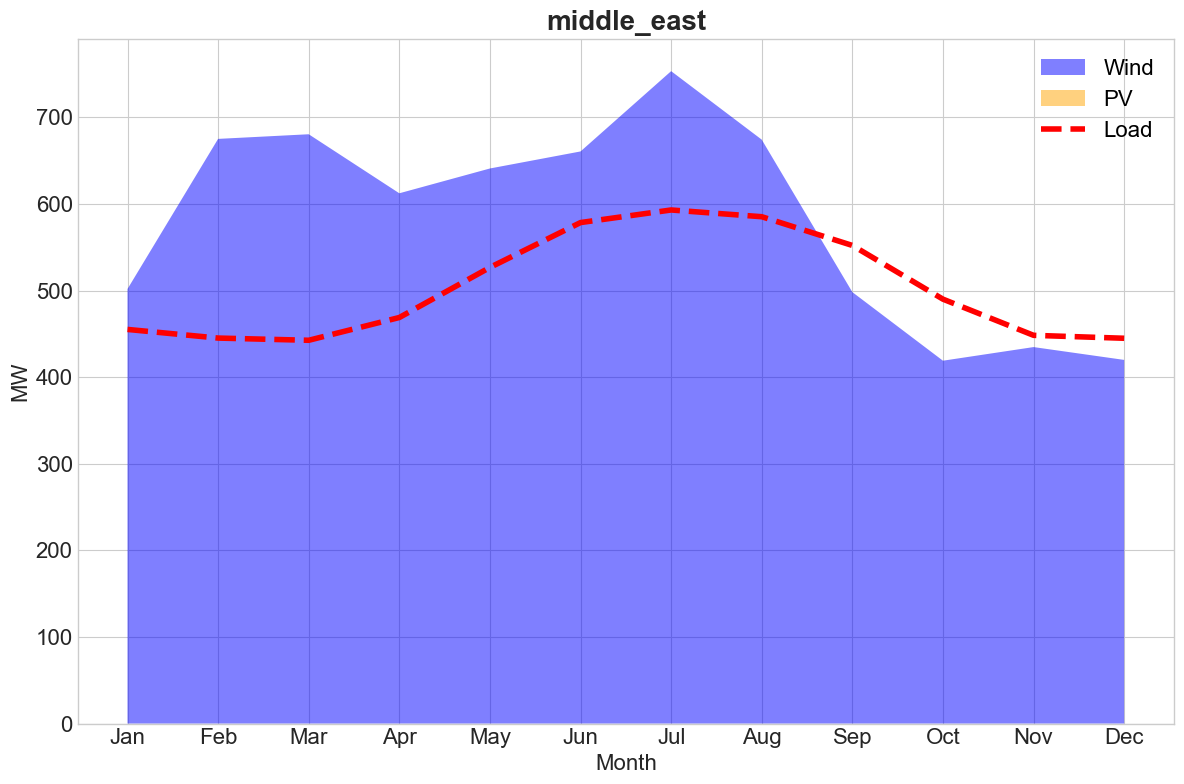

europe


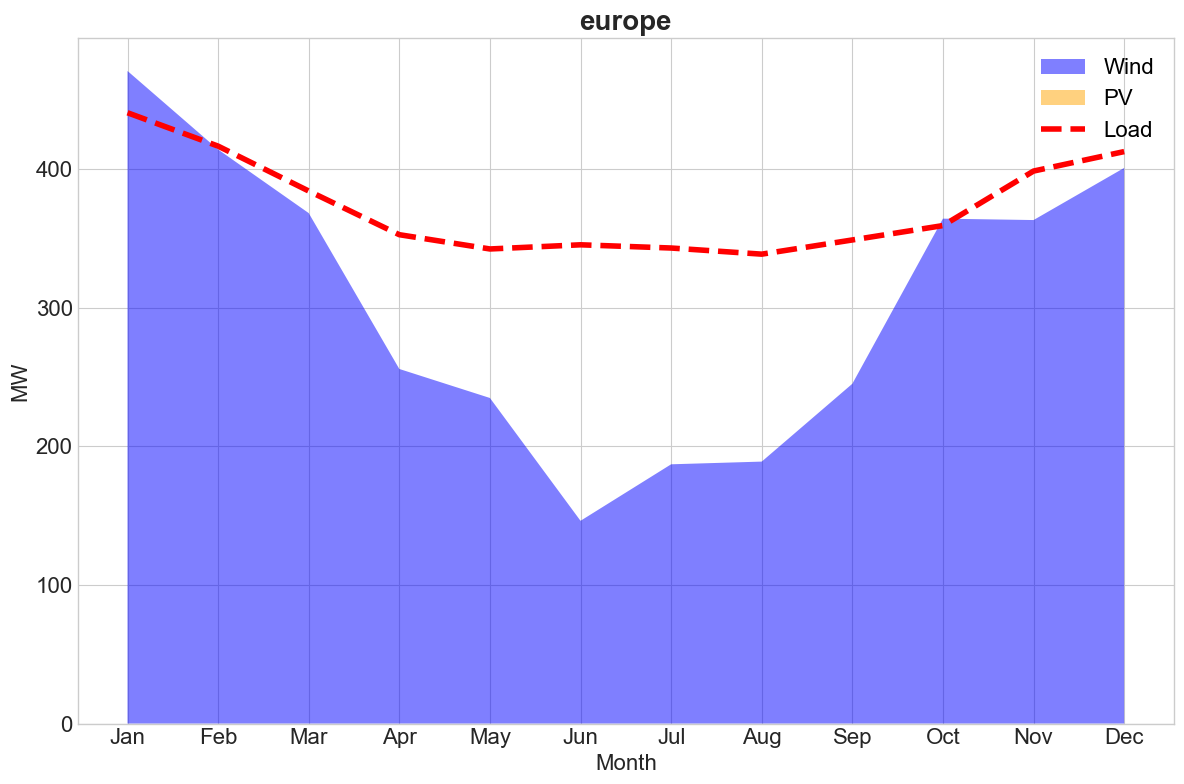

ups


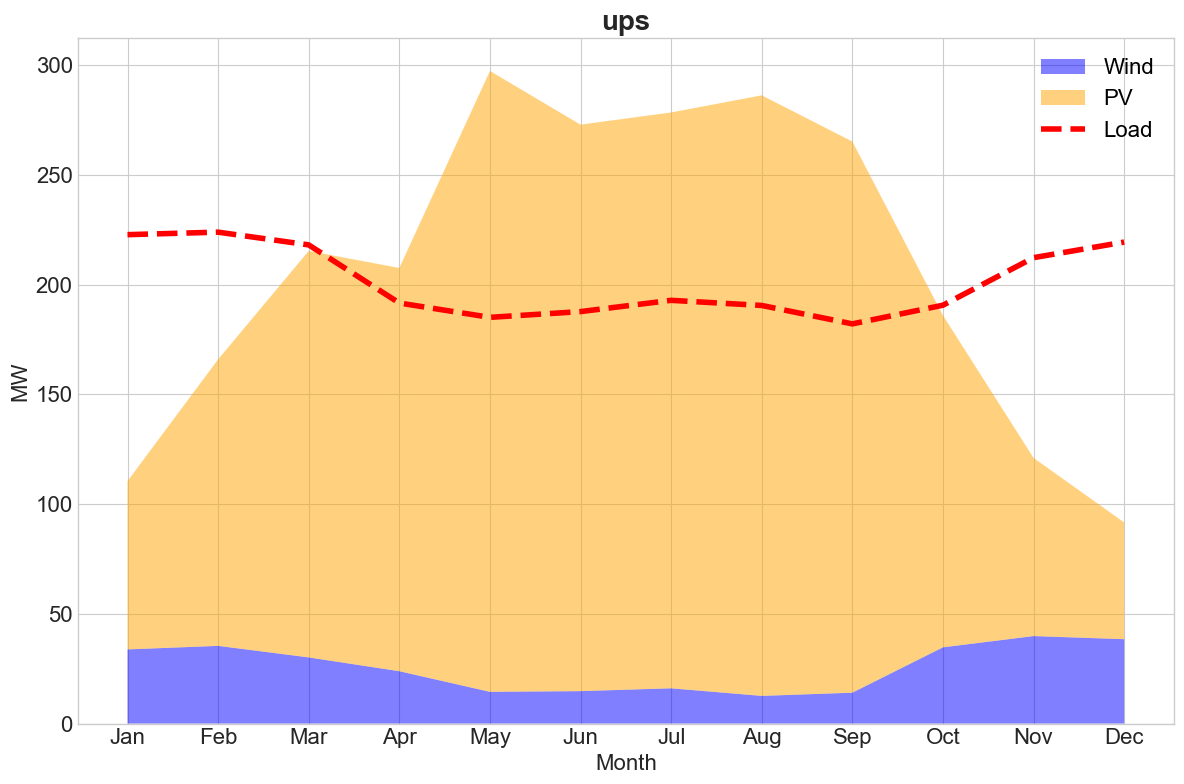

north_africa


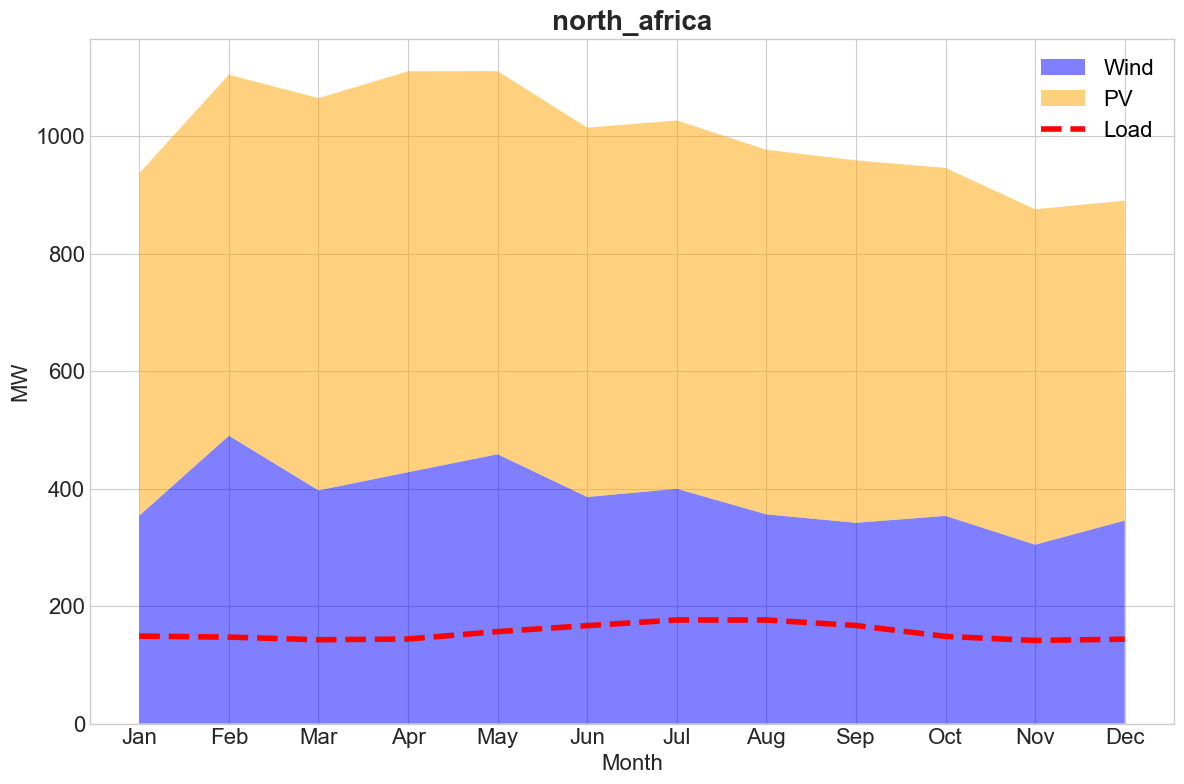

africa


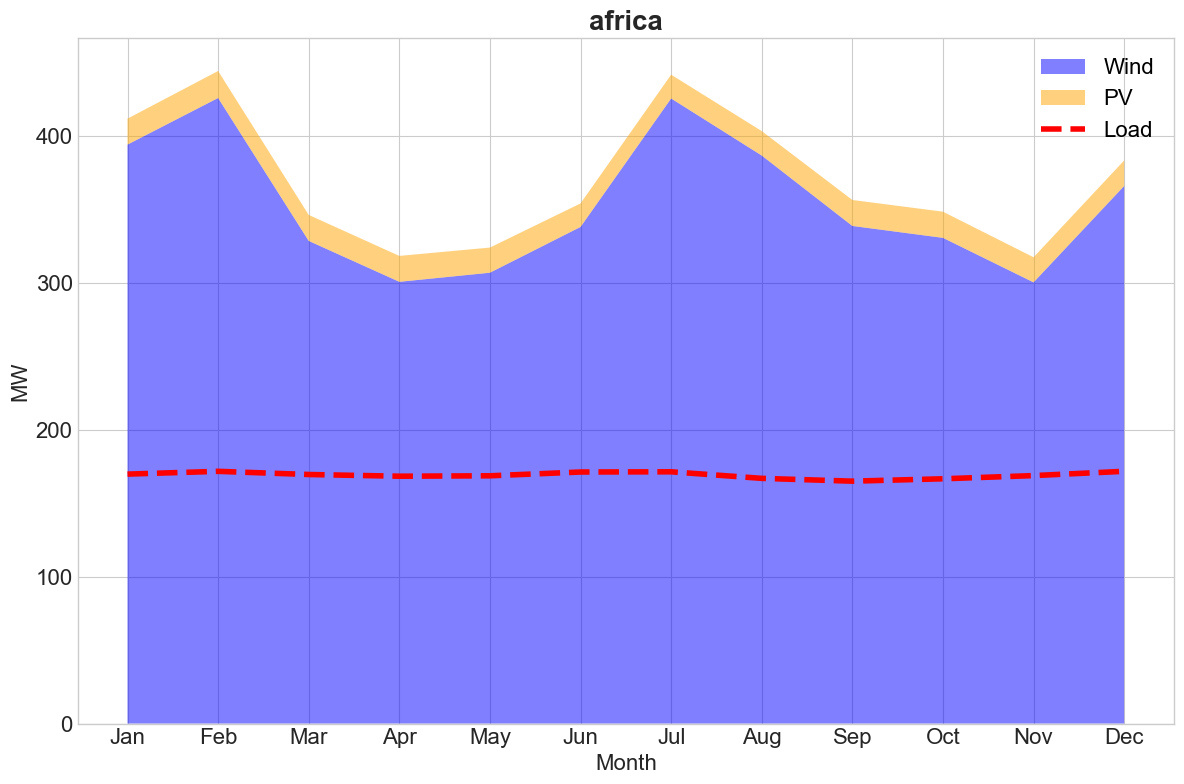

atlantic_north


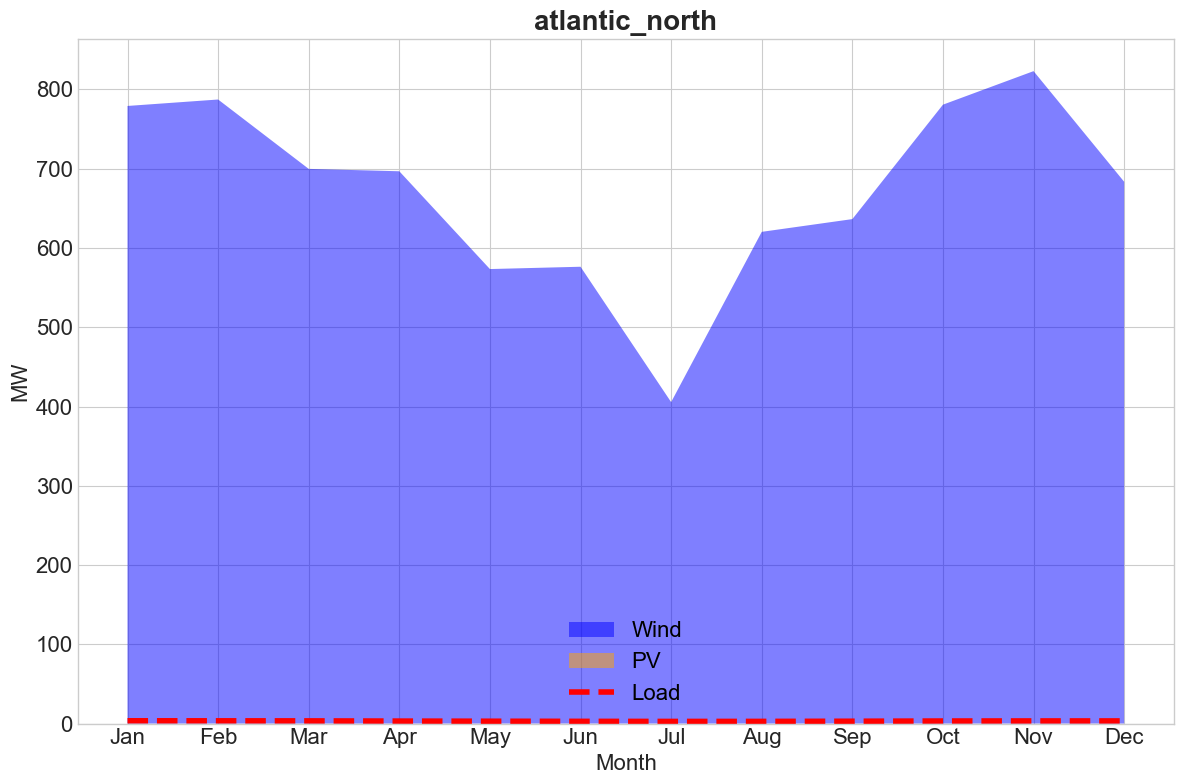

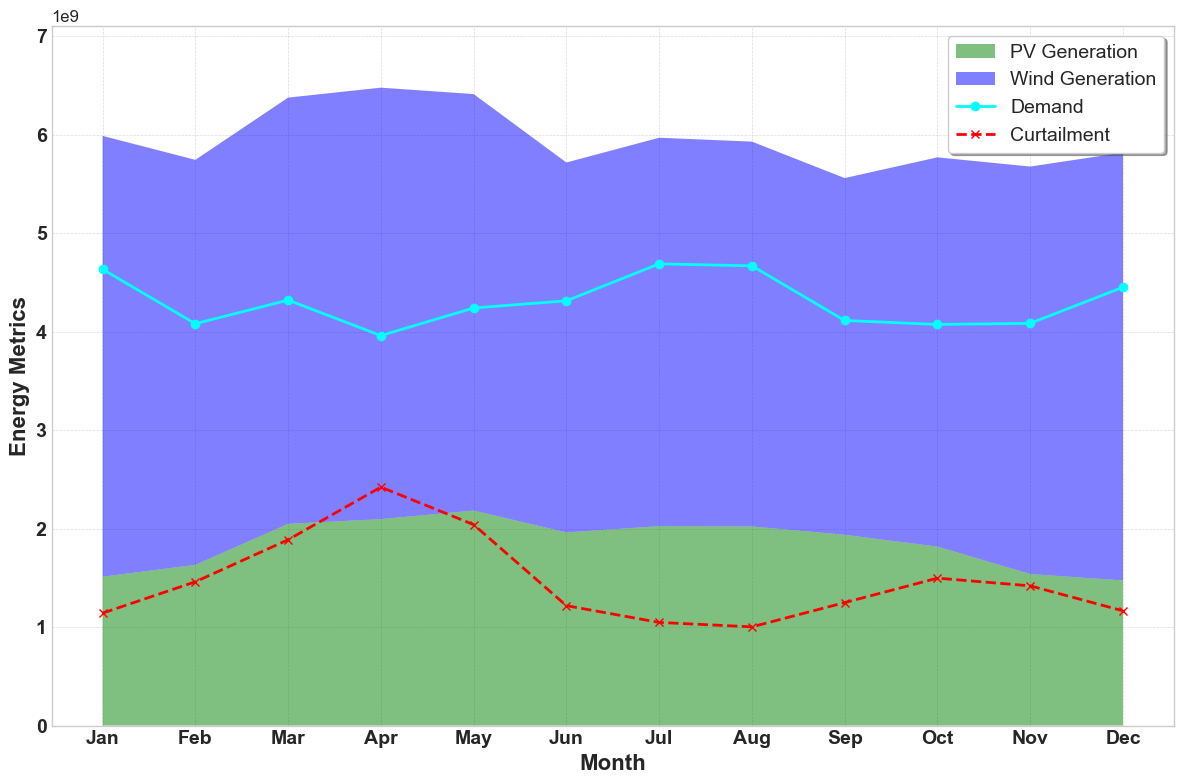

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')  

for key, value in regions_dic.items():
    print(key)
    # series_l = value["load"]
    # load = series_l.groupby(series_l.index.to_period('M')).sum()
    load = value['mean_load_monthly']
    wind = value["mean_wind_monthly"]
    pv = value["mean_pv_monthly"]

    # Extract values and months
    months = load.index.month
    load_values = load.values
    wind_values = wind.values
    pv_values = pv.values

    plt.figure(figsize=(12, 8))
    
    # # Stacked area plot for wind and PV
    plt.stackplot(months, wind_values, pv_values, labels=['Wind', 'PV'], colors=['blue', 'orange'], alpha=0.5)
    
    # Plot load on top
    plt.plot(months, load_values, label='Load', linestyle='--', color='red', linewidth=4)
    
    plt.title(f'{key}', fontsize=20, fontweight='bold')
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('MW', fontsize=16)
    legend = plt.legend(loc='best', fontsize=16)
    for text in legend.get_texts():
        text.set_color('black')  # Set legend text color to black
        #text.set_fontweight('bold')  # Make legend text bold
    # Customize ticks
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
    plt.yticks(fontsize=16)
    # Tight layout to ensure everything fits without overlapping
    plt.tight_layout()
    
    
    # Show the plot
    plt.show()

plt.figure(figsize=(12, 8))  # Increase figure size for better readability
# Plot line plots for Demand and Curtailment
# Plot stackplot for PV and wind generation
plt.stackplot(total_monthly_pv.index.month, total_monthly_pv.values, total_monthly_wind.values, labels=['PV Generation', 'Wind Generation'], colors=['green', 'blue'], alpha=0.5)
plt.plot(total_monthly_pv.index.month, total_monthly_load, label='Demand', color='cyan', linewidth=2, linestyle='-', marker='o')
plt.plot(total_monthly_pv.index.month, total_monthly_cur, label='Curtailment', color='red', linewidth=2, linestyle='--', marker='x')
plt.xlabel('Month', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('Energy Metrics', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.ylim(0, 7.1e9)
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability

plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14, fontweight='bold')  # Increase x-tick font size and labels
plt.yticks(fontsize=14, fontweight='bold')  # Increase y-tick font size

plt.tight_layout()  # Adjust layout to fit elements better
plt.show()

## **Stochastic analysis**

[]

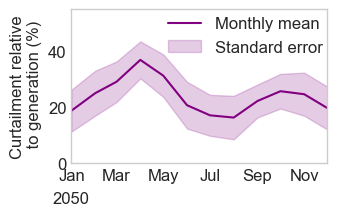

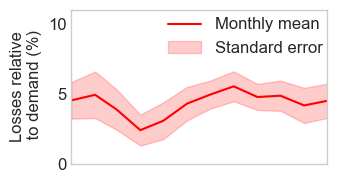

In [ ]:
month_index = monthly_cur_rel_to_gen.index.to_timestamp()
mean_rel_cur_month = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.to_period('M')).mean() * 100
std_rel_cur_month = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.to_period('M')).std() * 100
mean_rel_losses_month = hourly_losses_rel_to_load.groupby(hourly_losses_rel_to_load.index.to_period('M')).mean() * 100
std_rel_losses_month = hourly_losses_rel_to_load.groupby(hourly_losses_rel_to_load.index.to_period('M')).std() * 100


plt.figure(figsize=(3.3, 2))
plt.plot(month_index, mean_rel_cur_month.values, label='Monthly mean', color='purple', linestyle='-', linewidth=1.5)
plt.fill_between(month_index, mean_rel_cur_month - std_rel_cur_month, mean_rel_cur_month + std_rel_cur_month, color='purple', alpha=0.2, label='Standard error')
plt.grid(False)
plt.gca().annotate('2050', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')
xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
          pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))
plt.ylabel('Curtailment relative\n to generation (%)')
plt.ylim(0,55)
plt.legend(frameon=False,bbox_to_anchor = [1.04, 1.05], loc='upper right')

plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/monthly-relative-curtailment.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.plot()
plt.figure(figsize=(3.3, 2))
plt.plot(month_index,mean_rel_losses_month.values, label='Monthly mean', color='red', linewidth=1.5)
plt.fill_between(month_index, mean_rel_losses_month - std_rel_losses_month, mean_rel_losses_month + std_rel_losses_month, color='red', alpha=0.2, label='Standard error')
#plt.gca().annotate('2050', xy=(0, -0.23), xycoords='axes fraction', ha='center', va='center')
xticks = [pd.Timestamp('2050-01-01'), pd.Timestamp('2050-03-01'), pd.Timestamp('2050-05-01'), 
          pd.Timestamp('2050-07-01'), pd.Timestamp('2050-09-01'), pd.Timestamp('2050-11-01')]
xtick_labels = ['Jan', 'Mar', 'May', 'Jul', 'Sep', 'Nov']
#plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xticks([])
plt.xlim(pd.Timestamp('2050-01'), pd.Timestamp('2050-12'))
plt.grid(False)
plt.xlabel('')
plt.ylim(0,11)
plt.ylabel('Losses relative\n to demand (%)')
plt.legend(frameon=False, bbox_to_anchor = [1.04, 1.05], loc='upper right')
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/monthly-relative-losses.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.plot()


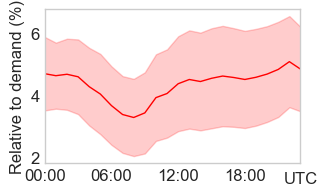

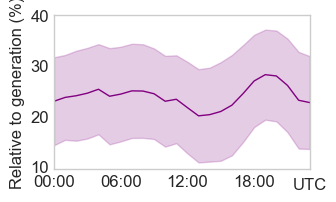

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming hourly_losses_rel_to_load and hourly_cur_rel_to_gen are defined

# Hourly losses
hourly_stats_losses = hourly_losses_rel_to_load.groupby(hourly_losses_rel_to_load.index.hour)
hourly_means_losses = hourly_stats_losses.mean() * 100
hourly_stds_losses = hourly_stats_losses.std() * 100

# Plotting
plt.figure(figsize=(3.3, 2))
plt.plot(hourly_means_losses.index, hourly_means_losses, label='Average Hourly Losses', color='red', linewidth=1)
plt.fill_between(hourly_means_losses.index, hourly_means_losses - hourly_stds_losses, hourly_means_losses + hourly_stds_losses, color='red', alpha=0.2, label='Standard error')
plt.ylabel('Relative to demand (%)')
plt.xticks([0, 6, 12, 18], ['00:00', '06:00', '12:00', '18:00'])
plt.xlim(0, 23)
plt.grid(False)
plt.gca().annotate('UTC', xy=(1, -0.1), xycoords='axes fraction', ha='center', va='center')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/average-hourly-losses.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

# Hourly curtailment
hourly_stats_cur = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.hour)
hourly_means_cur = hourly_stats_cur.mean() * 100
hourly_stds_cur = hourly_stats_cur.std() * 100

# Plotting
plt.figure(figsize=(3.3, 2))
plt.plot(hourly_means_cur.index, hourly_means_cur, label='Curtailment', color='purple', linewidth=1)
plt.fill_between(hourly_means_cur.index, hourly_means_cur - hourly_stds_cur, hourly_means_cur + hourly_stds_cur, color='purple', alpha=0.2, label='Standard error')
plt.ylabel('Relative to generation (%)')
plt.xticks([0, 6, 12, 18], ['00:00', '06:00', '12:00', '18:00'])
plt.xlim(0, 23)
plt.yticks([10, 20, 30, 40])
plt.grid(False)
plt.gca().annotate('UTC', xy=(1, -0.1), xycoords='axes fraction', ha='center', va='center')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/average-hourly-curtailment.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


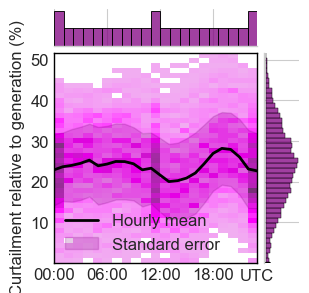

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming hourly_cur_rel_to_gen is defined as a Series
hourly_cur_rel_to_gen_ = hourly_cur_rel_to_gen * 100

# Convert the Series to a DataFrame and add an 'hour' column
df_hourly_cur_rel_to_gen = hourly_cur_rel_to_gen_.reset_index()
df_hourly_cur_rel_to_gen['hour'] = df_hourly_cur_rel_to_gen['snapshot'].dt.hour

# Rename the Series column to 'rel_cur'
df_hourly_cur_rel_to_gen.rename(columns={df_hourly_cur_rel_to_gen.columns[1]: 'rel_cur'}, inplace=True)

# Set font size to 12
plt.rcParams.update({'font.size': 12})

# Define the desired width and height of the plot
width = 3.3  # in inches
height = 3.3  # in inches

# Create a JointGrid with the specified size
g = sns.JointGrid(data=df_hourly_cur_rel_to_gen, x='hour', y='rel_cur', height=height)

# Plot the joint plot with histograms
g = g.plot(sns.histplot, sns.histplot, color='purple')

# Add KDE to the y-axis marginal histogram
sns.kdeplot(data=df_hourly_cur_rel_to_gen['rel_cur'], ax=g.ax_marg_y, color='black', linewidth=1.5)

# Remove the marginal histogram on the x-axis
#g.ax_marg_x.clear()

# Remove labels from the top axis
g.ax_marg_x.set_xticks([])
g.ax_marg_x.set_xticklabels([])

# Remove the top and right spines
g.ax_joint.spines['top'].set_visible(False)
g.ax_joint.spines['right'].set_visible(False)

# Remove the negative ticks and labels on the top axis
g.ax_joint.xaxis.set_ticks_position('bottom')
g.ax_joint.xaxis.set_tick_params(top=False, labeltop=False)

# Plot the overlay plot on the same axis
ax = g.ax_joint
ax.plot(hourly_means_cur.index, hourly_means_cur, label='Hourly mean', color='black', linewidth=2, zorder=10)
ax.fill_between(hourly_means_cur.index, hourly_means_cur - hourly_stds_cur, hourly_means_cur + hourly_stds_cur, color='purple', alpha=0.2, label='Standard error')
ax.set_ylabel('Curtailment relative to generation (%)')
ax.set_xlabel('')
ax.set_xticks([0, 6, 12, 18])
ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00'])
ax.set_xlim(0, 23)
ax.set_ylim(0, hourly_cur_rel_to_gen_.max())
ax.set_yticks([10, 20, 30, 40, 50])
ax.grid(False)
ax.legend(loc='lower left', bbox_to_anchor= [-0.02, -0.02])
ax.annotate('UTC', xy=(1, -0.06), xycoords='axes fraction', ha='center', va='center')
# Add a solid box around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/curtailment-stats.pdf', format='pdf')
plt.show()


snapshot
0     4.688307
1     4.624376
2     4.670259
3     4.589349
4     4.270755
5     4.034442
6     3.663415
7     3.377168
8     3.281886
9     3.429046
10    3.919716
11    4.052214
12    4.366170
13    4.502131
14    4.436922
15    4.540322
16    4.612846
17    4.565896
18    4.502783
19    4.573651
20    4.676054
21    4.825304
22    5.074785
23    4.835505
dtype: float64


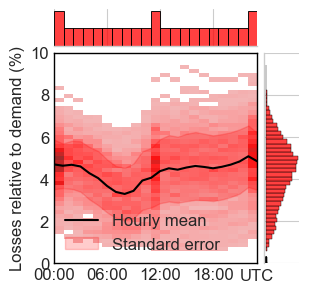

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming hourly_cur_rel_to_gen is defined as a Series
hourly_cur_rel_to_gen_ = hourly_losses_rel_to_load * 100

# Convert the Series to a DataFrame and add an 'hour' column
df_hourly_cur_rel_to_gen = hourly_cur_rel_to_gen_.reset_index()
df_hourly_cur_rel_to_gen['hour'] = df_hourly_cur_rel_to_gen['snapshot'].dt.hour

# Rename the Series column to 'rel_cur'
df_hourly_cur_rel_to_gen.rename(columns={df_hourly_cur_rel_to_gen.columns[1]: 'rel_cur'}, inplace=True)

# Set font size to 12
plt.rcParams.update({'font.size': 12})

# Define the desired width and height of the plot
width = 3.3  # in inches
height = 3.3  # in inches

# Create a JointGrid with the specified size
g = sns.JointGrid(data=df_hourly_cur_rel_to_gen, x='hour', y='rel_cur', height=height)

# Plot the joint plot with histograms
g = g.plot(sns.histplot, sns.histplot, color='red')

# Add KDE to the y-axis marginal histogram
sns.kdeplot(data=df_hourly_cur_rel_to_gen['rel_cur'], ax=g.ax_marg_y, color='black', linewidth=1.5)

# Remove the marginal histogram on the x-axis
#g.ax_marg_x.clear()

# Remove labels from the top axis
g.ax_marg_x.set_xticks([])
g.ax_marg_x.set_xticklabels([])

# Remove the top and right spines
g.ax_joint.spines['top'].set_visible(False)
g.ax_joint.spines['right'].set_visible(False)

# Remove the negative ticks and labels on the top axis
g.ax_joint.xaxis.set_ticks_position('bottom')
g.ax_joint.xaxis.set_tick_params(top=False, labeltop=False)

# Plot the overlay plot on the same axis
ax = g.ax_joint
print(hourly_means_losses)
ax.plot(hourly_means_losses.index, hourly_means_losses, label='Hourly mean', color='black', linewidth=1.5)
ax.fill_between(hourly_means_losses.index, hourly_means_losses - hourly_stds_losses, hourly_means_losses + hourly_stds_losses, color='red', alpha=0.2, label='Standard error')
ax.set_ylabel('Losses relative to demand (%)')
ax.set_xticks([0, 6, 12, 18], ['00:00', '06:00', '12:00', '18:00'])
ax.set_xlim(0, 23)
ax.set_ylim(0, 10)
ax.grid(False)
ax.set_xlabel('')
ax.legend(loc='lower left', bbox_to_anchor= [-0.02, -0.02])
ax.annotate('UTC', xy=(1, -0.06), xycoords='axes fraction', ha='center', va='center')
# Add a solid box around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/losses-stats.pdf', format='pdf')
plt.show()


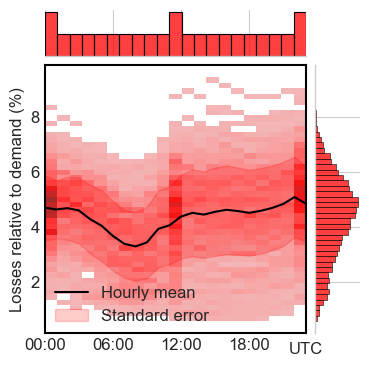

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming hourly_cur_rel_to_gen is defined as a Series
hourly_cur_rel_to_gen_ = hourly_losses_rel_to_load * 100

# Convert the Series to a DataFrame and add an 'hour' column
df_hourly_cur_rel_to_gen = hourly_cur_rel_to_gen_.reset_index()
df_hourly_cur_rel_to_gen['hour'] = df_hourly_cur_rel_to_gen['snapshot'].dt.hour

# Rename the Series column to 'rel_cur'
df_hourly_cur_rel_to_gen.rename(columns={df_hourly_cur_rel_to_gen.columns[1]: 'rel_cur'}, inplace=True)

# Set font size to 12
plt.rcParams.update({'font.size': 12})

# Define the desired width and height of the plot
width = 3.3  # in inches
height = 4  # in inches

# Create a JointGrid with the specified size
g = sns.JointGrid(data=df_hourly_cur_rel_to_gen, x='hour', y='rel_cur', height=height)

# Plot the joint plot with histograms
g = g.plot(sns.histplot, sns.histplot, color='red')

# Remove the marginal histogram on the x-axis
#g.ax_marg_x.clear()

# Remove labels from the top marginal axis
g.ax_marg_x.set_xticks([])
g.ax_marg_x.set_xticklabels([])

# Remove the top and right spines
g.ax_joint.spines['top'].set_visible(False)
g.ax_joint.spines['right'].set_visible(False)

# Remove ticks and labels from the top joint axis
g.ax_joint.xaxis.set_ticks([])
g.ax_joint.xaxis.set_ticklabels([])

# Plot the overlay plot on the same axis
ax = g.ax_joint
ax.plot(hourly_means_losses.index, hourly_means_losses, label='Hourly mean', color='black', linewidth=1.5)
ax.fill_between(hourly_means_losses.index, hourly_means_losses - hourly_stds_losses, hourly_means_losses + hourly_stds_losses, color='red', alpha=0.2, label='Standard error')
ax.set_ylabel('Losses relative to demand (%)')
ax.set_xticks([0, 6, 12, 18])
ax.set_xticklabels(['00:00', '06:00', '12:00', '18:00'])
ax.set_xlim(0, 23)
#ax.set_ylim(0, 11)
ax.grid(False)
ax.set_xlabel('')
ax.legend(loc='lower left', bbox_to_anchor=[-0.02, -0.02])
ax.annotate('UTC', xy=(1, -0.06), xycoords='axes fraction', ha='center', va='center')

# Add a solid box around the plot
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_edgecolor('black')

# Save and show the plot
plt.show()


## Statistics of losses

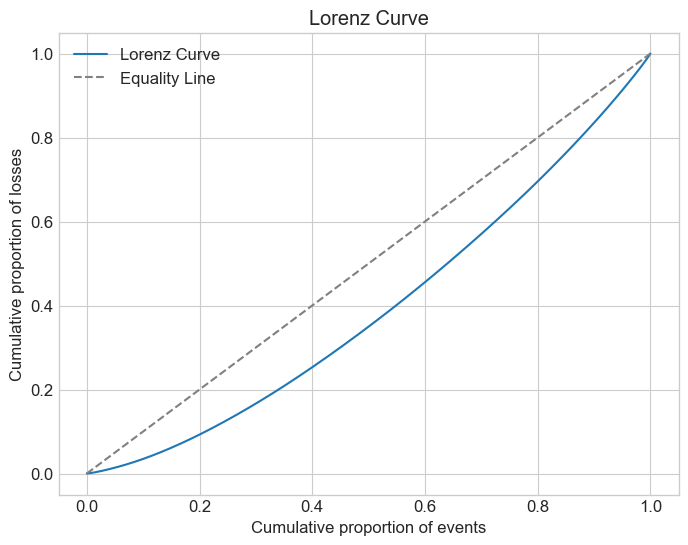

Gini Coefficient: 0.21216090146210054
63.96% of the events are responsible for 50.0% of the losses.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Step 1: Sort the data
sorted_losses = np.sort(total_hourly_abs_losses)

# Step 2: Calculate cumulative losses
cumulative_losses = np.cumsum(sorted_losses)

# Step 3: Calculate cumulative proportion
total_loss = cumulative_losses[-1]
cumulative_proportion_losses = cumulative_losses / total_loss
cumulative_proportion_events = np.arange(1, len(sorted_losses) + 1) / len(sorted_losses)

# Step 4: Plot the Lorenz curve
plt.figure(figsize=(8, 6))
plt.plot(cumulative_proportion_events, cumulative_proportion_losses, label="Lorenz Curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label="Equality Line")
plt.xlabel("Cumulative proportion of events")
plt.ylabel("Cumulative proportion of losses")
plt.legend()
plt.title("Lorenz Curve")
plt.show()

# Step 5: Calculate the Gini coefficient
lorenz_curve_area = np.trapz(cumulative_proportion_losses, cumulative_proportion_events)
gini_coefficient = 1 - 2 * lorenz_curve_area

print(f"Gini Coefficient: {gini_coefficient}")

# To find specific statistics, such as the percentage of events responsible for 50% of the losses
target_percentage = 0.50
events_responsible = cumulative_proportion_events[np.searchsorted(cumulative_proportion_losses, target_percentage)]
print(f"{events_responsible*100:.2f}% of the events are responsible for {target_percentage*100}% of the losses.")


## Correlation matrix

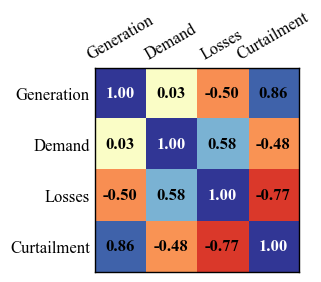

In [ ]:
# Combine into a DataFrame
data = pd.DataFrame({
    'Generation': total_hourly_gen,
    'Demand': total_hourly_load,
    'Losses': total_hourly_abs_losses,
    'Curtailment': total_hourly_cur
    
})

# Calculate pairwise correlations
correlation_matrix = data.corr()

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(3.3, 3.3))

# Display the matrix values with reversed colormap
cax = ax.matshow(correlation_matrix, cmap='RdYlBu', vmin=-1, vmax=1)

# Set axis ticks and labels
ax.grid(False)
ax.set_xticks(range(len(correlation_matrix.columns)))
ax.set_yticks(range(len(correlation_matrix.index)))
ax.set_xticklabels(correlation_matrix.columns, rotation=30, fontsize=12)
ax.set_yticklabels(correlation_matrix.index, fontsize=12)

# Add text annotations
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        plt.text(i, j, f'{correlation_matrix.iloc[j, i]:.2f}', ha='center', va='center', color= 'white' if i==j else 'black', fontsize=12, fontweight='bold')

# Title and layout adjustments
plt.tight_layout()
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/correlation-matrix.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


## Fourier Transform

### Global fourier transform

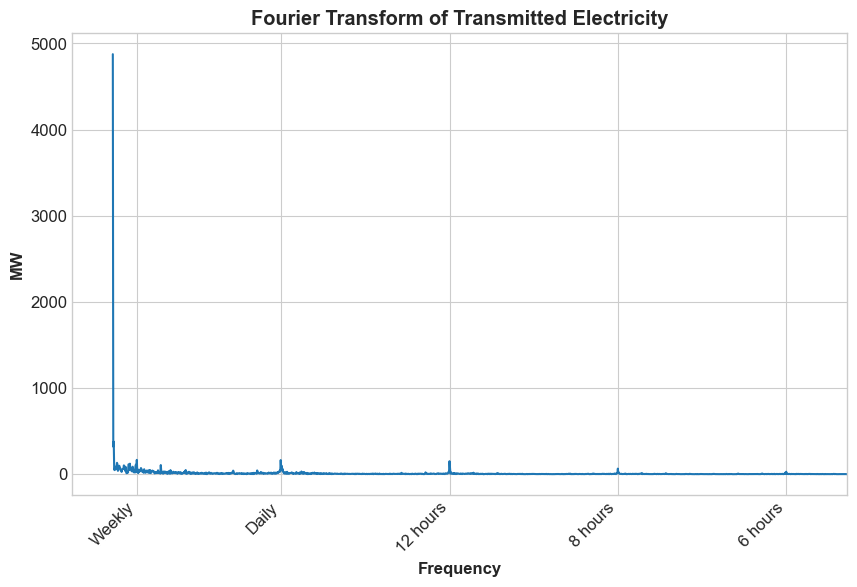

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
# Convert to numpy array
hourly_p_trans_rel_gen_array = total_actual_flow.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('MW', fontweight='bold')
ax.set_title(f'Fourier Transform of Transmitted Electricity', fontweight='bold')
ax.grid(True, axis='x')

plt.show()

### Regional fourier transform

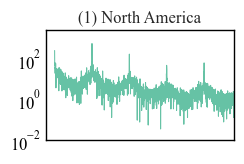

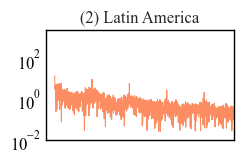

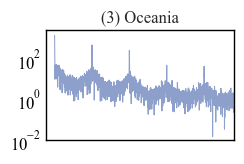

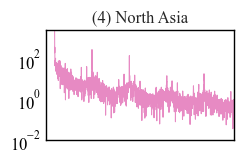

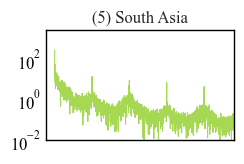

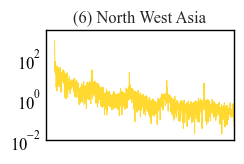

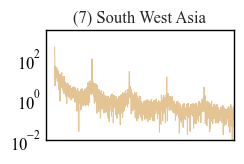

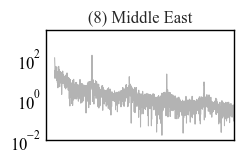

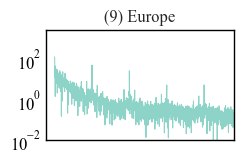

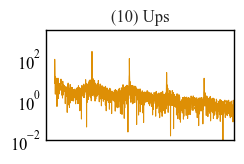

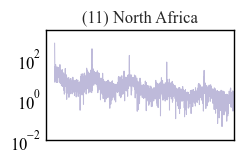

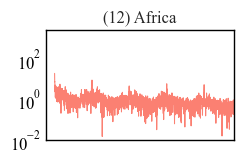

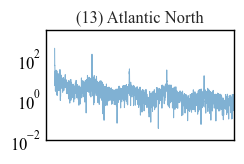

In [ ]:
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})
def format_region_name(region_name):
    return ' '.join(word.capitalize() for word in region_name.split('_'))

def plot_fourier_transform(region_key, region_value):
    series = region_value["netflow_series"]
    series = series.to_numpy()
    N = len(series)
    T = 1.0
    yf = fft(series)
    xf = fftfreq(N, T)[:N // 2]
    
    three_hour_freq = 1 / 3.0
    six_hour_freq = 1 / 6.0
    eight_hour_freq = 1 / 8.0
    half_daily_freq = 1 / 12.0
    daily_freq = 1 / 24.0
    weekly_freq = 1 / (24.0 * 7)
    
    frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq, half_daily_freq, daily_freq, weekly_freq]
    labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
    
    fig, ax = plt.subplots(figsize=(2.6, 1.8))
    ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]), color=region_colors[region_key], linewidth=0.75)
    ax.set_xticks(frequencies)
    #ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xticklabels([])
    ax.set_xlim(-0.01, 1/5)
    #ax.set_xlabel('Frequency')
    #ax.set_ylabel('Net flow (GW)')
    formatted_title = f'({regions_dic[region_key]['bus']}) {format_region_name(region_key)}'
    ax.set_title(f'{formatted_title}', fontsize=12)
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 3e3)
    ax.grid(False)
    #ax.grid(True, axis='x')
    #ax.xaxis.set_label_coords(0.95, -0.05)
    plt.tight_layout()
    plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/fourier-netflow-{region_key}.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

# Loop through each region and plot individually
for region_key, region_value in regions_dic.items():
    plot_fourier_transform(region_key, region_value)

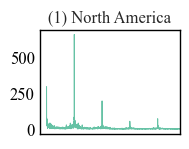

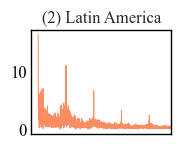

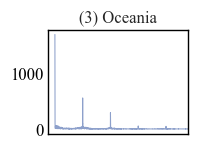

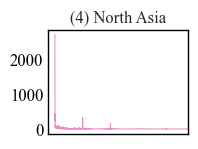

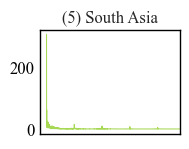

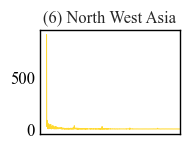

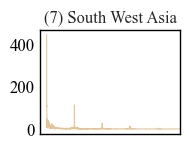

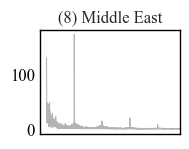

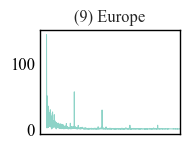

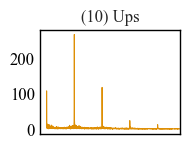

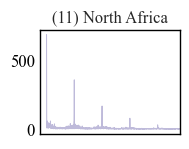

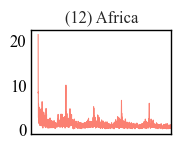

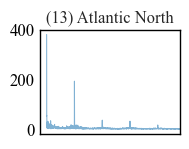

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq

plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

def format_region_name(region_name):
    return ' '.join(word.capitalize() for word in region_name.split('_'))

def plot_fourier_transform(region_key, region_value):
    series = region_value["netflow_series"]
    series = series.to_numpy()
    N = len(series)
    T = 1.0
    yf = fft(series)
    xf = fftfreq(N, T)[:N // 2]
    
    three_hour_freq = 1 / 3.0
    six_hour_freq = 1 / 6.0
    eight_hour_freq = 1 / 8.0
    half_daily_freq = 1 / 12.0
    daily_freq = 1 / 24.0
    weekly_freq = 1 / (24.0 * 7)
    
    frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq, half_daily_freq, daily_freq, weekly_freq]
    labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
    
    fig_width = 1.4  # Desired x-axis length in inches
    fig_height = 1.6  # Adjust this to control overall figure height
    margins = (0.3, 0)  # Left and right margins in inches

    total_width = fig_width + margins[0] + margins[1]
    fig, ax = plt.subplots(figsize=(total_width, fig_height))

    ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]), color=region_colors[region_key], linewidth=0.75)
    ax.set_xticks(frequencies)
    ax.set_xticklabels([])
    ax.set_xlim(-0.01, 1/5)
    formatted_title = f'({regions_dic[region_key]["bus"]}) {format_region_name(region_key)}'
    ax.set_title(f'{formatted_title}', fontsize=12)
    ax.grid(False)
    
    # Adjust subplot parameters to fit the axis length
    fig.subplots_adjust(left=margins[0]/total_width, right=1-margins[1]/total_width, top=0.85, bottom=0.2)
    
    plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/fourier-netflow-{region_key}.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

# Loop through each region and plot individually
for region_key, region_value in regions_dic.items():
    plot_fourier_transform(region_key, region_value)


# **Maps**

## Global grid map

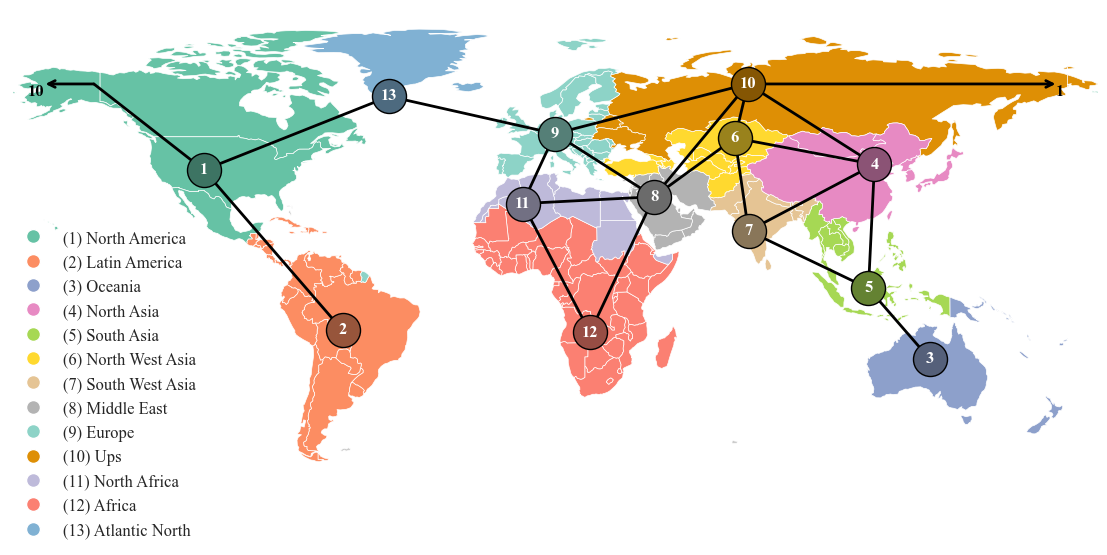

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic
import matplotlib.colors as mcolors
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})
plt.rc("figure", figsize=(14, 10))
# Function to convert RGB tuple to hex
def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

def darken_color(color, factor=0.8):
    """
    Darkens a color by a given factor.
    color: The color to be darkened (in RGB or hex format).
    factor: The factor to darken the color (default is 0.8).
    """
    rgb = mcolors.to_rgb(color)  # Convert to RGB if in hex
    darker_rgb = [factor * c for c in rgb]  # Apply factor to each component
    return mcolors.to_hex(darker_rgb)  # Convert back to hex

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Manually assign French Guiana to Latin America
world.loc[world['name'] == 'France', 'bus'] = world.loc[world['name'] == 'France'].apply(
    lambda row: 'latin_america' if row['continent'] == 'South America' else row['bus'],
    axis=1
)

# Ensure that we have unique regions in the order defined in regions_dic
ordered_regions = [key for key in regions_dic if key in world['bus'].unique()]

# Convert colors to hex
colors = [rgb_to_hex(region_colors[bus]) if bus in region_colors else '#cccccc' for bus in world['bus']]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed


# Plot country regions with assigned colors
world.plot(ax=ax, color=colors, edgecolor='white', legend=False,transform=ccrs.PlateCarree(), linewidth=0.5)
# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=region_colors[region], markersize=10, label=f'({i+1}) {region.replace('_', ' ').title()}')
    for i, region in enumerate(ordered_regions)
]

for i, bus in enumerate(n.buses.index, start=1):
    color_ = color_ = darken_color(region_colors[bus], factor=0.6)
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=600, color=color_, edgecolor='black', zorder=5, linewidths=1, transform=ccrs.PlateCarree())
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())

# Plot links
for i, link in enumerate(n.links.index[0::2]):
    if link != 'north_america_to_ups_0':
        bus0 = n.links.loc[link, 'bus0']
        bus1 = n.links.loc[link, 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=2, zorder=4, transform=ccrs.PlateCarree())
    else:
        bus0 = n.links.loc['north_america_to_ups_0', 'bus0']
        bus1 = n.links.loc['north_america_to_ups_0', 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]    
        x1, y1 = -143, n.buses.loc[bus1, ['x', 'y']]['y']
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=2, zorder=4, transform=ccrs.PlateCarree())
        x0, y0 = x1+0.9, y1    
        x1, y1 = -160, y1
        ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=2), transform=ccrs.PlateCarree()) 
        ax.text(-165, y1, '10', color='black', fontsize=12, ha='left', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree()) 
        x0, y0 = 177, y1    
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.annotate('', xy=(x0, y0), xytext=(x1, y1),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=2), transform=ccrs.PlateCarree()) 
        ax.text(x0+2, y0, '1', color='black', fontsize=12, ha='right', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())     
ax.spines['geo'].set_visible(False)
ax.legend(
    handles=handles, 
    loc='lower left', 
    bbox_to_anchor=(-0.01, -0.03), 
    bbox_transform=ax.transAxes, 
    fancybox=False, 
    shadow=False, 
    ncol=1, 
    fontsize=12, 
    frameon=False, 
    framealpha=1, 
    edgecolor='black'
)
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/global-grid-map.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic
import matplotlib.colors as mcolors
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'axes.edgecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})
plt.rc("figure", figsize=(14, 10))
# Function to convert RGB tuple to hex
def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

def darken_color(color, factor=0.8):
    """
    Darkens a color by a given factor.
    color: The color to be darkened (in RGB or hex format).
    factor: The factor to darken the color (default is 0.8).
    """
    rgb = mcolors.to_rgb(color)  # Convert to RGB if in hex
    darker_rgb = [factor * c for c in rgb]  # Apply factor to each component
    return mcolors.to_hex(darker_rgb)  # Convert back to hex

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Manually assign French Guiana to Latin America
world.loc[world['name'] == 'France', 'bus'] = world.loc[world['name'] == 'France'].apply(
    lambda row: 'latin_america' if row['continent'] == 'South America' else row['bus'],
    axis=1
)

# Ensure that we have unique regions in the order defined in regions_dic
ordered_regions = [key for key in regions_dic if key in world['bus'].unique()]

# Convert colors to hex
colors = [rgb_to_hex(region_colors[bus]) if bus in region_colors else '#cccccc' for bus in world['bus']]

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
ax.set_extent([-180, 180, -80, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed


# Plot country regions with assigned colors
world.plot(ax=ax, color='white', edgecolor='black', legend=False,transform=ccrs.PlateCarree(), linewidth=0.5)
# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=region_colors[region], markersize=10, label=f'({i+1}) {regions_dic[region]['region']}')
    for i, region in enumerate(ordered_regions)
]

for i, bus in enumerate(n.buses.index, start=1):
    color_ = color_ = darken_color(region_colors[bus], factor=0.6)
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=200, color='white', edgecolor='black', zorder=5, linewidths=1, transform=ccrs.PlateCarree())
    #ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())

# Plot links
for i, link in enumerate(n.links.index[0::2]):
    if link != 'north_america_to_ups_0':
        bus0 = n.links.loc[link, 'bus0']
        bus1 = n.links.loc[link, 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=1, zorder=4, transform=ccrs.PlateCarree())
    else:
        bus0 = n.links.loc['north_america_to_ups_0', 'bus0']
        bus1 = n.links.loc['north_america_to_ups_0', 'bus1']
        x0, y0 = n.buses.loc[bus0, ['x', 'y']]    
        x1, y1 = -143, n.buses.loc[bus1, ['x', 'y']]['y']
        ax.plot([x0, x1], [y0, y1], color='black', linewidth=1, zorder=4, transform=ccrs.PlateCarree())
        x0, y0 = x1+0.9, y1    
        x1, y1 = -160, y1
        ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1), transform=ccrs.PlateCarree()) 
        #ax.text(-165, y1, '10', color='black', fontsize=12, ha='left', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree()) 
        x0, y0 = 177, y1    
        x1, y1 = n.buses.loc[bus1, ['x', 'y']]
        ax.annotate('', xy=(x0, y0), xytext=(x1, y1),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1), transform=ccrs.PlateCarree()) 
        #ax.text(x0+2, y0, '1', color='black', fontsize=12, ha='right', va='top', zorder=6, fontweight='bold', transform=ccrs.PlateCarree())     
ax.spines['geo'].set_visible(False)
# ax.legend(
#     handles=handles, 
#     loc='lower left', 
#     bbox_to_anchor=(-0.01, -0.03), 
#     bbox_transform=ax.transAxes, 
#     fancybox=False, 
#     shadow=False, 
#     ncol=1, 
#     fontsize=12, 
#     frameon=False, 
#     framealpha=1, 
#     edgecolor='black'
# )
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/global-grid-map-bw.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

## Heat maps

0.5266077758514209
0.49661029714856786
1.3505797331305982
1.255345542877812
1.410511100615686
2.1016589309375573
1.3734250428036738
3.0851474503171663
1.550748775667084
0.03843398187580063
1.025955726664757
0.3383704712132324
5.063699176393695


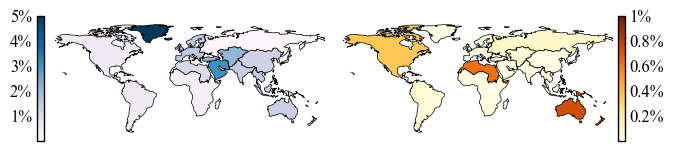

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100  # to go from GW to to W
    print(installed_cap_wind_area[key])
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area, installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap, setting vmin and vmax
    if i == 0:
        norm = Normalize(vmin=0, vmax=5)
        cmap = cm.PuBu
    else:
        norm = Normalize(vmin=0, vmax=1)
        cmap = cm.YlOrBr

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_ticks([1, 2, 3, 4, 5])  # Customize the ticks
        cbar.set_ticklabels(['1%', '2%', '3%', '4%', '5%'])  # Customize the tick labels
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Customize the ticks
        cbar.set_ticklabels(['0.2%', '0.4%', '0.6%', '0.8%', '1%'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-land-use-share.pdf', format='pdf', bbox_inches='tight')
plt.show()


0.5266077758514209
0.49661029714856786
1.3505797331305982
1.255345542877812
1.410511100615686
2.1016589309375573
1.3734250428036738
3.0851474503171663
1.550748775667084
0.03843398187580063
1.025955726664757
0.3383704712132324
5.063699176393695


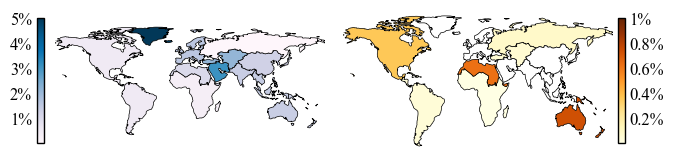

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100  # to go from GW to to W
    print(installed_cap_wind_area[key])
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area, installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap, setting vmin and vmax
    if i == 0:
        norm = Normalize(vmin=0, vmax=5)
        cmap = cm.PuBu
    else:
        norm = Normalize(vmin=0, vmax=1)
        cmap = cm.YlOrBr

    # Mask zero values to be white for solar generation
    if i == 1:
        regions['value'] = regions['value'].apply(lambda x: np.nan if x == 0 else x)
    
    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', missing_kwds={'color': 'white'}, transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_ticks([1, 2, 3, 4, 5])  # Customize the ticks
        cbar.set_ticklabels(['1%', '2%', '3%', '4%', '5%'])  # Customize the tick labels
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Customize the ticks
        cbar.set_ticklabels(['0.2%', '0.4%', '0.6%', '0.8%', '1%'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-land-use-share.pdf', format='pdf', bbox_inches='tight')
plt.show()


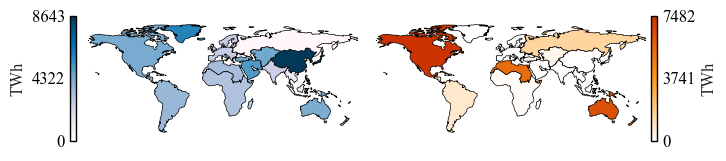

In [ ]:
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.cm as cm

# Example dictionaries (Replace with actual data)
installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
for key, value in regions_dic.items():
    installed_capacity_wind_dic[key] = value["total_wind_yearly"] * 1e-3
    installed_capacity_pv_dic[key] = value["total_pv_yearly"] * 1e-3

values_dics = [installed_capacity_wind_dic, installed_capacity_pv_dic]

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['name'] != "Antarctica"]
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

# Create a custom colormap for solar generation with a steep gradient
colors = [(1, 1, 1), (1, 0.6, 0.1), (0.8, 0.2, 0)]
n_bins = 100
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    if values_dic:  # Check if the dictionary is not empty
        world['value'] = world['bus'].map(values_dic)
        regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})
        ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())

        # Set normalization with a steep gradient
        vmin = min(values_dic.values())
        vmax = max(values_dic.values())
        norm = Normalize(vmin=vmin, vmax=vmax)
        cmap = cm.PuBu if i == 0 else custom_cmap

        regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

        ax.spines['geo'].set_visible(False)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []

        if i == 0:
            cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.ax.yaxis.set_ticks_position('left')
            cbar.ax.yaxis.set_label_position('left')
            cbar.set_label('TWh')
            cbar.set_ticks([0, vmax / 2, vmax])
            cbar.set_ticklabels(['0', f'{vmax / 2:.0f}', f'{vmax:.0f}'])
        else:
            cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.set_label('TWh')
            cbar.set_ticks([0, vmax / 2, vmax])
            cbar.set_ticklabels(['0', f'{vmax / 2:.0f}', f'{vmax:.0f}'])

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-gen.pdf', format='pdf', bbox_inches='tight')
plt.show()


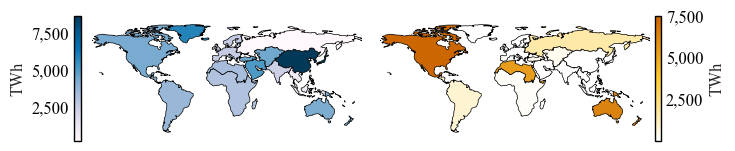

In [ ]:
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.cm as cm

# Dictionary setup (example)
installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
for key, value in regions_dic.items():
    installed_capacity_wind_dic[key] = value["total_wind_yearly"] * 1e-3
    installed_capacity_pv_dic[key] = value["total_pv_yearly"] * 1e-3

values_dics = [installed_capacity_wind_dic, installed_capacity_pv_dic]

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world['name'] != "Antarctica"]
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

# Create a custom colormap for the solar generation
colors = [(1, 1, 1), (1, 0.8, 0.2), (0.8, 0.4, 0)]
n_bins = 100
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    if values_dic:  # Check if the dictionary is not empty
        world['value'] = world['bus'].map(values_dic)
        regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})
        ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())

        norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
        cmap = cm.PuBu if i == 0 else custom_cmap

        regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

        if i == 1:
            zero_gen = regions[regions['value'] == 0]
            #zero_gen.plot(ax=ax, facecolor="none", edgecolor="black", hatch='xx', transform=ccrs.PlateCarree(), linewidth=0.5)

        ax.spines['geo'].set_visible(False)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm._A = []

        if i == 0:
            cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.ax.yaxis.set_ticks_position('left')
            cbar.ax.yaxis.set_label_position('left')
            cbar.set_label('TWh')
            cbar.set_ticks([2500, 5000, 7500])
            cbar.set_ticklabels(['2,500', '5,000', '7,500'])
        else:
            cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])
            cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
            cbar.set_label('TWh')
            cbar.set_ticks([2500, 5000, 7500])
            cbar.set_ticklabels(['2,500', '5,000', '7,500'])

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/heat-map-wind-pv-gen.pdf', format='pdf', bbox_inches='tight')
plt.show()


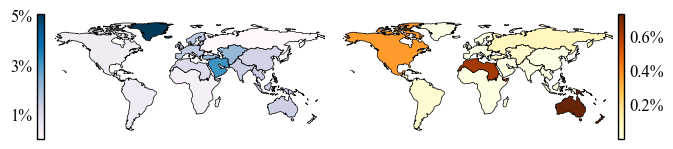

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(6.6, 2.5))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100  # to go from GW to to W
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area, installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)}, figsize=(6.6, 2.5))

for i, ax in enumerate(axes):
    values_dic = values_dics[i]
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.PuBu if i == 0 else cm.YlOrBr

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    ax.spines['geo'].set_visible(False)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    
    if i == 0:
        cax = fig.add_axes([0.05, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.ax.yaxis.set_ticks_position('left')
        cbar.ax.yaxis.set_label_position('left')
        cbar.set_ticks([1,  3, 5])  # Customize the ticks
        cbar.set_ticklabels(['1%', '3%', '5%'])  # Customize the tick labels
    else:
        cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])  # Adjust position and width as needed
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
        cbar.set_ticks([0.2, 0.4, 0.6])  # Customize the ticks
        cbar.set_ticklabels(['0.2%', '0.4%', '0.6%'])  # Customize the tick labels

plt.tight_layout(rect=[0.05, 0.1, 0.95, 0.9])  # Adjust layout to prevent overlap
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/wind-pv-land-use.svg', format='svg')
plt.show()

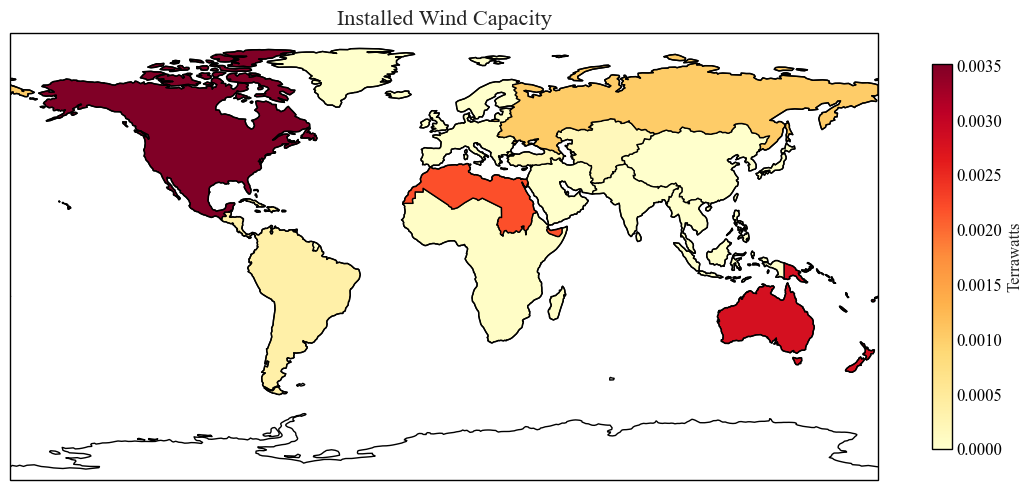

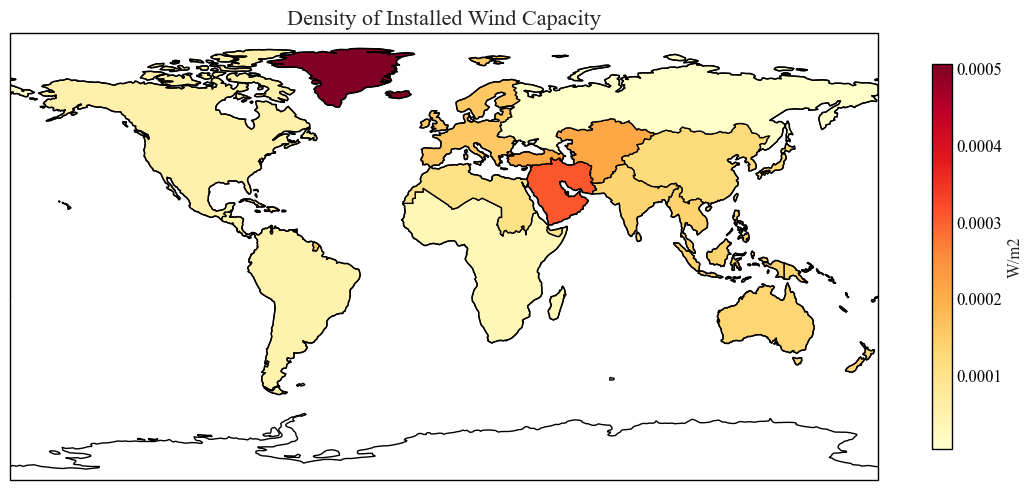

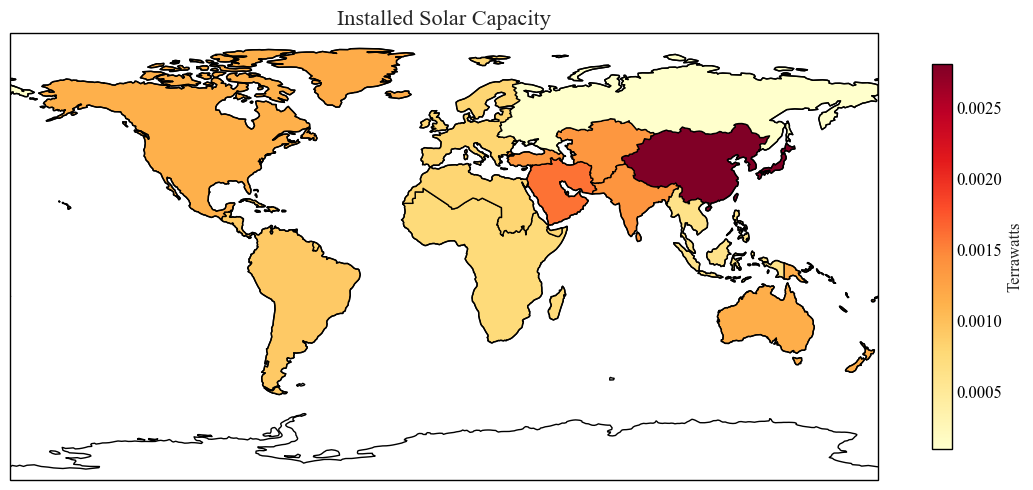

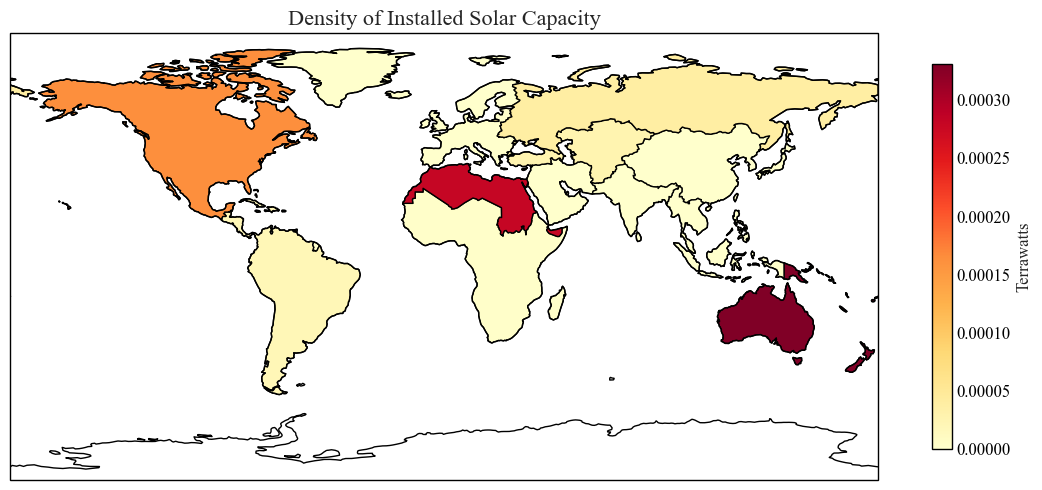

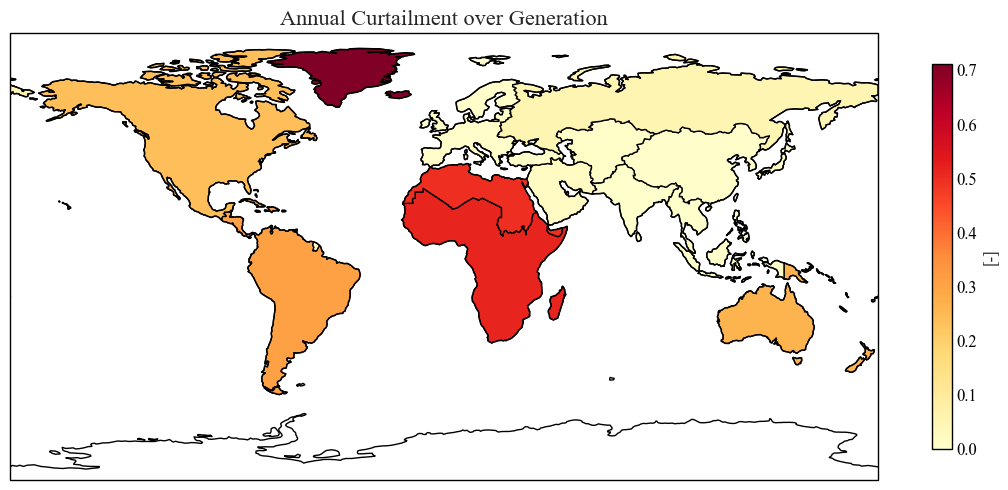

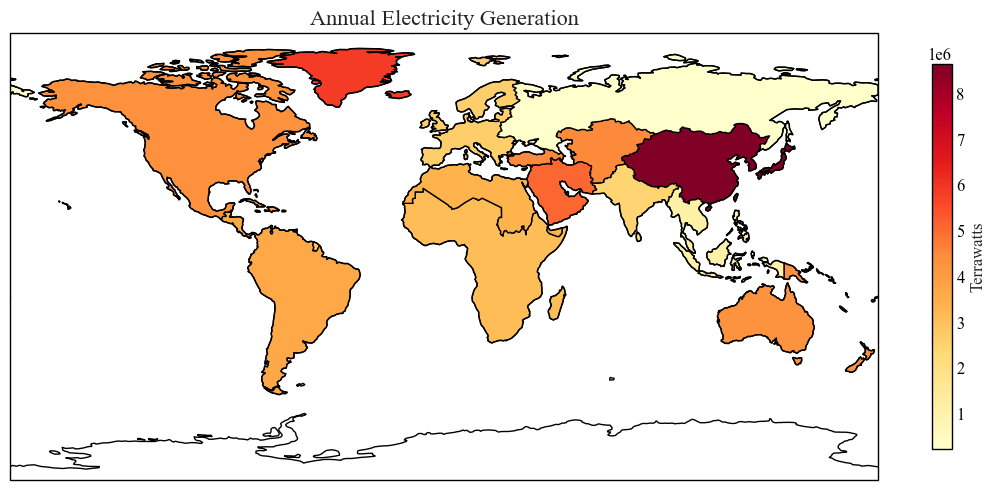

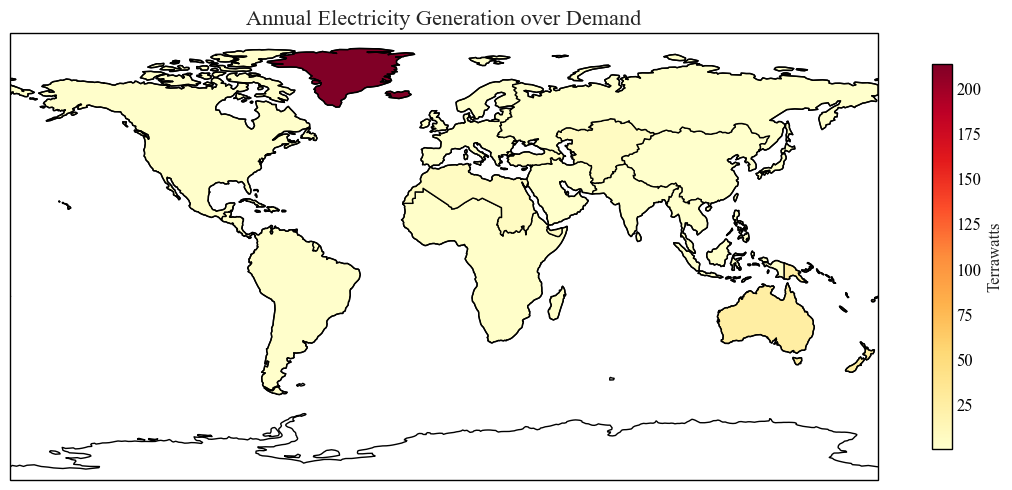

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_capacity_wind_dic[key] = value["wind_installed"] / 1e6
    installed_capacity_pv_dic[key] = value["pv_installed"] / 1e6
    installed_cap_pv_area[key] = value["wind_installed"] / area * 1e6
    installed_cap_wind_area[key] = value["pv_installed"] / area * 1e6
    curtailment_rel_to_gen[key] = value["total_curtailment_yearly"] / (value["total_wind_yearly"] + value["total_pv_yearly"])
    loads_dic[key] = (value["total_wind_yearly"] + value["total_pv_yearly"]) / value["total_load_yearly"]
    generation_dic[key] = value["total_wind_yearly"] + value["total_pv_yearly"] / 1e6
values_dics = [installed_capacity_pv_dic, installed_cap_pv_area,  installed_capacity_wind_dic,  installed_cap_wind_area, curtailment_rel_to_gen, generation_dic, loads_dic]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    # Plotting the network with results
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

    # Add base map features
    ax.add_feature(cfeature.COASTLINE)

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.YlOrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree())

    # for i, bus in enumerate(n.buses.index, start=1):
    #     x, y = n.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Installed Wind Capacity', fontsize=16)
    elif i == 1:
        plt.title('Density of Installed Wind Capacity', fontsize=16)
    elif i == 2:
        plt.title('Installed Solar Capacity', fontsize=16)
    elif i == 3:
        plt.title('Density of Installed Solar Capacity', fontsize=16)
    elif i == 4:
        plt.title('Annual Curtailment over Generation', fontsize=16)
    elif i == 5:
        plt.title('Annual Electricity Generation', fontsize=16)
    elif i == 6:
        plt.title('Annual Electricity Generation over Demand', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    if i == np.any([1, 3]):
        cbar.set_label('W/m2')
    elif i == np.any([5, 6]):
        cbar.set_label('TWh')
    elif i == 4:
        cbar.set_label('[-]')
    else:
        cbar.set_label('Terrawatts')


    plt.show()

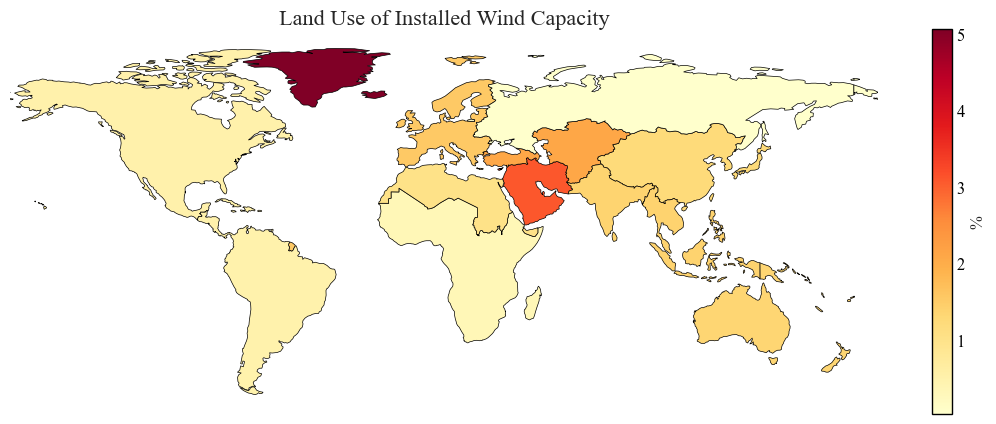

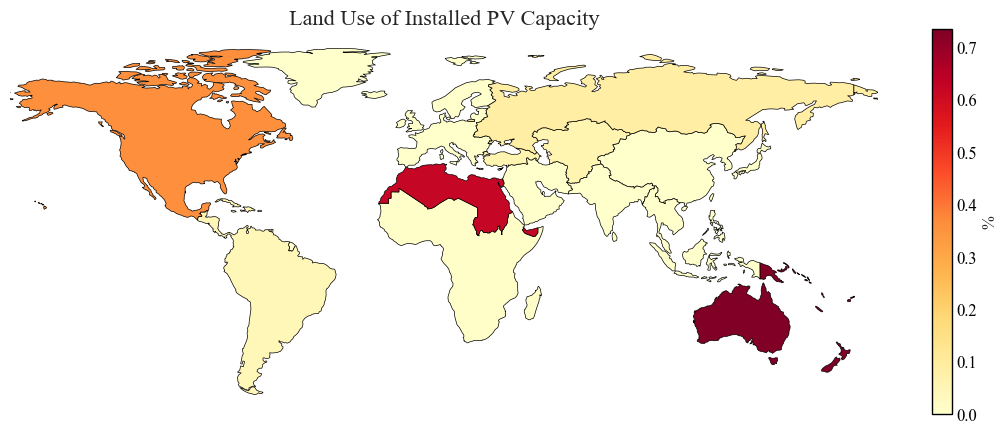

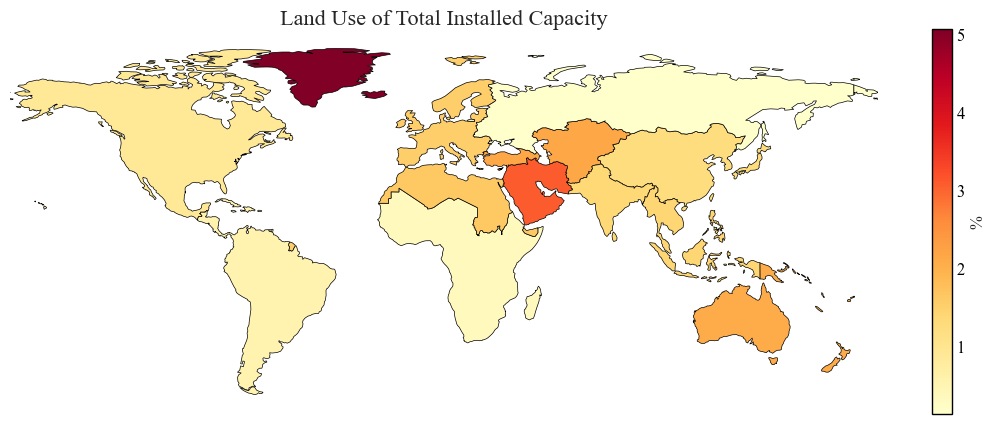

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

installed_capacity_wind_dic = {}
installed_capacity_pv_dic = {}
installed_cap_pv_area = {}
installed_cap_wind_area = {}
curtailment_rel_to_gen = {}
loads_dic = {}
generation_area_dic = {}
generation_dic = {}
installed_cap_land_share = {}
for key, value in regions_dic.items():
    area = region_area(key)
    installed_cap_wind_area[key] = value["wind_installed"] / wind_density / area * 1e9 * 100 # to go from GW to to W
    installed_cap_pv_area[key] = value["pv_installed"] / pv_density / area * 1e9 * 100
    installed_cap_land_share[key] = installed_cap_wind_area[key] + installed_cap_pv_area[key]

values_dics = [installed_cap_wind_area,  installed_cap_pv_area, installed_cap_land_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    cmap = cm.YlOrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    # for i, bus in enumerate(n.buses.index, start=1):
    #     x, y = n.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Land Use of Installed Wind Capacity', fontsize=16)
    elif i == 1:
        plt.title('Land Use of Installed PV Capacity', fontsize=16)
    elif i == 2:
        plt.title('Land Use of Total Installed Capacity', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('%')

    ax.spines['geo'].set_visible(False)
    plt.show()

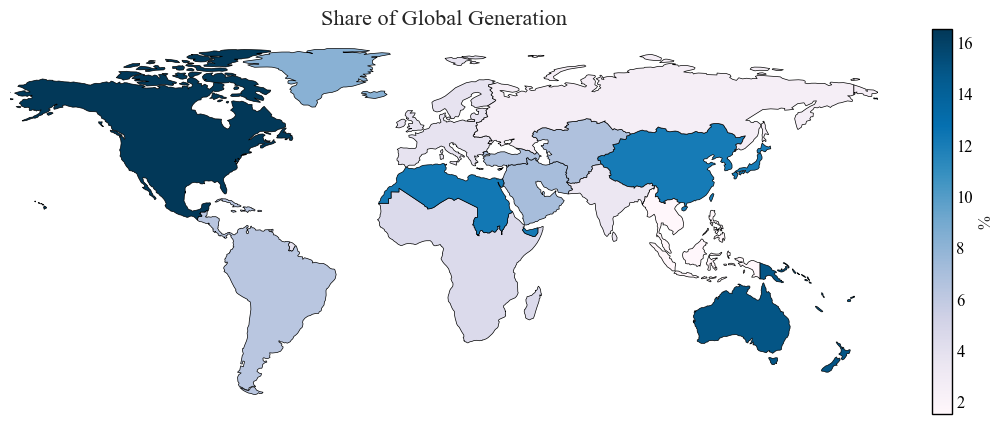

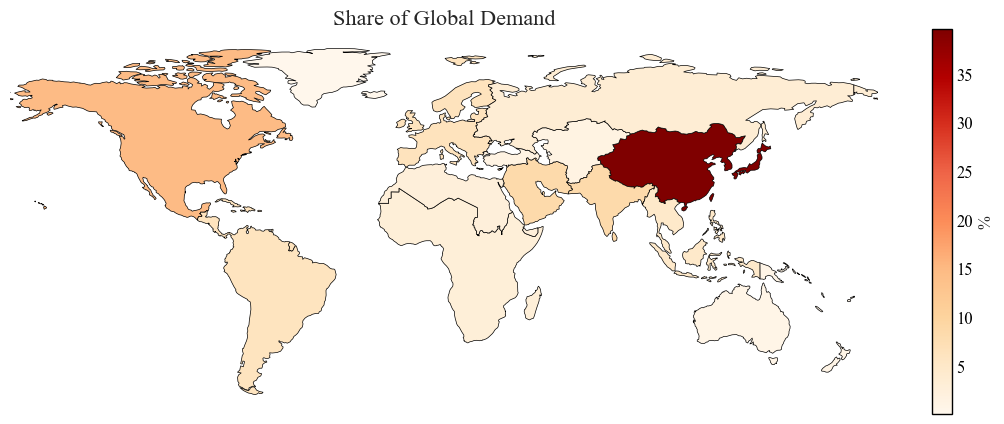

In [ ]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Geod
from matplotlib.colors import Normalize
import matplotlib.cm as cm

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

total_generation_global_share = {}
demand_global_share = {}
global_load = 0
global_generation = 0
for key, value in regions_dic.items():
    global_load += value["total_load_yearly"] 
    global_generation += (value["total_wind_yearly"] + value["total_pv_yearly"])
for key, value in regions_dic.items():
    area = region_area(key)
    total_generation_global_share[key] = (value["total_wind_yearly"] + value["total_pv_yearly"]) / global_generation * 100
    demand_global_share[key] = value["total_load_yearly"] / global_load * 100

values_dics = [total_generation_global_share,  demand_global_share]

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Remove Antarctica
world = world[world['name'] != "Antarctica"]
# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

for i, values_dic in enumerate(values_dics):
    # Add the values to the world GeoDataFrame
    world['value'] = world['bus'].map(values_dic)

    # Merge countries into regions, aggregating only the 'value' column
    regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree(central_longitude=10)})
    ax.set_extent([-180, 180, -62, 90], crs=ccrs.PlateCarree())  # Adjust extent as needed

    # Normalize the values for the colormap
    norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
    if i == 0:
        cmap = cm.PuBu
    elif i == 1:
        cmap = cm.OrRd

    # Plot regions with the heatmap, making sure normalization is applied
    regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree(), linewidth=0.5)

    # for i, bus in enumerate(n.buses.index, start=1):
    #     x, y = n.buses.loc[bus, ['x', 'y']]
    #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
    #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

    # Add a title to the figure
    if i == 0:
        plt.title('Share of Global Generation', fontsize=16)
    elif i == 1:
        plt.title('Share of Global Demand', fontsize=16)

    # Create and customize the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # Dummy array for the scalar mappable
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
    cbar.set_label('%')

    ax.spines['geo'].set_visible(False)
    plt.show()

## Power flow chart

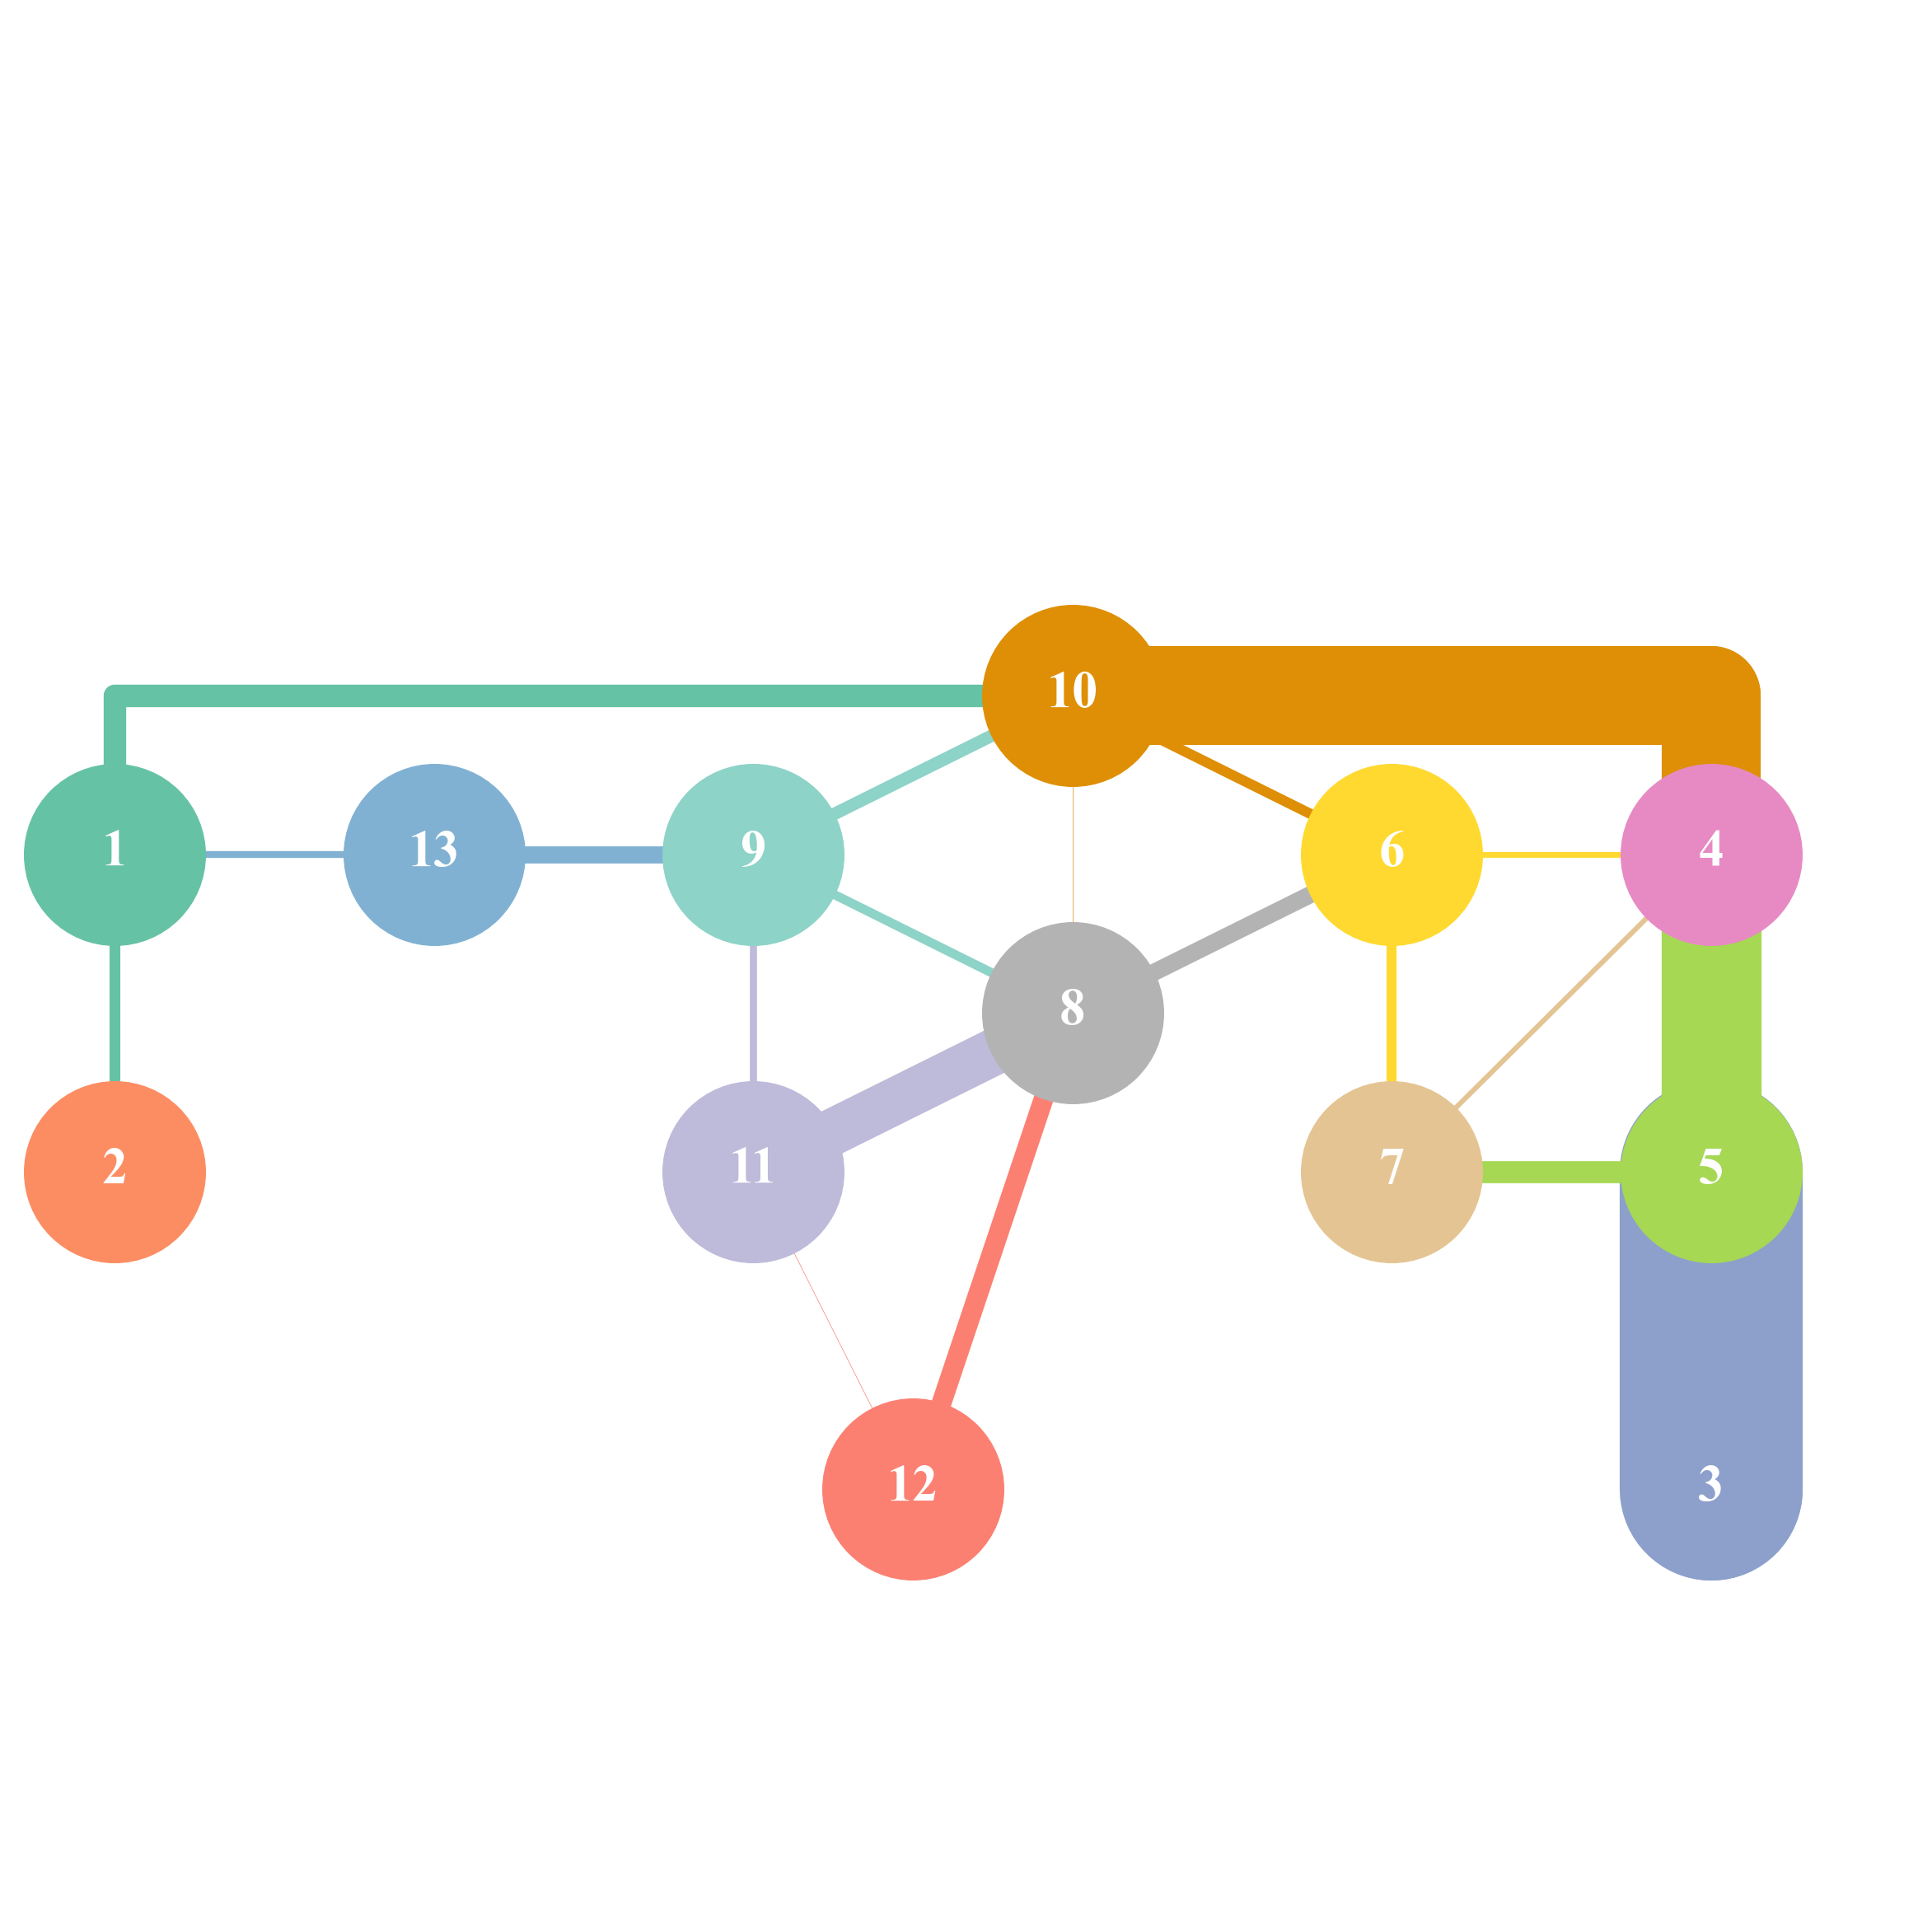

north_america_to_latin_america 0.01784237867310043
north_america_to_ups 0.037215731424316736
north_america_to_atlantic_north 0.011366072845736454
oceania_to_south_asia 0.302559977931197
north_asia_to_south_asia 0.1651678429561886
north_asia_to_north_west_asia 0.00935611596202896
north_asia_to_south_west_asia 0.008352460906616701
north_asia_to_ups 0.16359151077578082
south_asia_to_south_west_asia 0.036413714836324954
north_west_asia_to_south_west_asia 0.016548322200974956
north_west_asia_to_middle_east 0.028327585046164006
north_west_asia_to_ups 0.016916593951197666
middle_east_to_europe 0.015089583921822917
middle_east_to_ups 0.0006038466966903188
middle_east_to_north_africa 0.077303604010219
middle_east_to_africa 0.032731068857614856
europe_to_ups 0.02059526396759438
europe_to_north_africa 0.011697870414367898
europe_to_atlantic_north 0.02831183317910816
north_africa_to_africa 8.621442955053524e-06


In [101]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

total_flow = 0
for key, value in netflows_links_series.items():
    total_flow += netflows_links[key]
share_values = [netflows_links[key] / total_flow for (key, value) in netflows_links.items()]
plt.rc("figure", figsize=(30, 30))

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Scale coordinates to fit the plot
scale = 5
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for i, (key, value) in enumerate(links_dic.items())}  


# Plotting the network without background map
fig, ax = plt.subplots()
ax.set_xlim(-3.5*scale, 5.5*scale)
ax.set_ylim(-3.5*scale, 5.5*scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=25000, color=region_colors[region_key_matched], zorder=5)
    region_name = region_key.replace('_', ' ').title()
    region_number = regions_dic[region_key]['bus']
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_number, color='white', fontsize=45, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 0.65e8, 0.5)
    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        # Draw the L-shaped line for link 1_10
        ax.plot([-3*scale, -3*scale], [1.5*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([-3*scale, 1.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        # Draw the L-shaped line for link 4_10
        ax.plot([1.5*scale, 4.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([4.5*scale, 4.5*scale], [2.25*scale, 1.5*scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.show()

for i, (key, value) in enumerate(links_dic.items()):
    print(value['name'], share_values[i])


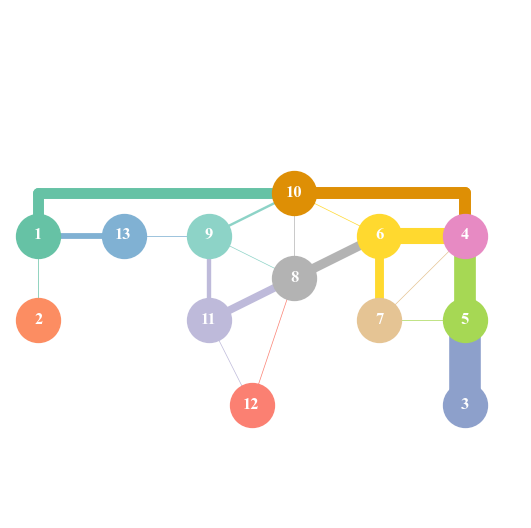

In [ ]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Calculate total flow and share values
total_flow = sum(netflows_links.values())
share_values = [netflows_links[key] / total_flow for key in netflows_links]

# Scale coordinates to fit the plot
scale = 1.5  # Adjust the scale to fit within 6.6x6.6 inch plot
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for key, value in links_dic.items()}

# Plotting the network without background map
fig, ax = plt.subplots(figsize=(6.6, 6.6))
plt.rc("font", size=12)

ax.set_xlim(-3.5 * scale, 5.5 * scale)
ax.set_ylim(-3.5 * scale, 5.5 * scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=1000, color=region_colors[region_key_matched], zorder=5)  # Increased node size
    region_name = region_key.replace('_', ' ').title()
    region_number = regions_dic[region_key]['bus']
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_number, color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 0.327e9, 0.5)
    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        ax.plot([-3 * scale, -3 * scale], [1.5 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([-3 * scale, 1.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        ax.plot([1.5 * scale, 4.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([4.5 * scale, 4.5 * scale], [2.25 * scale, 1.5 * scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/flow-chart.pdf', format='pdf')
plt.show()


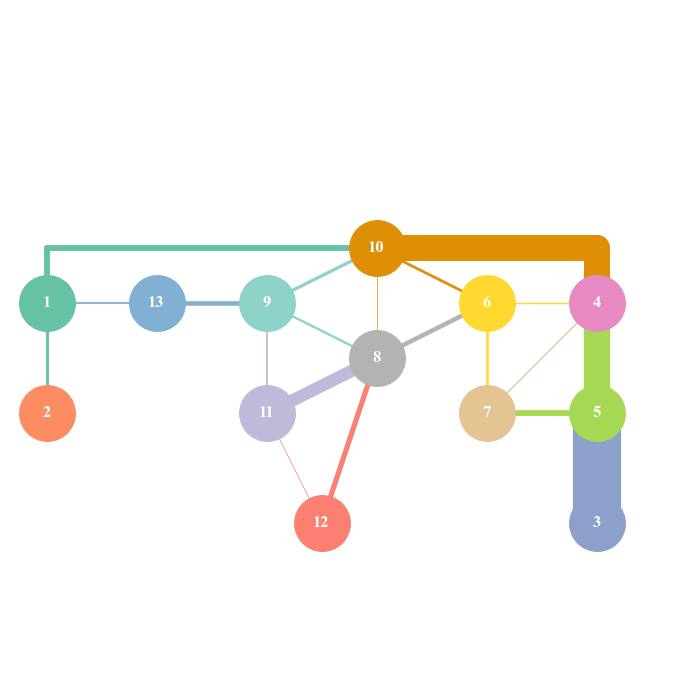

north_america_to_latin_america 0.017842378673100432
north_america_to_ups 0.03721573142431674
north_america_to_atlantic_north 0.011366072845736456
oceania_to_south_asia 0.30255997793119704
north_asia_to_south_asia 0.16516784295618864
north_asia_to_north_west_asia 0.009356115962028963
north_asia_to_south_west_asia 0.008352460906616703
north_asia_to_ups 0.16359151077578085
south_asia_to_south_west_asia 0.03641371483632496
north_west_asia_to_south_west_asia 0.01654832220097496
north_west_asia_to_middle_east 0.02832758504616401
north_west_asia_to_ups 0.01691659395119767
middle_east_to_europe 0.01508958392182292
middle_east_to_ups 0.000603846696690319
middle_east_to_north_africa 0.07730360401021902
middle_east_to_africa 0.03273106885761486
europe_to_ups 0.020595263967594382
europe_to_north_africa 0.0116978704143679
europe_to_atlantic_north 0.028311833179108167
north_africa_to_africa 8.621442955053526e-06


In [102]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Calculate total flow and share values
total_flow = sum(netflows_links.values())
share_values = [netflows_links[key] / total_flow for key in netflows_links]

# Scale coordinates to fit the plot
scale = 1.5  # Adjust the scale to fit within 6.6x6.6 inch plot
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for key, value in links_dic.items()}

# Plotting the network without background map
fig, ax = plt.subplots(figsize=(6.6, 6.6))
plt.rc("font", size=12)

ax.set_xlim(-3.5 * scale, 5.5 * scale)
ax.set_ylim(-3.5 * scale, 5.5 * scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=1600, color=region_colors[region_key_matched], zorder=5)  # Increased node size
    region_name = region_key.replace('_', ' ').title()
    region_number = regions_dic[region_key]['bus']
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_number, color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 0.3e9, 0.5)
    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        ax.plot([-3 * scale, -3 * scale], [1.5 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([-3 * scale, 1.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        ax.plot([1.5 * scale, 4.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([4.5 * scale, 4.5 * scale], [2.25 * scale, 1.5 * scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

# Adjust layout to remove extra whitespace
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save figure with tight bounding box
#plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/flow-chart.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

plt.show()

for i, (key, value) in enumerate(links_dic.items()):
    print(value['name'], share_values[i])


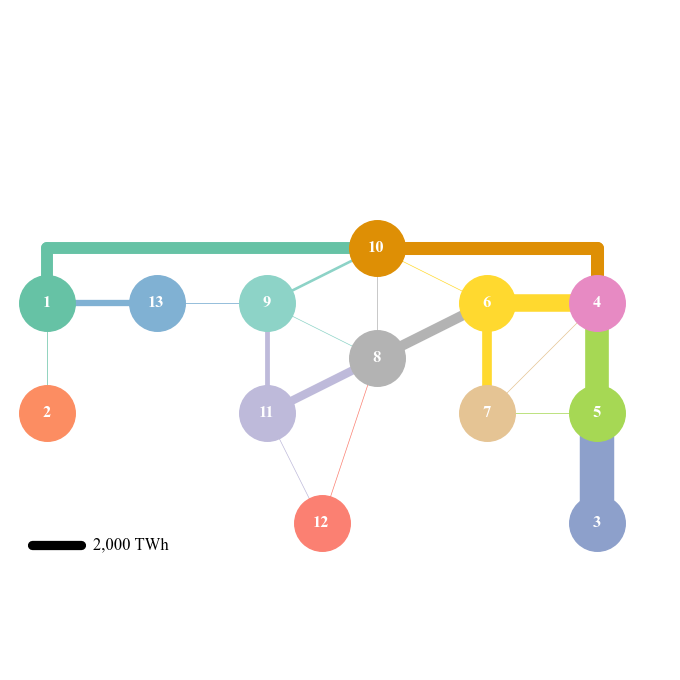

In [ ]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Calculate total flow and share values
total_flow = sum(netflows_links.values())
share_values = [netflows_links[key] / total_flow for key in netflows_links]

# Scale coordinates to fit the plot
scale = 1.5  # Adjust the scale to fit within 6.6x6.6 inch plot
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for key, value in links_dic.items()}

# Plotting the network without background map
fig, ax = plt.subplots(figsize=(6.6, 6.6))
plt.rc("font", size=12)

ax.set_xlim(-3.5 * scale, 5.5 * scale)
ax.set_ylim(-3.5 * scale, 5.5 * scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=1600, color=region_colors[region_key_matched], zorder=5)  # Increased node size
    region_name = region_key.replace('_', ' ').title()
    region_number = regions_dic[region_key]['bus']
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_number, color='white', fontsize=12, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 0.3e9, 0.5)

    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        ax.plot([-3 * scale, -3 * scale], [1.5 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([-3 * scale, 1.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        ax.plot([1.5 * scale, 4.5 * scale], [2.25 * scale, 2.25 * scale], color=color, linewidth=linewidth)
        ax.plot([4.5 * scale, 4.5 * scale], [2.25 * scale, 1.5 * scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Add a reference line for 2,000 TWh
reference_line_width = 2000e6 / 0.3e9  # Convert TWh to the same scale used for linewidth calculation
ax.plot([-3.2 * scale, -3.2 * scale + 1], [-1.8 * scale, -1.8 * scale], color='black', linewidth=reference_line_width)
ax.text(-3.1 * scale + 1.1, -1.8 * scale, '2,000 TWh', color='black', fontsize=12, va='center')

# Remove axes for a cleaner look
ax.set_axis_off()

# Adjust layout to remove extra whitespace
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save figure with tight bounding box
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/flow-chart.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

plt.show()


# **Checks**

## Check for constant deployed capacity

In [ ]:
for key, value in regions_dic.items():
    wind_gen = n.generators_t.p[f"wind_{key}"] 
    pv_gen = n.generators_t.p[f"pv_{key}"]
    cap_wind = wind_gen / res_potential_dic[key]["wind"]
    cap_pv = pv_gen / res_potential_dic[key]["pv"]
    mean_wind = cap_wind.mean() * 100
    std_wind = cap_wind.std()
    mean_pv = cap_pv.mean() * 100
    std_pv = cap_pv.std()
    print(f'{key} wind: {round(mean_wind, 1)}%, {round(std_wind, 8)}')
    print(f'{key} pv: {round(mean_pv, 1)}%, {round(std_pv, 8)}')

north_america wind: 4.2%, 0.0
north_america pv: 3.2%, 0.00062637
latin_america wind: 22.9%, 0.0
latin_america pv: 1.1%, 0.0
oceania wind: 24.2%, 0.0
oceania pv: 15.8%, 0.0
north_asia wind: 46.3%, 0.0
north_asia pv: 0.0%, 0.0
south_asia wind: 100.0%, 0.0
south_asia pv: 0.0%, 0.0
north_west_asia wind: 25.6%, 0.0
north_west_asia pv: 0.9%, 0.0
south_west_asia wind: 100.0%, 0.0
south_west_asia pv: 0.0%, 0.0
middle_east wind: 68.9%, 0.0
middle_east pv: 0.0%, 0.0
europe wind: 12.0%, 0.0
europe pv: 0.0%, 0.0
ups wind: 0.2%, 0.0
ups pv: 0.7%, 0.00016791
north_africa wind: 19.5%, 0.0
north_africa pv: 13.3%, 0.0
africa wind: 14.0%, 0.0
africa pv: 0.2%, 0.0
atlantic_north wind: 5.2%, 0.0
atlantic_north pv: 0.0%, 0.0


# **Investigation of specific events**

## Highest transmission losses

In [ ]:
index = hourly_losses_rel_to_gen.idxmax()
max_value = hourly_losses_rel_to_gen.max()
print("Index of the maximum value:", index)
print("Maximum value:", max_value)

for key, value in regions_dic.items():
    value[f'gen_max_losses'] = (n.generators_t.p[f"wind_{key}"][index] + n.generators_t.p[f"pv_{key}"][index]) * 1e-3
    value[f'load_max_losses'] = n.loads_t.p[f"load_{key}"][index] * 1e-3
    value[f'cur_max_losses'] = n.generators_t.p[f"curtailment_{key}"][index] * 1e-3

Index of the maximum value: 2050-02-05 15:00:00
Maximum value: 0.08607807718921479


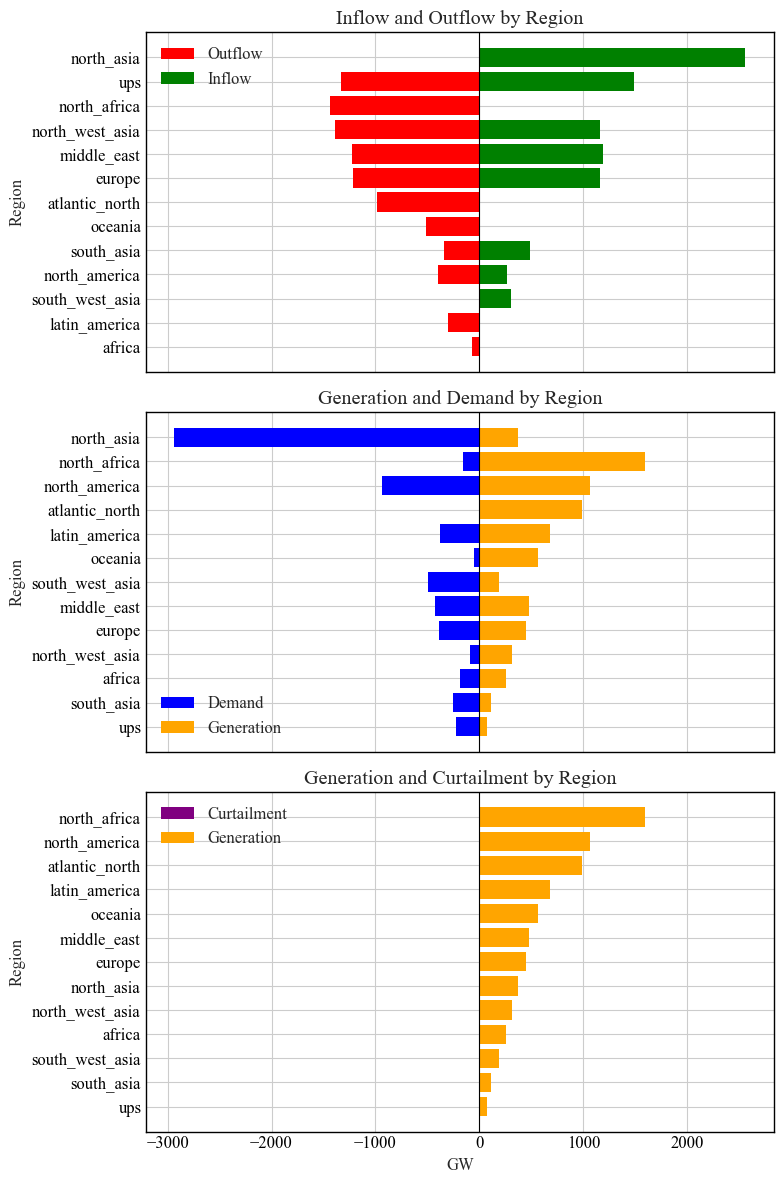

In [ ]:
inflow_outflow_data = [
    (region_key, region_value['inflow_series'][index], region_value['outflow_series'][index])
    for region_key, region_value in regions_dic.items()
]
inflow_outflow_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

generation_demand_data = [
    (region_key, region_value['gen_max_losses'], region_value['load_max_losses'])
    for region_key, region_value in regions_dic.items()
]
generation_demand_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

generation_curtailment_data = [
    (region_key, region_value['gen_max_losses'], region_value['cur_max_losses'])
    for region_key, region_value in regions_dic.items()
]
generation_curtailment_data.sort(key=lambda x: max(x[1], x[2]), reverse=True)

regions_inflow_outflow = [item[0] for item in inflow_outflow_data]
inflows = [item[1] for item in inflow_outflow_data]
outflows = [item[2] for item in inflow_outflow_data]

regions_generation_demand = [item[0] for item in generation_demand_data]
generations_demand = [item[1] for item in generation_demand_data]
demands = [item[2] for item in generation_demand_data]

regions_generation_curtailment = [item[0] for item in generation_curtailment_data]
generations_curtailment = [item[1] for item in generation_curtailment_data]
curtailments = [item[2] for item in generation_curtailment_data]

fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

axs[0].barh(regions_inflow_outflow, [-outflow for outflow in outflows], color='red', label='Outflow')
axs[0].barh(regions_inflow_outflow, inflows, color='green', label='Inflow')
axs[0].axvline(x=0, color='black', linewidth=0.8)
axs[0].set_ylabel('Region')
axs[0].set_title('Inflow and Outflow by Region')
axs[0].grid(True, axis='x')
axs[0].legend()
axs[0].invert_yaxis()

axs[1].barh(regions_generation_demand, [-demand for demand in demands], color='blue', label='Demand')
axs[1].barh(regions_generation_demand, generations_demand, color='orange', label='Generation')
axs[1].axvline(x=0, color='black', linewidth=0.8)
axs[1].set_ylabel('Region')
axs[1].set_title('Generation and Demand by Region')
axs[1].grid(True, axis='x')
axs[1].legend()
axs[1].invert_yaxis()

axs[2].barh(regions_generation_curtailment, [-curtailment for curtailment in curtailments], color='purple', label='Curtailment')
axs[2].barh(regions_generation_curtailment, generations_curtailment, color='orange', label='Generation')
axs[2].axvline(x=0, color='black', linewidth=0.8)
axs[2].set_xlabel('GW')
axs[2].set_ylabel('Region')
axs[2].set_title('Generation and Curtailment by Region')
axs[2].grid(True, axis='x')
axs[2].legend()
axs[2].invert_yaxis()

plt.tight_layout()
plt.show()

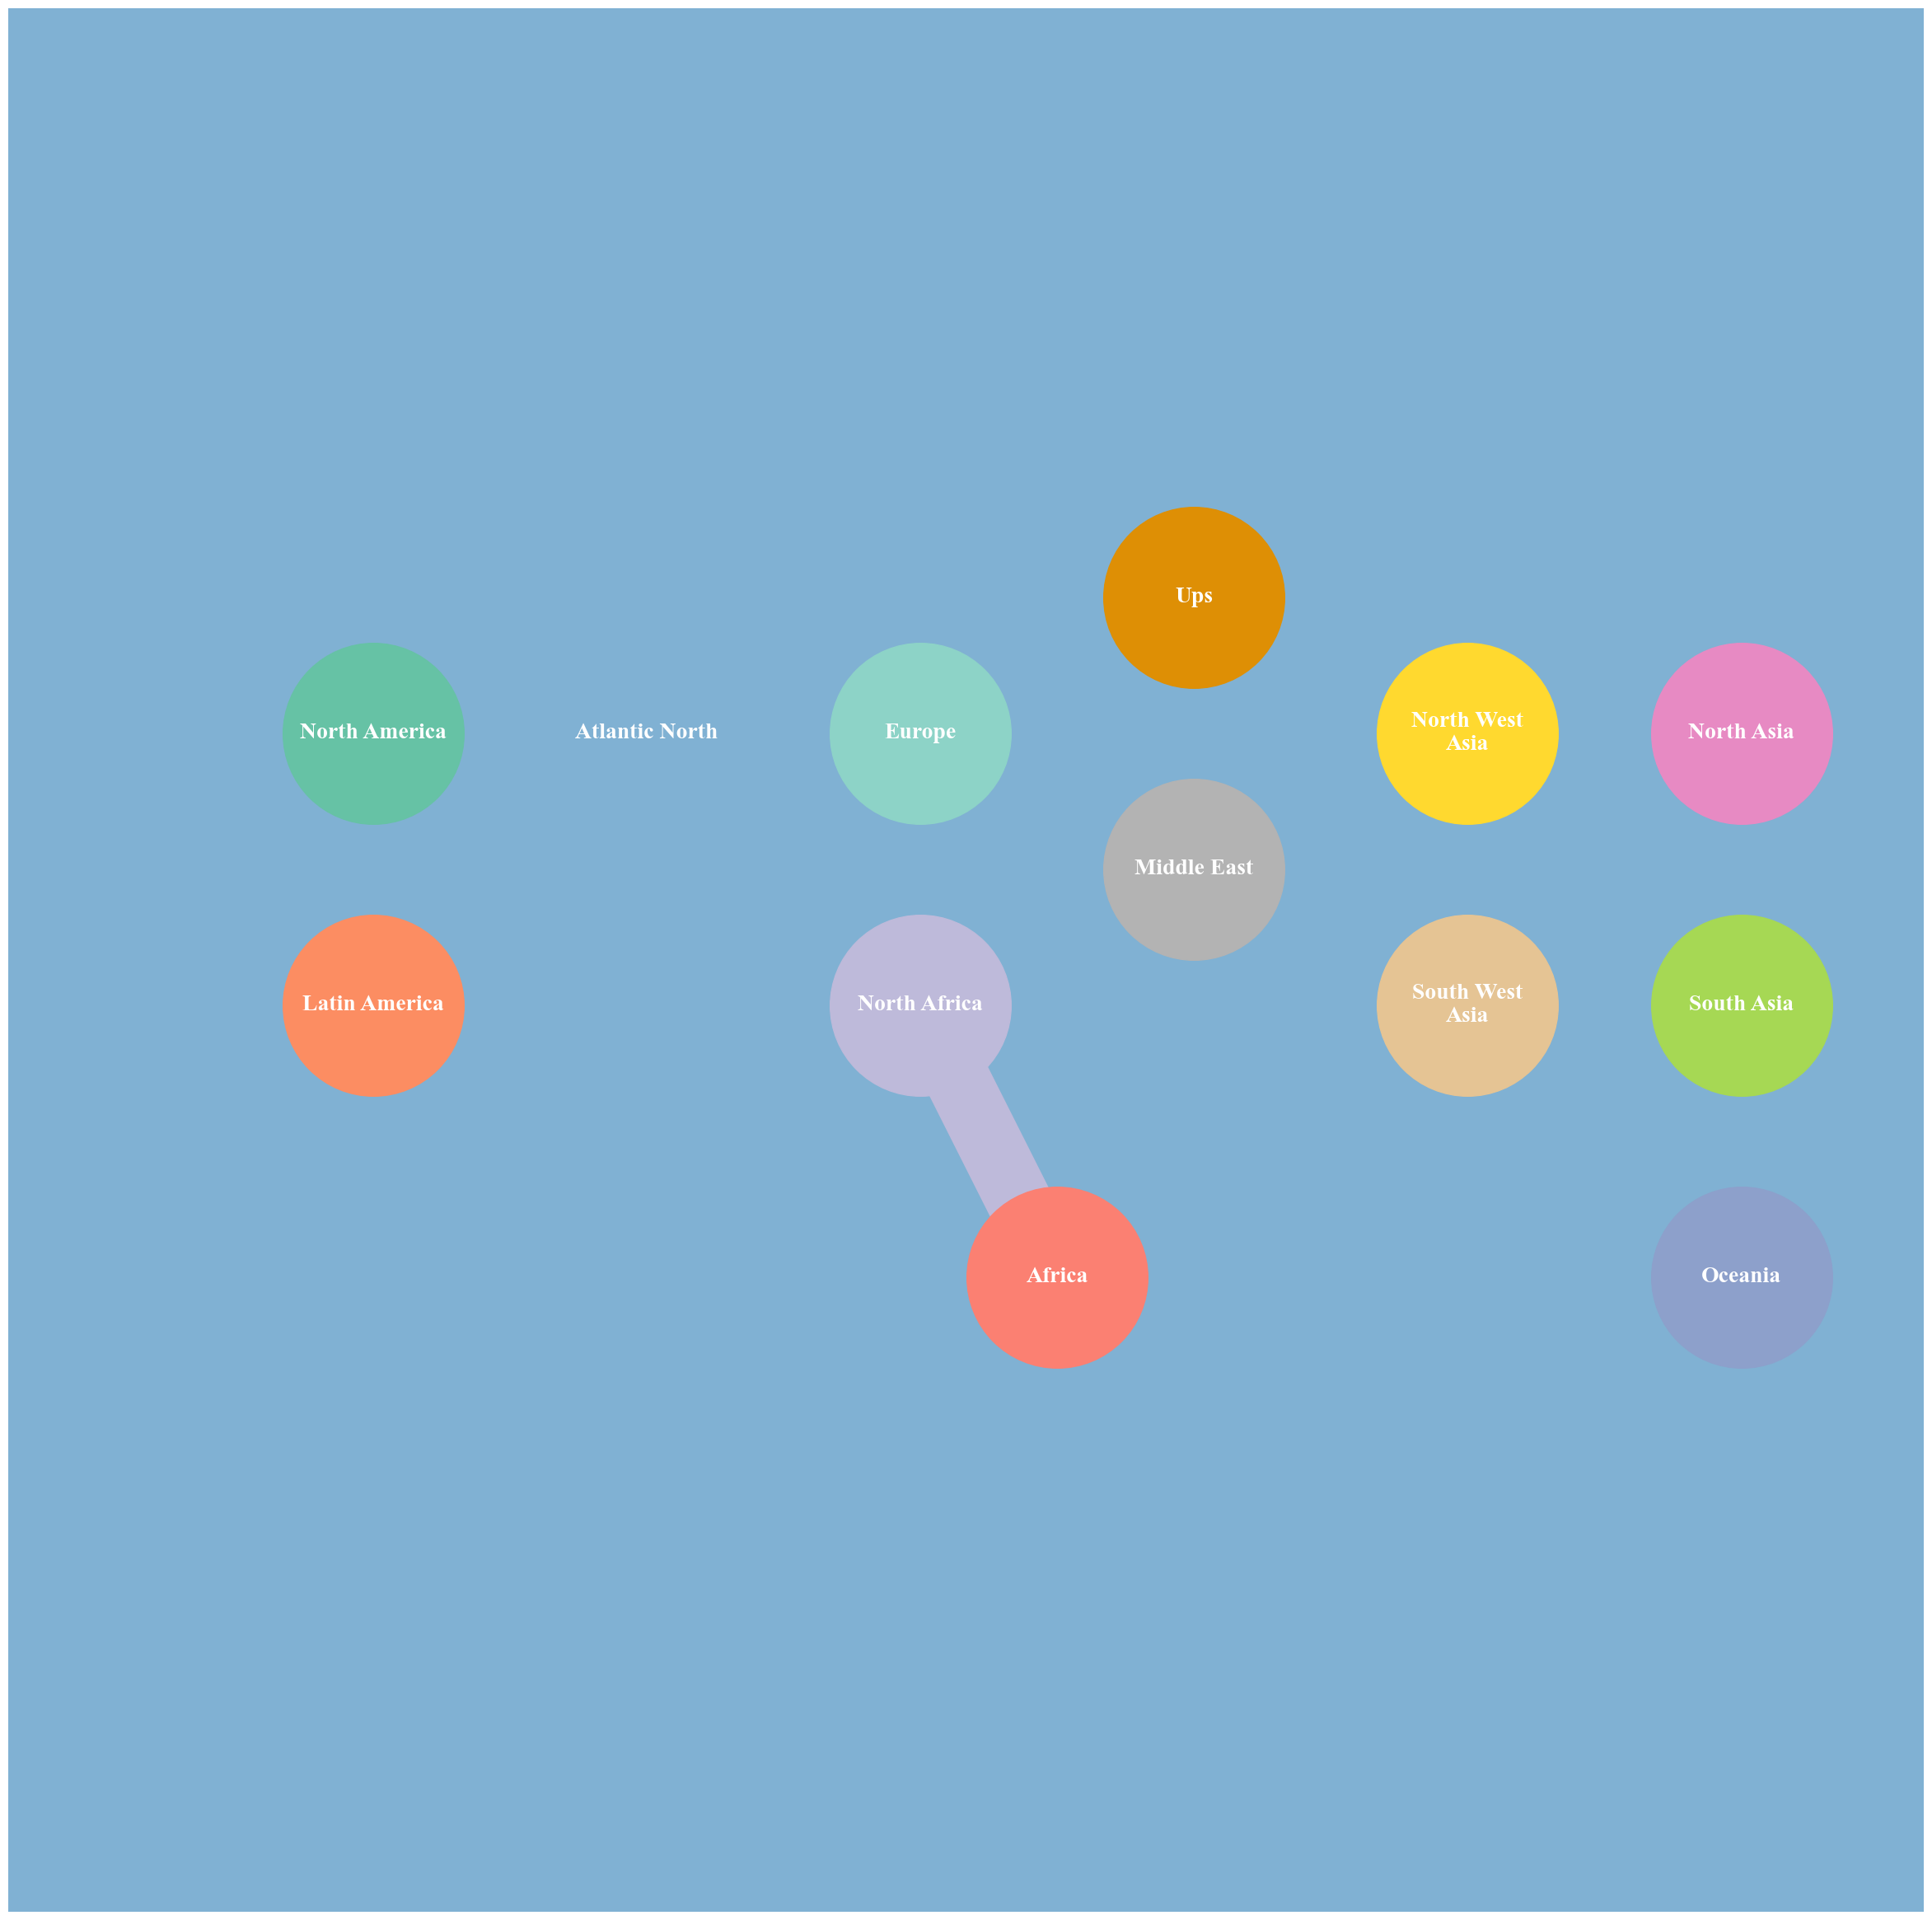

In [ ]:
plt.rc("figure", figsize=(30, 30))

# Define coordinates for each region
coordinates = {
    "north_africa": (0, 0),
    "europe": (0, 1.5),
    "africa": (0.75, -1.5),
    "middle_east": (1.5, 0.75),
    "north_west_asia": (3, 1.5),
    "south_west_asia": (3, 0),
    "south_asia": (4.5, 0),
    "north_asia": (4.5, 1.5),
    "oceania": (4.5, -1.5),
    "ups": (1.5, 2.25),
    "atlantic_north": (-1.5, 1.5),
    "north_america": (-3, 1.5),  
    "latin_america": (-3, 0)
}

# Scale coordinates to fit the plot
scale = 7
scaled_coordinates = {key: (scale * x, scale * y) for key, (x, y) in coordinates.items()}
arrow_colors = {value['name']: netflows_links[key] for i, (key, value) in enumerate(links_dic.items())}  # Example values for color


# Plotting the network without background map
fig, ax = plt.subplots()
ax.set_xlim(-5*scale, 5.5*scale)
ax.set_ylim(-5*scale, 5.5*scale)

# Plot nodes
for region_key, (x, y) in scaled_coordinates.items():
    region_key_matched = next((key for key in regions_dic.keys() if key.lower() == region_key.lower()), None)
    if region_key_matched is None:
        continue
    ax.scatter(x, y, s=25000, color=region_colors[region_key_matched], zorder=5)
    region_name = region_key.replace('_', ' ').title()
    words = region_name.split()
    if len(words) == 3:
        region_name = f'{words[0]} {words[1]}\n{words[2]}'
    ax.text(x, y, region_name, color='white', fontsize=20, ha='center', va='center', zorder=6, fontweight='bold')

# Plot lines
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f"{value['name']}_0", 'bus0']
    bus1 = n.links.loc[f"{value['name']}_0", 'bus1']
    
    if bus0 is None or bus1 is None:
        print('Region key is none')
        continue
    
    flow = arrow_colors[value['name']]
    linewidth = max(np.abs(flow) / 1.2e4, 0.1)
    color = region_colors.get(bus0 if flow_statements[key] else bus1, 'grey')

    if key == "1_10":
        # Draw the L-shaped line for link 1_10
        ax.plot([-3*scale, -3*scale], [1.5*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([-3*scale, 1.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
    elif key == "4_10":
        # Draw the L-shaped line for link 4_10
        ax.plot([1.5*scale, 4.5*scale], [2.25*scale, 2.25*scale], color=color, linewidth=linewidth)
        ax.plot([4.5*scale, 4.5*scale], [2.25*scale, 1.5*scale], color=color, linewidth=linewidth)
    else:
        ax.plot([scaled_coordinates[bus0][0], scaled_coordinates[bus1][0]], 
                [scaled_coordinates[bus0][1], scaled_coordinates[bus1][1]], color=color, linewidth=linewidth)

# Remove axes for a cleaner look
ax.set_axis_off()

plt.show()


## Curtailment and Net Flow in Atlantic North

In [ ]:
netflow_series = regions_dic['atlantic_north']['netflow_series']
max_netflow_value = netflow_series.max()
max_netflow_index = netflow_series.idxmax()
max_netflow_index

Timestamp('2050-08-21 13:00:00')

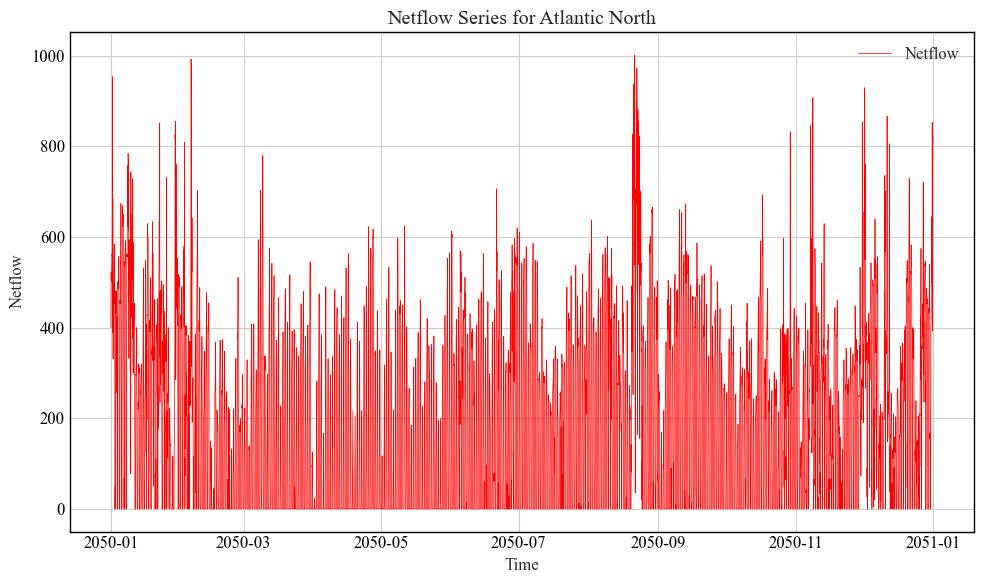

In [ ]:
# Assuming netflow_series is already defined as a pandas Series
curtailment_series = n.generators_t.p['curtailment_atlantic_north'] * 1e-3
netflow_series = regions_dic['atlantic_north']['netflow_series']
daily_netflow = netflow_series.groupby(netflow_series.index.date).sum()
demand_series_north_asia = n.loads_t.p_set['load_north_asia']
daily_demand_north_asia = demand_series_north_asia.groupby(demand_series_north_asia.index.date).sum()
# Plotting the series as a scatter plot
plt.figure(figsize=(10, 6))
#plt.scatter(difference.index, difference.values, label='Netflow', color='blue', s=5)
#plt.scatter(curtailment_series.index, curtailment_series.values, label='Curtailment', color='red', s=5)
plt.plot(netflow_series.index, netflow_series.values, label='Netflow', color='red', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Netflow')
plt.title('Netflow Series for Atlantic North')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

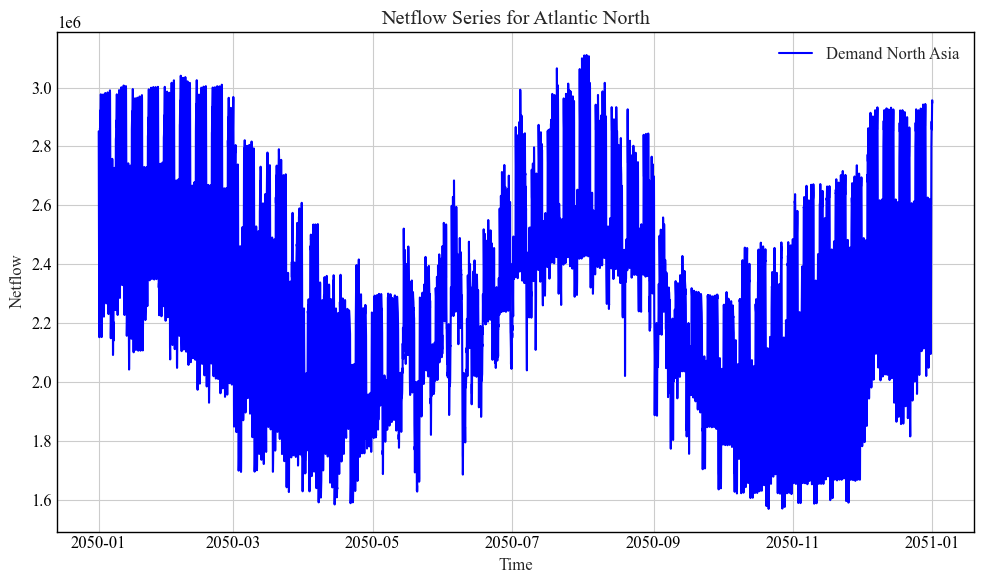

In [ ]:
# Assuming netflow_series is already defined as a pandas Series
curtailment_series = n.generators_t.p['curtailment_atlantic_north'] * 1e-3
netflow_series = regions_dic['atlantic_north']['netflow_series']
daily_netflow = netflow_series.groupby(netflow_series.index.date).sum()
demand_series_north_asia = n.loads_t.p_set['load_north_asia']
daily_demand_north_asia = demand_series_north_asia.groupby(demand_series_north_asia.index.date).sum()
# Plotting the series as a scatter plot
plt.figure(figsize=(10, 6))
plt.plot(demand_series_north_asia.index, demand_series_north_asia.values, label='Demand North Asia', color='blue')
plt.xlabel('Time')
plt.ylabel('Netflow')
plt.title('Netflow Series for Atlantic North')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Availability of VRE**

# Temporal availability

## Scatter plot of supply over demand 

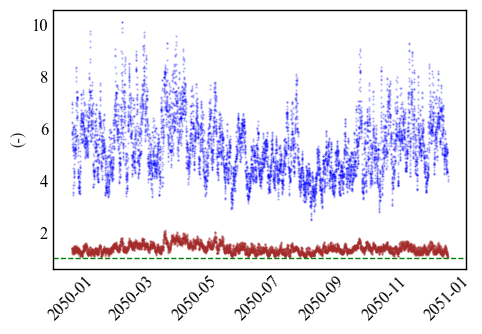

In [ ]:
demand = 0
supply = 0
for key, value in regions_dic.items():
    demand += n.loads_t.p[f'load_{key}'] * 1e-3 #GW
    supply += (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}']) * 1e-3 
demand_supply_ratio = supply / demand
demand_supply_ratio_no_trans = pd.read_csv('demand_supply_ratio.csv', index_col=0)
fig, ax = plt.subplots(figsize=(5,3.5))
ax.scatter(demand_supply_ratio.index, demand_supply_ratio.values, s=0.3, color='brown', alpha=0.3)
ax.scatter(demand_supply_ratio.index, demand_supply_ratio_no_trans.values, s=0.3, color='blue', alpha=0.3)
ax.axhline(y=1, color='green', linewidth=1, linestyle='--')
ax.grid(False)
ax.set_ylabel('(-)', fontsize=12)
#ax.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# **Curtailment**

## Scatter plot global

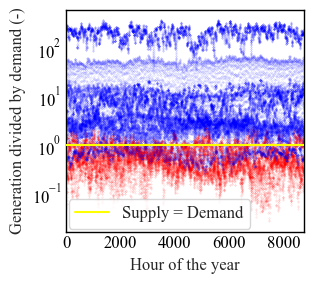

85.85996955859969 91.36415525114155


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

net_importer = ['north_asia', 'south_west_asia', 'europe']
net_exporter = ['oceania', 'north_west_asia', 'north_africa', 'atlantic_north', 'africa', 'north_america']
demand_net_importer = 0 
supply_net_importer = 0
demand_net_exporter = 0
supply_net_exporter = 0


#share_ex = (demand_supply_ratio_ex > 1).sum() / 8760 * 100
share_im = 0
fig, ax = plt.subplots(figsize=(3.3, 3))
for key in net_importer:
    demand_net_importer = n.loads_t.p[f'load_{key}'] 
    supply_net_importer = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    demand_supply_ratio_im = supply_net_importer / demand_net_importer
    scatter_im = ax.scatter(demand_supply_ratio_im.index, demand_supply_ratio_im.values, s=0.07, color='red', alpha=0.2)
    share_im += (demand_supply_ratio_im < 1).sum() / 8760 * 100
share_im = share_im / len(net_importer)
share_ex = 0
for key in net_exporter:
    demand_net_exporter = n.loads_t.p[f'load_{key}'] 
    supply_net_exporter = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    demand_supply_ratio_ex = supply_net_exporter / demand_net_exporter
    scatter_ex = ax.scatter(demand_supply_ratio_ex.index, demand_supply_ratio_ex.values, s=0.07, color='blue', alpha=0.2)
    share_ex += (demand_supply_ratio_ex > 1).sum() / 8760 * 100
share_ex = share_ex / len(net_exporter)
ax.axhline(y=1, color='yellow', linewidth=1.5, linestyle='-', label='Supply = Demand', zorder=10)

ax.grid(False)
ax.set_ylabel('Generation divided by demand (-)', fontsize=12)
ax.set_xlabel('Hour of the year')
ax.set_xlim(demand_supply_ratio_im.index[0], demand_supply_ratio_im.index[-1])
# Calculate the number of hours in the year and set x-ticks at every full 1000-hour interval
num_hours = len(demand_supply_ratio_im.index)
ticks_to_use = np.arange(0, num_hours, 2000)

# Extract the timestamps for the ticks
timestamps = demand_supply_ratio_im.index[ticks_to_use]

# Create labels as hours of the year
tick_labels = [str(i) for i in ticks_to_use]

ax.set_xticks(timestamps)
ax.set_xticklabels(tick_labels)
ax.set_yscale('log')
plt.tight_layout()
plt.legend(fontsize=12, frameon=True, loc='lower left', bbox_to_anchor=[-0.025, -0.025]) # handles=[scatter_im, scatter_ex], scatterpoints=1, markerscale=10,
plt.savefig('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/scatter-plot.svg', format='svg')
plt.show()
print(share_im, share_ex)


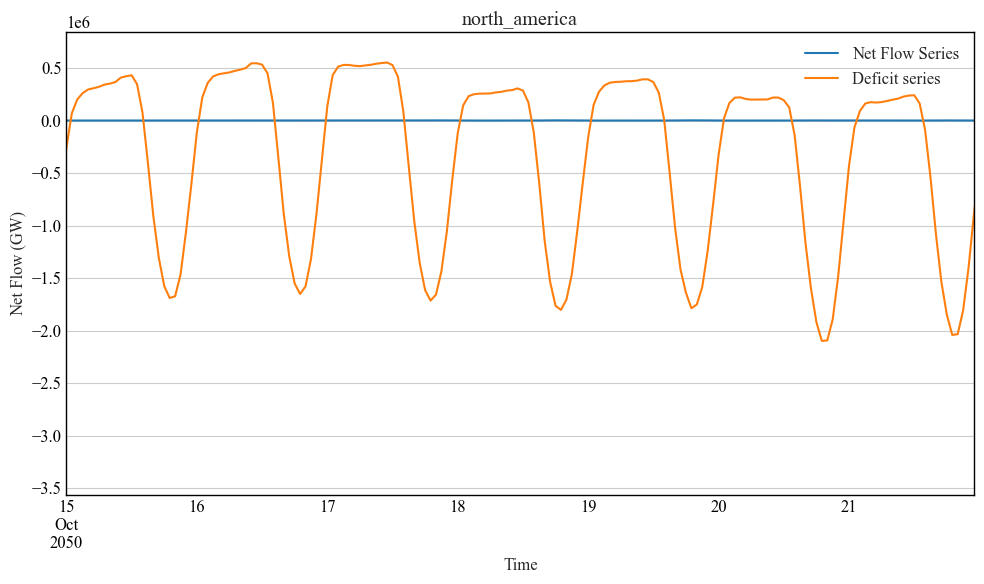

In [ ]:
na = ['north_america']
for key in na:
    demand_net_importer = n.loads_t.p[f'load_{key}'] 
    supply_net_importer = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    series_netflow = regions_dic[f'{key}']['netflow_series']

series_deficit = demand_net_importer - supply_net_importer
plt.figure(figsize=(10, 6))
series_netflow.plot(label='Net Flow Series')
series_deficit.plot(label='Deficit series')
plt.title(f'{key}')
plt.xlabel('Time')
plt.ylabel('Net Flow (GW)')
plt.grid(True)
plt.xlim(pd.Timestamp('2050-10-15 00:00'), pd.Timestamp('2050-10-21 23:00'))
#plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

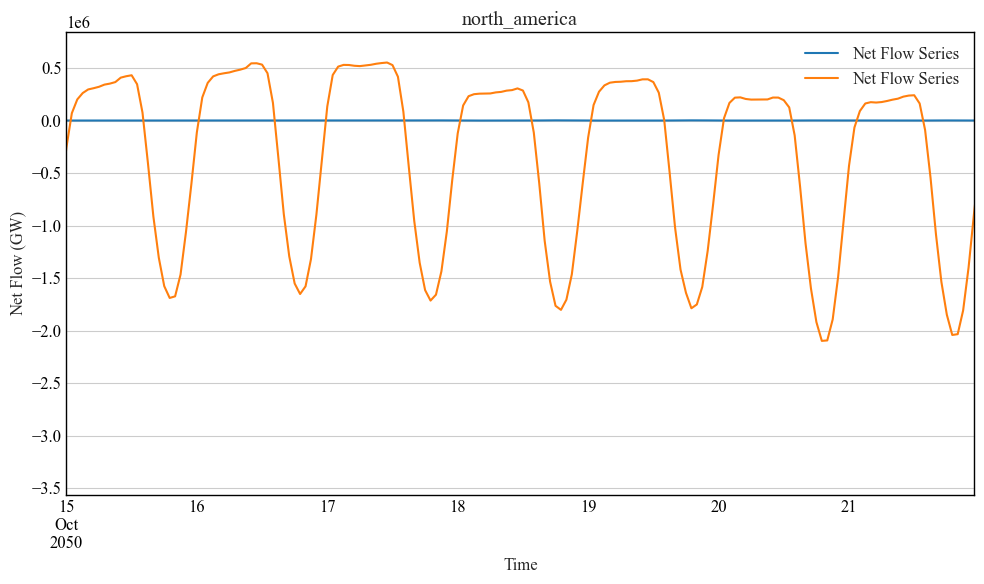

In [ ]:
na = ['north_america']
for key in na:
    demand_net_importer = n.loads_t.p[f'load_{key}'] 
    supply_net_importer = (n.generators_t.p[f'wind_{key}'] + n.generators_t.p[f'pv_{key}'])
    series_netflow = regions_dic[f'{key}']['netflow_series']

series_deficit = demand_net_importer - supply_net_importer
plt.figure(figsize=(10, 6))
series_netflow.plot(label='Net Flow Series')
series_deficit.plot(label='Net Flow Series')
plt.title(f'{key}')
plt.xlabel('Time')
plt.ylabel('Net Flow (GW)')
plt.grid(True)
plt.xlim(pd.Timestamp('2050-10-15 00:00'), pd.Timestamp('2050-10-21 23:00'))
plt.legend()
plt.tight_layout()
plt.show()

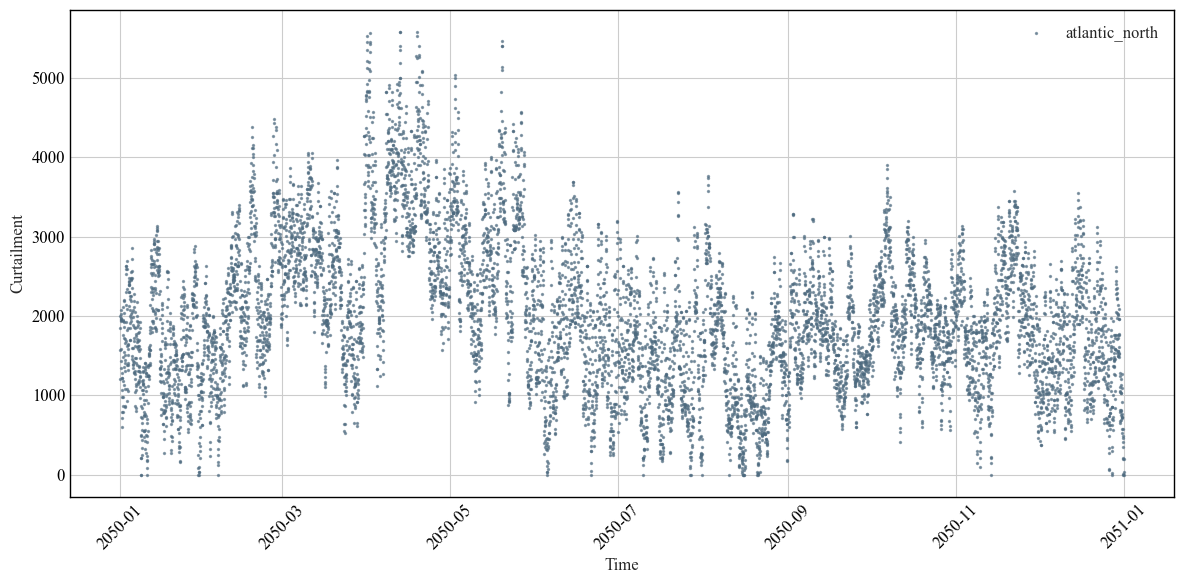

In [ ]:
tolerance = 1e-3 # tolerance for numerical inaccuracies
curtailment = 0
for key, value in regions_dic.items():
    curtailment +=  n.generators_t.p[f'curtailment_{key}'] * 1e-3 

fig, ax = plt.subplots(figsize=(12,6))

ax.scatter(curtailment.index, curtailment.values, s=2, color=color_, alpha=0.6, label=f'{key}')

ax.set_xlabel('Time')
ax.set_ylabel('Curtailment')
ax.set_yscale('linear')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Scatter plot atlantic north

In [ ]:
# Graph
region = 'atlantic_north'
series = curtailment[region]
fig, ax = plt.subplots(figsize=(12,6))
color_ = region_colors[region]
ax.scatter(series.index, series.values, s=2, color=color_, alpha=0.6, label=f'{key}')

ax.set_xlabel('Time')
ax.set_ylabel('Supply over demand')
ax.set_yscale('linear')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))  
plt.plot(series.index, series.values, label='Curtailment', color='red', linewidth=1, linestyle='-', alpha=0.6)
plt.xlabel('Time', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('MW', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit elements better
plt.show()
plt.show()

KeyError: 'atlantic_north'

## Time series generation vs demand North Asia

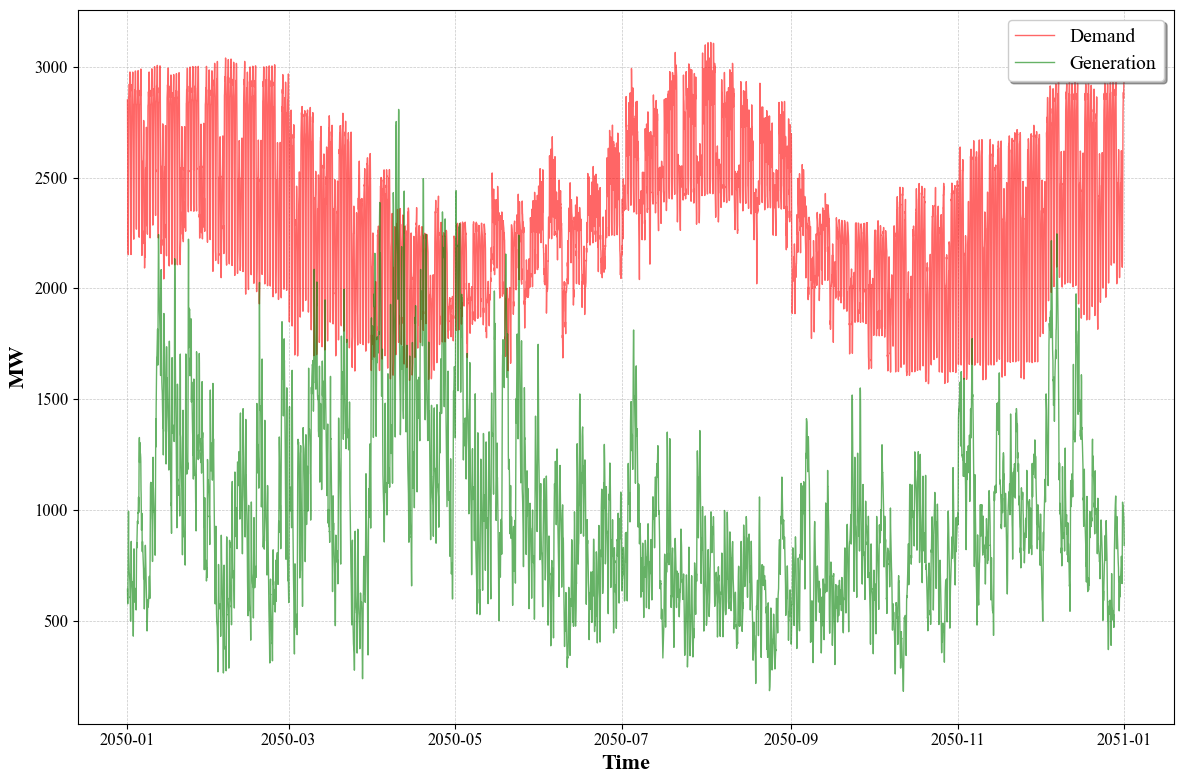

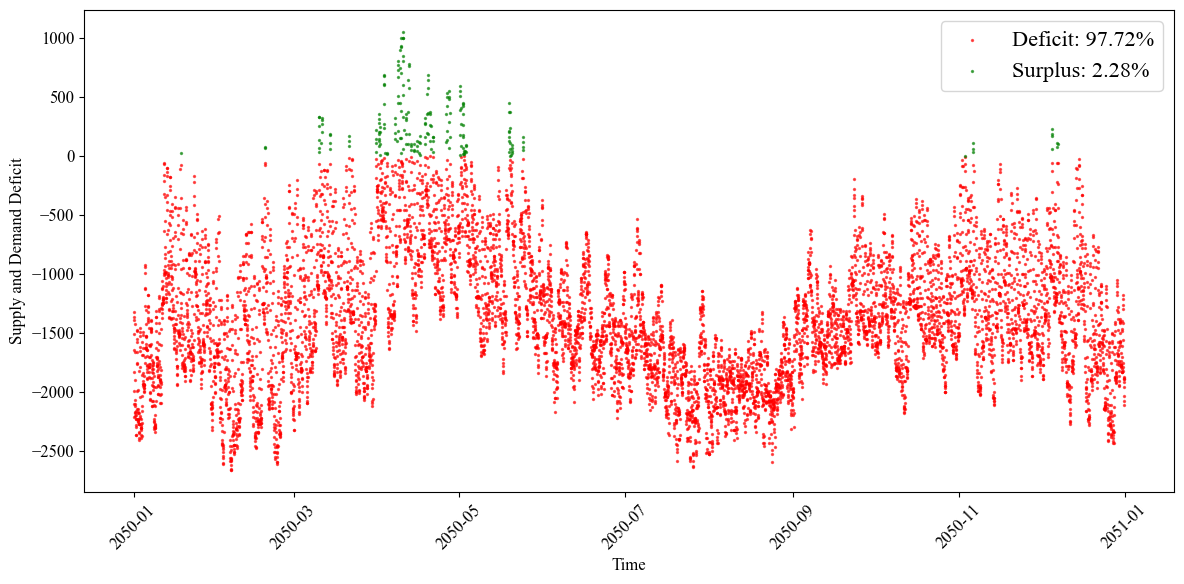

In [ ]:
demand_north_asia = n.loads_t.p[f'load_north_asia'] * 1e-3
gen_north_asia = (n.generators_t.p['wind_north_asia'] + n.generators_t.p['pv_north_asia']) * 1e-3
deficit = gen_north_asia - demand_north_asia

# Graph
plt.figure(figsize=(12, 8))  
plt.plot(demand_north_asia.index, demand_north_asia.values, label='Demand', color='red', linewidth=1, linestyle='-', alpha=0.6)
plt.plot(gen_north_asia.index, gen_north_asia.values, label='Generation', color='green', linewidth=1, linestyle='-', alpha=0.6)
plt.xlabel('Time', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('MW', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit elements better
plt.show()
plt.show()

# scatter plot
# Calculate percentages
total_points = len(deficit)
points_above_zero = (deficit > 0).sum()
points_below_zero = (deficit <= 0).sum()

percentage_above_zero = (points_above_zero / total_points) * 100
percentage_below_zero = (points_below_zero / total_points) * 100

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot points below zero in red
ax.scatter(deficit[deficit <= 0].index, deficit[deficit <= 0].values, s=2, color='red', alpha=0.6, label=f'Deficit: {percentage_below_zero:.2f}%')

# Plot points above zero in green
ax.scatter(deficit[deficit > 0].index, deficit[deficit > 0].values, s=2, color='green', alpha=0.6, label=f'Surplus: {percentage_above_zero:.2f}%')

# Customize the plot
ax.set_xlabel('Time')
ax.set_ylabel('Supply and Demand Deficit')
ax.set_yscale('linear')
ax.legend(fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Time series inflow north asia 

In [ ]:
inflow_north_asia = regions_dic['north_asia']['netflow_series']

# Graph
plt.figure(figsize=(12, 8))  
plt.plot(inflow_north_asia.index, inflow_north_asia.values, label='Net flow', color='red', linewidth=1, linestyle='-', alpha=0.6)
plt.xlabel('Time', fontsize=16, fontweight='bold')  # Increase font size
plt.ylabel('GW', fontsize=16, fontweight='bold')  # Increase font size and add a more descriptive label
plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)  # Move legend to upper left, increase font size, add frame and shadow
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Add grid for better readability
plt.tight_layout()  # Adjust layout to fit elements better
plt.show()
plt.show()

## Fourier series generation vs demand North Asia

In [ ]:
# Convert to numpy array
hourly_p_trans_rel_gen_array = deficit.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Supply vs Demand deficit', fontweight='bold')
ax.grid(True, axis='x')

plt.show()


## Fourier series inflow north asia

In [ ]:
# Convert to numpy array
hourly_p_trans_rel_gen_array = inflow_north_asia.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Supply vs Demand deficit', fontweight='bold')
ax.grid(True, axis='x')

plt.show()

## Fourier series VRE potential atlantic north

In [ ]:
# Convert to numpy array
series = res_potential_dic['atlantic_north']['pv']
hourly_p_trans_rel_gen_array = series.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
eight_hour_freq = 1 / 8.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, eight_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '8 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/5.5)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Supply vs Demand deficit', fontweight='bold')
ax.grid(True, axis='x')

plt.show()

## Correlation Matrix of VRE potentials vs Demand 

In [ ]:
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})


regions = data1.columns

# Create empty correlation matrices
correlation_matrix1 = pd.DataFrame(index=regions, columns=regions)
correlation_matrix2 = pd.DataFrame(index=regions, columns=regions)

# Fill the correlation matrices
for i in regions:
    for j in regions:
        correlation_matrix1.loc[i, j] = data1[i].corr(demand[j])
        correlation_matrix2.loc[i, j] = data2[i].corr(demand[j])

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for data1
ax1 = axes[0]
cax1 = ax1.matshow(correlation_matrix1.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_xticks(range(len(correlation_matrix1.columns)))
ax1.set_yticks(range(len(correlation_matrix1.index)))
ax1.set_xticklabels(correlation_matrix1.columns, rotation=45, ha='left', fontsize=12)
ax1.set_yticklabels(correlation_matrix1.index, fontsize=12)
ax1.set_title('Correlation Matrix: Solar and Demand', fontsize=14, fontweight='bold', pad=20)
ax1.grid(False)

# Add text annotations
for i in range(len(correlation_matrix1.columns)):
    for j in range(len(correlation_matrix1.index)):
        ax1.text(i, j, f'{correlation_matrix1.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

# Plot for data2
ax2 = axes[1]
cax2 = ax2.matshow(correlation_matrix2.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_xticks(range(len(correlation_matrix2.columns)))
ax2.set_yticks(range(len(correlation_matrix2.index)))
ax2.set_xticklabels(correlation_matrix2.columns, rotation=45, ha='left', fontsize=12)
ax2.set_yticklabels(correlation_matrix2.index, fontsize=12)
ax2.set_title('Correlation Matrix: Wind and Demand', fontsize=14, fontweight='bold', pad=20)
ax2.grid(False)

# Add text annotations
for i in range(len(correlation_matrix2.columns)):
    for j in range(len(correlation_matrix2.index)):
        ax2.text(i, j, f'{correlation_matrix2.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')


plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming res_potential_dic and load_profile_dic are already defined as dictionaries

# Create DataFrames for PV, wind, and demand
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})

regions = data1.columns

# Create empty correlation matrices
correlation_matrix1 = pd.DataFrame(index=regions, columns=regions)
correlation_matrix2 = pd.DataFrame(index=regions, columns=regions)

# Fill the correlation matrices
for i in regions:
    for j in regions:
        adjusted_demand_j = demand[j] - demand[i]
        correlation_matrix1.loc[i, j] = data1[i].corr(adjusted_demand_j)
        correlation_matrix2.loc[i, j] = data2[i].corr(adjusted_demand_j)

# Plot the correlation matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for data1
ax1 = axes[0]
cax1 = ax1.matshow(correlation_matrix1.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax1.set_xticks(range(len(correlation_matrix1.columns)))
ax1.set_yticks(range(len(correlation_matrix1.index)))
ax1.set_xticklabels(correlation_matrix1.columns, rotation=45, ha='left', fontsize=12)
ax1.set_yticklabels(correlation_matrix1.index, fontsize=12)
ax1.set_title('Correlation Matrix: Solar and Adjusted Demand', fontsize=14, fontweight='bold', pad=20)
ax1.grid(False)

# Add text annotations
for i in range(len(correlation_matrix1.columns)):
    for j in range(len(correlation_matrix1.index)):
        ax1.text(i, j, f'{correlation_matrix1.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

# Plot for data2
ax2 = axes[1]
cax2 = ax2.matshow(correlation_matrix2.astype(float), cmap='coolwarm', vmin=-1, vmax=1)
ax2.set_xticks(range(len(correlation_matrix2.columns)))
ax2.set_yticks(range(len(correlation_matrix2.index)))
ax2.set_xticklabels(correlation_matrix2.columns, rotation=45, ha='left', fontsize=12)
ax2.set_yticklabels(correlation_matrix2.index, fontsize=12)
ax2.set_title('Correlation Matrix: Wind and Adjusted Demand', fontsize=14, fontweight='bold', pad=20)
ax2.grid(False)

# Add text annotations
for i in range(len(correlation_matrix2.columns)):
    for j in range(len(correlation_matrix2.index)):
        ax2.text(i, j, f'{correlation_matrix2.iloc[j, i]:.2f}', ha='center', va='center', color='black', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming res_potential_dic and load_profile_dic are already defined as dictionaries

# Create DataFrames for PV, wind, and demand
data1 = pd.DataFrame({key: res_potential_dic[key]['pv'] for i, (key, value) in enumerate(regions_dic.items())})
data2 = pd.DataFrame({key: res_potential_dic[key]['wind'] for i, (key, value) in enumerate(regions_dic.items())})
demand = pd.DataFrame({key: load_profile_dic[key]['load'] for i, (key, value) in enumerate(regions_dic.items())})
generation = pd.DataFrame({key: n.generators_t.p[f'wind_{key}'] for i, (key, value) in enumerate(regions_dic.items())})
regions = list(regions_dic.keys())
num_regions = len(regions)

# Initialize the R-squared matrix
r_squared_matrix = np.zeros((num_regions, num_regions))

# Loop through each region's demand and each region's PV and wind
for i, region_demand in enumerate(regions):

    for j, region_generation in enumerate(regions):
        y = demand[region_demand].values - demand[region_generation].values
        X = np.vstack([data1[region_generation].values, data2[region_generation].values, data1[region_demand].values, data2[region_demand].values]).T
        model = LinearRegression().fit(X, y)
        r_squared = model.score(X, y)
        r_squared_matrix[j, i] = r_squared

# Convert R-squared matrix to DataFrame for better readability
r_squared_df = pd.DataFrame(r_squared_matrix, index=regions, columns=regions)

# Plot the R-squared matrix
fig, ax = plt.subplots(figsize=(6.6, 6.6))

# Display the matrix values with reversed colormap
cax = ax.matshow(r_squared_df, cmap='PuBu', vmin=0, vmax=1)
index = r_squared_df.columns
labels = [label.replace('_', ' ').title() for label in index]
# Set axis ticks and labels
ax.grid(False)
ax.set_xticks(range(len(r_squared_df.columns)))
ax.set_yticks(range(len(r_squared_df.index)))
ax.set_xticklabels(labels, rotation=45, fontsize=12, ha='left')
ax.set_yticklabels(labels, fontsize=12)

# Add text annotations
for i in range(len(r_squared_df.columns)):
    for j in range(len(r_squared_df.index)):
        if i != j:
            plt.text(i, j, f'{r_squared_df.iloc[j, i]:.2f}', ha='center', va='center', color= 'black', fontsize=12, fontweight='bold')

# Title and layout adjustments
#plt.title('R-squared Matrix: PV & Wind Generation vs. Demand', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/Figures_py/correlation-matrix-vre-demand.pdf', format='pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()


# Comparison to alternative energy carriers

## DAC

In [ ]:
dac_demand_MWh_t = 1.89# MWh/tCO2 # https://www.iea.org/energy-system/carbon-capture-utilisation-and-storage/direct-air-capture
dac_demand_TWh_Mt = dac_demand_MWh_t * 1e-3 * 1e6
global_demand_co2_removal = 80 # Mt per year
potential_DAC_removal_Mt = 17500 / dac_demand_TWh_Mt
share = potential_DAC_removal_Mt / global_demand_co2_removal
print(potential_DAC_removal_Mt)
print(share)

9.25925925925926
0.11574074074074074


## Hydrogen

In [ ]:
global_h2_demand_2050 = 585 # Mt # net zero scenario # https://www.mckinsey.com/industries/oil-and-gas/our-insights/global-energy-perspective-2023-hydrogen-outlook
h2_demand_kWh_kg = 40 #kWh/kg # https://www.mdpi.com/2071-1050/15/24/16917
h2_demand_kWh_Mt = h2_demand_kWh_kg * 1e9
h2_demand_TWh_Mt = h2_demand_kWh_Mt * 1e-9
h2_demand_TWh_Mt = 40 #TWh/Mt
potential_h2_production = 17500 / h2_demand_TWh_Mt
print(potential_h2_production)
share = potential_h2_production / global_h2_demand_2050
print(share)

437.5
0.7478632478632479


## Desalination

In [111]:
desalination_energy_kWh_m3 = 2.5 # kWh/m3 # https://www.amtaorg.com/wp-content/uploads/07_Membrane_Desalination_Power_Usage_Put_In_Perspective.pdf
desalination_energy_TWh_m3 = desalination_energy_kWh_m3 * 1e-9
annual_desalination_water_km3 = 17500 / desalination_energy_TWh_m3 * 1e-9
daily_desalination_water_km3 = annual_desalination_water_km3 / 365
global_demand_daily_l = 5e9
global_demand_daily_m3 = global_demand_daily_l * 1e-3
global_demand_daily_km3 = global_demand_daily_m3 * 1e-6
print(f'{daily_desalination_water_km3}')
print(global_demand_daily_km3)




19.17808219178082
5.0


## Agriculture

In [ ]:
greenhouse_intensity_GJ_ha = 13000 #GJ/ha in GER (tomatoes)#https://www.mdpi.com/2076-3417/12/10/5150#:~:text=Most%20energy%20consumption%20is%20associated,of%20the%20total%20fossil%20sources).
yield_tomato = 50 # kg/m2
ha_to_m2 = 1e-4 
greenhouse_intensity_GWh_ha = greenhouse_intensity_GJ_ha * gj_to_gwh 
greenhouse_intensity_GWh_m2 = greenhouse_intensity_GWh_ha * ha_to_m2
greenhouse_intensity_GWh_kg = greenhouse_intensity_GWh_m2 * yield_tomato
tomato_cap_Mt = total_annual_cur *1e-3 / greenhouse_intensity_GWh_kg * 1e-3
print(f'{tomato_cap_Mt:.2e} tons')



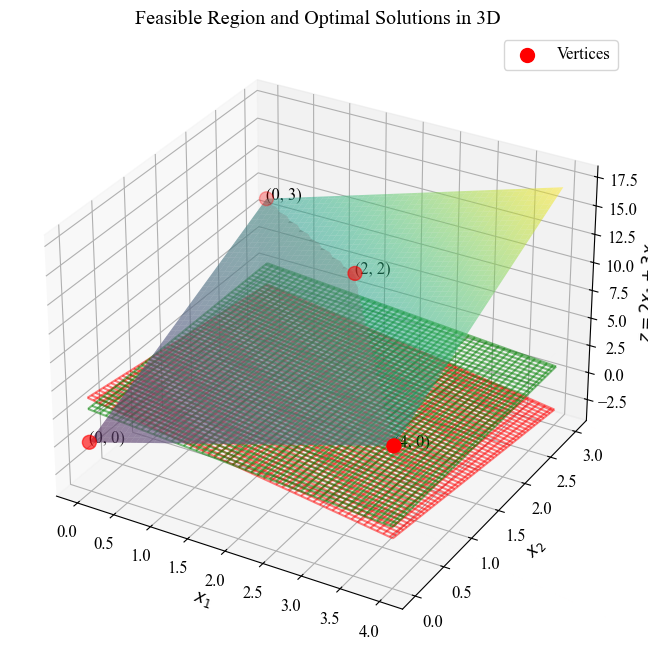

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a mesh grid for x1 and x2
x1 = np.linspace(0, 4, 100)
x2 = np.linspace(0, 3, 100)
x1, x2 = np.meshgrid(x1, x2)
z = 2 * x1 + 3 * x2  # Objective function

# Constraints
constraint1 = 4 - x1 - x2
constraint2 = (6 - x1) / 2

# Feasible region mask
feasible_mask = (x1 + x2 <= 4) & (x1 + 2 * x2 <= 6)

# Vertices of the feasible region
vertices = np.array([[0, 0], [0, 3], [2, 2], [4, 0]])
z_vertices = 2 * vertices[:, 0] + 3 * vertices[:, 1]

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the objective function surface
ax.plot_surface(x1, x2, z, alpha=0.5, cmap='viridis')

# Plot the constraints as wireframes
ax.plot_wireframe(x1, x2, constraint1, color='r', alpha=0.5)
ax.plot_wireframe(x1, x2, constraint2, color='g', alpha=0.5)

# Highlight the feasible region
feasible_z = np.where(feasible_mask, z, np.nan)
ax.plot_surface(x1, x2, feasible_z, alpha=0.3, color='grey')

# Plot vertices and optimal solutions
ax.scatter(vertices[:, 0], vertices[:, 1], z_vertices, color='red', s=100, label='Vertices')

# Annotate the vertices
for (i, vert) in enumerate(vertices):
    ax.text(vert[0], vert[1], z_vertices[i], f'({vert[0]}, {vert[1]})', fontsize=12)

# Labels and title
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$z = 2x_1 + 3x_2$')
ax.set_title('Feasible Region and Optimal Solutions in 3D')
ax.legend()

plt.show()
